#Imports

In [ ]:
import pandas as pd
pd.set_option("max_colwidth", 160)
pd.set_option("display.max_columns", None)

import numpy as np
from sklearn.dummy import DummyClassifier
import collections
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import cohen_kappa_score, accuracy_score


from keras import layers
from tensorflow.keras import optimizers
from keras.models import Sequential
import tensorflow as tf
from tensorflow import keras


from sklearn.preprocessing import LabelEncoder
from keras.utils import np_utils

import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="whitegrid")
plt.style.use("seaborn-talk")



def load_data(file_path, indx = True, indx_col = 0):
  '''Parameters:
  file_path: path to your excel or csv file with data,

  indx: boolean - whether there is index column in your file (usually it is the first column) --> *by default it is set to True
  
  indx_col: int - if your file has an index column, specify column number here --> *by default it is equal to 0 (first column)
  '''
  if indx == True and file_path.endswith(".xlsx"):
    data = pd.read_excel(file_path, index_col = indx_col)
  elif indx == False and file_path.endswith(".xlsx"):
    data = pd.read_excel(file_path)

  elif indx == True and file_path.endswith(".csv"):
    data = pd.read_csv(file_path, index_col = indx_col)
  elif indx == False and file_path.endswith(".csv"):
    data = pd.read_csv(file_path)
  return data


def f1_score(precision, recall):
  score = round(2*((precision*recall)/(precision+recall)), 3)
  print(f"F1 score:  {score}")
  return score

In [ ]:
!pip install -U spacy --quiet

# install Spacy language model 
!python -m spacy download en_core_web_lg --quiet

# import Spacy and load model nlp()
import spacy
nlp = spacy.load('en_core_web_lg')

2022-11-06 14:40:58.479395: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
     |████████████████████████████████| 587.7 MB 16 kB/s 
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_lg')


In [ ]:
def lemma_text(dataframe, text_column):
  '''Parameters:
  dataframe: dataframe with your data,
  
  text_column: column of a dataframe where text is located
  '''
  data = dataframe.copy()
  lemmas = []

  for doc in nlp.pipe(data[text_column].str.lower()):
    lemmas.append(" ".join([token.lemma_ for token in doc if (not token.is_punct)]))
 
  data[text_column+"_lemmatized"] = lemmas
  return data

In [ ]:
def transform_text(dataframe, text_column):
  '''Parameters:
  dataframe: dataframe with your data,
  
  text_column: column of a dataframe where text is located
  '''
  data = dataframe.copy()
  dep_column = []
  pos_column = []
  ent_column = []

  for doc in nlp.pipe(data[text_column].apply(str)):
    dep_column.append([token.dep_ for token in doc])
    pos_column.append([token.pos_ for token in doc])
    ent_column.append([token.label_ for token in doc.ents if (token.label_ == 'PERSON' or token.label_ == 'ORG') ])
  
  data[text_column+"_dep"] = dep_column
  data[text_column+"_pos"] = pos_column
  data[text_column+"_ents"] = ent_column
  return data

In [ ]:
def count_categories(dataframe, categories_column, prefix_txt = 'pos'):
  '''Parameters: 
  dataframe: dataframe with data,
  
  categories_column: str - name of a column in dataframe where the list of categories is located,
  
  '''

  dataframe["merge_indx"] = range(0, len(dataframe))
  from collections import Counter

  dataframe = pd.merge(dataframe, pd.DataFrame([Counter(x) for x in dataframe[categories_column]]).fillna(0).astype(int).add_prefix(str(prefix_txt)), how='left', left_on="merge_indx", right_index=True)
  dataframe.drop(["merge_indx"], axis=1, inplace=True)
  
  return dataframe

#Ethos Analytics

In [ ]:
et_cols = ['Text', 'Ethos_Label', 'Source', 'Target']

In [ ]:
et1 = pd.read_excel('/content/drive/MyDrive/Colab Notebooks/reddit_IAA/plots_TNE/APP/LEP_test-main/app_US2016.xlsx', 
                    usecols = et_cols, )
et1.head(2)

,Text,Source,Target,Ethos_Label
0,Please someone tell me I'm wrong,Emerica,NaN,0
1,"Take the people who are Bernie supporters, some jump to Webb",Emerica,NaN,0


In [ ]:
et2 = pd.read_excel('/content/drive/MyDrive/Colab Notebooks/reddit_IAA/plots_TNE/APP/LEP_test-main/app_conspiracy.xlsx', usecols = et_cols)
et2.head(2)

,Text,Source,Ethos_Label,Target
0,"Now, double vaccinated dying from COVID are blaming unvaccinated ones",Effective_Ad4588,2,the vaccinated
1,It really is starting to make no sense,Effective_Ad4588,0,NaN


In [ ]:
df_ethos = pd.concat([et1, et2], axis = 0)
df_ethos = df_ethos.reset_index(drop=True)
df_ethos.shape

(6513, 4)

In [ ]:
df_ethos.Ethos_Label.value_counts(normalize=True)

0    0.713957
2    0.197912
1    0.088131
Name: Ethos_Label, dtype: float64

In [ ]:
df_ethos.Ethos_Label.value_counts(normalize=False)

0    4650
2    1289
1     574
Name: Ethos_Label, dtype: int64

In [ ]:
ids2label = {
    2: 'negative', 
    1: 'positive', 
    0: 'neutral'
}

In [55]:
su = df_ethos[df_ethos.Ethos_Label == 1]
ne = df_ethos[df_ethos.Ethos_Label == 0]
at = df_ethos[df_ethos.Ethos_Label == 2]
ethos = df_ethos[df_ethos.Ethos_Label != 0]

In [ ]:
su['Text'].str.split().map(len).mean().round(3), at['Text'].str.split().map(len).mean().round(3)

(9.425, 10.947)

In [ ]:
ne['Text'].str.split().map(len).mean().round(3), ethos['Text'].str.split().map(len).mean().round(3)

(8.854, 10.478)

In [56]:
z = 0
for t in [(ne, su), (ne, at), (su, at), (ne, ethos)]:
  pooled = np.append(t[0]['Text'].str.split().map(len).values, t[1]['Text'].str.split().map(len).values)
  n_iters = 1000
  fake_differences = np.zeros(n_iters)
  observed_difference01 = np.abs(np.mean(t[0]['Text'].str.split().map(len).values) - np.mean(t[1]['Text'].str.split().map(len).values))
  for i in np.arange(n_iters):
      shuffled = np.random.permutation(pooled)
      tres = np.floor(shuffled.shape[0] / 2)
      fake_differences[i] = np.abs(np.mean(shuffled[:int(tres)]) - np.mean(shuffled[int(tres):]))
  print(z)
  z += 1
  permutation_p = np.count_nonzero(fake_differences >= observed_difference01)/ n_iters
  p_val = 1 - permutation_p
  fake_mean = np.mean(fake_differences)
  sampling_sd = np.std(fake_differences)
  like_t = observed_difference01 / sampling_sd # the variable name like_t. This number is rather like the famous t statistic.
  
  print(f'P-value: {round(p_val, 5)};  t-like {round(like_t, 3)}')
  if round(p_val, 3) <= 0.05:
    print('H0 could be rejected !!')
  print('\n')

0
P-value: 0.997;  t-like 5.028


1
P-value: 1.0;  t-like 19.289


2
P-value: 1.0;  t-like 7.49


3
P-value: 1.0;  t-like 16.2




In [ ]:
fake_differences[:5]

array([-0.13348117,  0.0483091 ,  0.02128623, -0.31834222, -0.40063916])

In [ ]:
observed_difference01

-1.6242823749415614

In [ ]:
np.count_nonzero(fake_differences >= observed_difference01)

1000

#General Prep

In [22]:
from collections import Counter
import wordcloud
from wordcloud import WordCloud, STOPWORDS


def make_word_cloud(comment_words, width = 1100, height = 650, colour = "black", colormap = "brg"):
    stopwords = set(STOPWORDS)
    wordcloud = WordCloud(collocations=False, max_words=250, colormap=colormap, width = width, height = height,
                background_color ='black',
                min_font_size = 14, stopwords = stopwords).generate(comment_words) # , stopwords = stopwords

    fig, ax = plt.subplots(figsize = (width/ 100, height/100), facecolor = colour)
    ax.imshow(wordcloud)
    plt.axis("off")
    plt.tight_layout(pad = 0)
    plt.show()
    words = wordcloud.words_
    return words



def prepare_cloud_lexeme_data(data_neutral, data_support, data_attack):

  # neutral df
  neu_text = " ".join(data_neutral['clean_Text_lemmatized'].apply(lambda x: " ".join(t for t in set(x.split()))).to_numpy())
  count_dict_df_neu_text = Counter(neu_text.split(" "))
  df_neu_text = pd.DataFrame( {"word": list(count_dict_df_neu_text.keys()),
                              'neutral #': list(count_dict_df_neu_text.values())} )
  df_neu_text.sort_values(by = 'neutral #', inplace=True, ascending=False)
  df_neu_text.reset_index(inplace=True, drop=True)
  #df_neu_text = df_neu_text[~(df_neu_text.word.isin(stops))]

  # support df
  supp_text = " ".join(data_support['clean_Text_lemmatized'].apply(lambda x: " ".join(t for t in set(x.split()))).to_numpy())
  count_dict_df_supp_text = Counter(supp_text.split(" "))
  df_supp_text = pd.DataFrame( {"word": list(count_dict_df_supp_text.keys()),
                              'support #': list(count_dict_df_supp_text.values())} )

  df_supp_text.sort_values(by = 'support #', inplace=True, ascending=False)
  df_supp_text.reset_index(inplace=True, drop=True)
  #df_supp_text = df_supp_text[~(df_supp_text.word.isin(stops))]

  merg = pd.merge(df_supp_text, df_neu_text, on = 'word', how = 'outer')

  #attack df
  att_text = " ".join(data_attack['clean_Text_lemmatized'].apply(lambda x: " ".join(t for t in set(x.split()))).to_numpy())
  count_dict_df_att_text = Counter(att_text.split(" "))
  df_att_text = pd.DataFrame( {"word": list(count_dict_df_att_text.keys()),
                              'attack #': list(count_dict_df_att_text.values())} )

  df_att_text.sort_values(by = 'attack #', inplace=True, ascending=False)
  df_att_text.reset_index(inplace=True, drop=True)
  #df_att_text = df_att_text[~(df_att_text.word.isin(stops))]

  df2 = pd.merge(merg, df_att_text, on = 'word', how = 'outer')
  df2.fillna(0, inplace=True)
  df2['general #'] = df2['support #'] + df2['attack #'] + df2['neutral #']
  df2['word'] = df2['word'].str.replace("'", "_").replace("”", "_").replace("’", "_")
  return df2



def wordcloud_lexeme(dataframe, lexeme_threshold = 90, count_threshold = 2, analysis_for = 'support', cmap_wordcloud = 'crest'):
  '''
  analysis_for:
  'support',
  'attack',
  'both' (both support and attack)

  cmap_wordcloud: best to choose from:
  gist_heat, flare_r, crest, viridis

  '''
  if analysis_for == 'attack':
    #print(f'Analysis for: {analysis_for} ')
    cmap_wordcloud = 'Reds' #gist_heat
    dataframe['% lexeme'] = (round(dataframe['attack #'] / dataframe['general #'], 3) * 100).apply(float) # att
  elif analysis_for == 'both':
    #print(f'Analysis for: {analysis_for} ')
    cmap_wordcloud = 'autumn' #viridis
    dataframe['% lexeme'] = (round((dataframe['support #'] + dataframe['attack #']) / dataframe['general #'], 3) * 100).apply(float) # both supp & att
  else:
    #print(f'Analysis for: {analysis_for} ')
    dataframe['% lexeme'] = (round(dataframe['support #'] / dataframe['general #'], 3) * 100).apply(float) # supp

  dfcloud = dataframe[(dataframe['% lexeme'] >= int(lexeme_threshold)) & (dataframe['general #'] > int(count_threshold)) & (dataframe.word.map(len)>3)]
  #print(f'There are {len(dfcloud)} words for the analysis of language {analysis_for} with % lexeme threshold equal to {lexeme_threshold}.')
  n_words = dfcloud['word'].nunique()
  text = []
  for i in dfcloud.index:
    w = dfcloud.loc[i, 'word']
    w = str(w).strip()
    if analysis_for == 'both':
      n = int(dfcloud.loc[i, 'support #'] + dfcloud.loc[i, 'attack #'])
    else:
      n = int(dfcloud.loc[i, str(analysis_for)+' #']) #  + dfcloud.loc[i, 'attack #']   dfcloud.loc[i, 'support #']+  general
    l = np.repeat(w, n)
    text.extend(l)

  import random
  random.shuffle(text)
  print(f"There are {n_words} words.")
  words = make_word_cloud(" ".join(text), 1000, 620, '#1E1E1E', str(cmap_wordcloud)) #gist_heat / flare_r crest viridis
  
  return words

In [23]:
def clean_text(df, text_column):
  import re
  new_texts = []
  for text in df[text_column]:
    text_list = str(text).split(" ")
    new_string_list = []
    for word in text_list:
      if 'http' in word:
        word = "[URL]"
      elif ('@' in word) and (len(word) > 1):
        word = "[NAME]"
      new_string_list.append(word)
    new_string = " ".join(new_string_list)
    new_string = new_string.strip()
    new_texts.append(new_string)
  df["clean_"+text_column] = new_texts
  return df

In [24]:
df_ethos = clean_text(df_ethos, text_column = 'Text')
df_ethos.iloc[-10:]

,Text,Source,Target,Ethos_Label,clean_Text
6503,comment was subsequently deleted and I was banned,pennylaneinachevyrv,NaN,0,comment was subsequently deleted and I was banned
6504,It's a democracy forcing people is unlawful,hazad80,NaN,0,It's a democracy forcing people is unlawful
6505,So where do we stop,twitchspank,NaN,0,So where do we stop
6506,Should we stop joggers who break their ankles,twitchspank,NaN,0,Should we stop joggers who break their ankles
6507,Its self inflicted,twitchspank,NaN,0,Its self inflicted
6508,I am pro vaxx,twitchspank,NaN,0,I am pro vaxx
6509,Your poor health decision affects my health,twitchspank,the unvaccinated,2,Your poor health decision affects my health
6510,me being fat does not affect your health,twitchspank,NaN,0,me being fat does not affect your health
6511,unless I sit on you,twitchspank,NaN,0,unless I sit on you
6512,you being unvaccinated can increase my chances of catching Covid,twitchspank,the unvaccinated,2,you being unvaccinated can increase my chances of catching Covid


In [25]:
df_ethos = transform_text(df_ethos, 'Text')
df_ethos.iloc[60:64]

,Text,Source,Target,Ethos_Label,clean_Text,Text_dep,Text_pos,Text_ents
60,her responses seem to be targeted to make Bernie look bad,PM_ME_YOUR_CEVICHE,NaN,0,her responses seem to be targeted to make Bernie look bad,"[poss, nsubj, ROOT, aux, auxpass, xcomp, aux, xcomp, nsubj, ccomp, acomp]","[PRON, NOUN, VERB, PART, AUX, VERB, PART, VERB, PROPN, VERB, ADJ]",[PERSON]
61,"everyone is being incredibly respectful, even when they disagree with each other",PM_ME_YOUR_CEVICHE,NaN,0,"everyone is being incredibly respectful, even when they disagree with each other","[nsubj, aux, ROOT, advmod, acomp, punct, advmod, advmod, nsubj, advcl, prep, det, pobj]","[PRON, AUX, AUX, ADV, ADJ, PUNCT, ADV, SCONJ, PRON, VERB, ADP, DET, ADJ]",[]
62,I think Sanders is winning gun owners over,elkab0ng,Sanders,1,I think Sanders is winning gun owners over,"[nsubj, ROOT, nsubj, aux, ccomp, compound, dobj, prep]","[PRON, VERB, PROPN, AUX, VERB, NOUN, NOUN, ADP]",[PERSON]
63,"No dodges, no excuses",elkab0ng,NaN,0,"No dodges, no excuses","[det, ROOT, punct, det, appos]","[DET, NOUN, PUNCT, DET, NOUN]",[]


In [26]:
df_ethos = lemma_text(df_ethos, 'clean_Text')
df_ethos.iloc[60:64]

,Text,Source,Target,Ethos_Label,clean_Text,Text_dep,Text_pos,Text_ents,clean_Text_lemmatized
60,her responses seem to be targeted to make Bernie look bad,PM_ME_YOUR_CEVICHE,NaN,0,her responses seem to be targeted to make Bernie look bad,"[poss, nsubj, ROOT, aux, auxpass, xcomp, aux, xcomp, nsubj, ccomp, acomp]","[PRON, NOUN, VERB, PART, AUX, VERB, PART, VERB, PROPN, VERB, ADJ]",[PERSON],her response seem to be target to make bernie look bad
61,"everyone is being incredibly respectful, even when they disagree with each other",PM_ME_YOUR_CEVICHE,NaN,0,"everyone is being incredibly respectful, even when they disagree with each other","[nsubj, aux, ROOT, advmod, acomp, punct, advmod, advmod, nsubj, advcl, prep, det, pobj]","[PRON, AUX, AUX, ADV, ADJ, PUNCT, ADV, SCONJ, PRON, VERB, ADP, DET, ADJ]",[],everyone be be incredibly respectful even when they disagree with each other
62,I think Sanders is winning gun owners over,elkab0ng,Sanders,1,I think Sanders is winning gun owners over,"[nsubj, ROOT, nsubj, aux, ccomp, compound, dobj, prep]","[PRON, VERB, PROPN, AUX, VERB, NOUN, NOUN, ADP]",[PERSON],I think sander be win gun owner over
63,"No dodges, no excuses",elkab0ng,NaN,0,"No dodges, no excuses","[det, ROOT, punct, det, appos]","[DET, NOUN, PUNCT, DET, NOUN]",[],no dodge no excuse


#PoS analysis

In [27]:
def transform_pos(dataframe, text_column):
  '''Parameters:
  dataframe: dataframe with your data,
  
  text_column: column of a dataframe where text is located
  '''
  data = dataframe.copy()
  dep_column = []
  pos_column = []
  ent_column = []

  for doc in nlp.pipe(data[text_column].apply(str)):
    pos_column.append([token.pos_ for token in doc])
  
  data[text_column+"_pos"] = pos_column
  return data

In [28]:
df_ethos = count_categories(df_ethos, categories_column = 'Text_dep', prefix_txt = 'dep_')
df_ethos = count_categories(df_ethos, categories_column = 'Text_pos', prefix_txt = 'pos_')
df_ethos = count_categories(df_ethos, categories_column = 'Text_ents', prefix_txt = 'ent_')

df_ethos.iloc[60:64]

,Text,Source,Target,Ethos_Label,clean_Text,Text_dep,Text_pos,Text_ents,clean_Text_lemmatized,dep_intj,dep_nsubj,dep_ROOT,dep_dobj,dep_ccomp,dep_acomp,dep_advcl,dep_det,dep_relcl,dep_compound,dep_attr,dep_punct,dep_prep,dep_pobj,dep_aux,dep_prt,dep_advmod,dep_cc,dep_conj,dep_amod,dep_expl,dep_nummod,dep_poss,dep_neg,dep_mark,dep_auxpass,dep_pcomp,dep_npadvmod,dep_xcomp,dep_appos,dep_acl,dep_agent,dep_predet,dep_dep,dep_oprd,dep_csubj,dep_case,dep_dative,dep_nmod,dep_nsubjpass,dep_quantmod,dep_csubjpass,dep_parataxis,dep_preconj,dep_meta,pos_INTJ,pos_PRON,pos_VERB,pos_AUX,pos_ADJ,pos_DET,pos_NOUN,pos_PROPN,pos_PUNCT,pos_ADP,pos_ADV,pos_CCONJ,pos_NUM,pos_PART,pos_SCONJ,pos_SPACE,pos_X,pos_SYM,ent_PERSON,ent_ORG
60,her responses seem to be targeted to make Bernie look bad,PM_ME_YOUR_CEVICHE,NaN,0,her responses seem to be targeted to make Bernie look bad,"[poss, nsubj, ROOT, aux, auxpass, xcomp, aux, xcomp, nsubj, ccomp, acomp]","[PRON, NOUN, VERB, PART, AUX, VERB, PART, VERB, PROPN, VERB, ADJ]",[PERSON],her response seem to be target to make bernie look bad,0,2,1,0,1,1,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,1,0,0,1,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,4,1,1,0,1,1,0,0,0,0,0,2,0,0,0,0,1,0
61,"everyone is being incredibly respectful, even when they disagree with each other",PM_ME_YOUR_CEVICHE,NaN,0,"everyone is being incredibly respectful, even when they disagree with each other","[nsubj, aux, ROOT, advmod, acomp, punct, advmod, advmod, nsubj, advcl, prep, det, pobj]","[PRON, AUX, AUX, ADV, ADJ, PUNCT, ADV, SCONJ, PRON, VERB, ADP, DET, ADJ]",[],everyone be be incredibly respectful even when they disagree with each other,0,2,1,0,0,1,1,1,0,0,0,1,1,1,1,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,1,2,2,1,0,0,1,1,2,0,0,0,1,0,0,0,0,0
62,I think Sanders is winning gun owners over,elkab0ng,Sanders,1,I think Sanders is winning gun owners over,"[nsubj, ROOT, nsubj, aux, ccomp, compound, dobj, prep]","[PRON, VERB, PROPN, AUX, VERB, NOUN, NOUN, ADP]",[PERSON],I think sander be win gun owner over,0,2,1,1,1,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,2,1,0,0,2,1,0,1,0,0,0,0,0,0,0,0,1,0
63,"No dodges, no excuses",elkab0ng,NaN,0,"No dodges, no excuses","[det, ROOT, punct, det, appos]","[DET, NOUN, PUNCT, DET, NOUN]",[],no dodge no excuse,0,0,1,0,0,0,0,2,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,2,0,1,0,0,0,0,0,0,0,0,0,0,0


In [29]:
df_ethos.describe().round(3)

,Ethos_Label,dep_intj,dep_nsubj,dep_ROOT,dep_dobj,dep_ccomp,dep_acomp,dep_advcl,dep_det,dep_relcl,dep_compound,dep_attr,dep_punct,dep_prep,dep_pobj,dep_aux,dep_prt,dep_advmod,dep_cc,dep_conj,dep_amod,dep_expl,dep_nummod,dep_poss,dep_neg,dep_mark,dep_auxpass,dep_pcomp,dep_npadvmod,dep_xcomp,dep_appos,dep_acl,dep_agent,dep_predet,dep_dep,dep_oprd,dep_csubj,dep_case,dep_dative,dep_nmod,dep_nsubjpass,dep_quantmod,dep_csubjpass,dep_parataxis,dep_preconj,dep_meta,pos_INTJ,pos_PRON,pos_VERB,pos_AUX,pos_ADJ,pos_DET,pos_NOUN,pos_PROPN,pos_PUNCT,pos_ADP,pos_ADV,pos_CCONJ,pos_NUM,pos_PART,pos_SCONJ,pos_SPACE,pos_X,pos_SYM,ent_PERSON,ent_ORG
count,6513.000,6513.000,6513.000,6513.000,6513.000,6513.000,6513.000,6513.000,6513.000,6513.000,6513.000,6513.000,6513.000,6513.000,6513.000,6513.000,6513.000,6513.000,6513.000,6513.000,6513.000,6513.000,6513.000,6513.000,6513.000,6513.000,6513.000,6513.000,6513.000,6513.000,6513.000,6513.000,6513.000,6513.000,6513.000,6513.000,6513.000,6513.000,6513.000,6513.000,6513.000,6513.000,6513.000,6513.000,6513.000,6513.000,6513.000,6513.000,6513.000,6513.000,6513.000,6513.000,6513.000,6513.000,6513.000,6513.000,6513.000,6513.000,6513.000,6513.000,6513.000,6513.000,6513.000,6513.000,6513.000,6513.000
mean,0.484,0.042,1.178,1.067,0.589,0.230,0.177,0.144,0.758,0.105,0.259,0.181,0.467,0.766,0.681,0.616,0.059,0.681,0.204,0.208,0.471,0.019,0.080,0.154,0.212,0.141,0.092,0.078,0.080,0.148,0.031,0.044,0.010,0.013,0.032,0.013,0.017,0.023,0.014,0.023,0.069,0.011,0.001,0.006,0.003,0.000,0.059,1.324,1.407,0.913,0.725,0.770,1.676,0.417,0.447,0.860,0.609,0.206,0.114,0.403,0.231,0.007,0.015,0.016,0.150,0.076
std,0.804,0.235,0.985,0.342,0.761,0.516,0.421,0.392,0.961,0.329,0.653,0.425,1.173,1.039,0.947,0.833,0.245,0.959,0.522,0.562,0.801,0.140,0.329,0.408,0.443,0.396,0.310,0.294,0.293,0.401,0.203,0.219,0.111,0.116,0.188,0.118,0.133,0.157,0.120,0.176,0.266,0.127,0.037,0.078,0.057,0.021,0.281,1.300,1.316,0.947,0.960,0.978,1.707,0.931,1.148,1.116,0.892,0.528,0.418,0.656,0.517,0.093,0.166,0.153,0.424,0.303
min,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
25%,0.000,0.000,1.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
50%,0.000,0.000,1.000,1.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,1.000,1.000,0.000,1.000,1.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
75%,1.000,0.000,2.000,1.000,1.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,1.000,1.000,1.000,1.000,0.000,1.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,2.000,2.000,1.000,1.000,1.000,2.000,1.000,0.000,1.000,1.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000
max,2.000,6.000,21.000,8.000,7.000,7.000,3.000,5.000,10.000,3.000,11.000,3.000,21.000,10.000,10.000,11.000,3.000,13.000,9.000,9.000,8.000,2.000,5.000,5.000,4.000,5.000,3.000,3.000,2.000,4.000,5.000,3.000,2.000,2.000,3.000,3.000,2.000,2.000,2.000,4.000,3.000,3.000,2.000,1.000,1.000,1.000,6.000,19.000,22.000,15.000,9.000,10.000,21.000,21.000,21.000,10.000,13.00

In [30]:
col_pos = {'pos_INTJ', 'pos_PRON', 'pos_VERB',
       'pos_AUX', 'pos_ADJ', 'pos_DET', 'pos_NOUN', 'pos_PROPN', 'pos_PUNCT',
       'pos_ADP', 'pos_ADV', 'pos_CCONJ', 'pos_NUM', 'pos_PART', 'pos_SCONJ'}

col_dep = {'dep_intj', 'dep_nsubj', 'dep_ROOT', 'dep_dobj', 'dep_ccomp',
       'dep_acomp', 'dep_advcl', 'dep_det', 'dep_relcl', 'dep_compound', 'dep_attr',
       'dep_punct', 'dep_prep', 'dep_pobj', 'dep_aux', 'dep_prt', 'dep_advmod',
       'dep_cc', 'dep_conj', 'dep_amod', 'dep_expl', 'dep_nummod', 'dep_poss',
       'dep_neg', 'dep_mark', 'dep_auxpass', 'dep_pcomp', 'dep_npadvmod',
       'dep_xcomp', 'dep_appos', 'dep_acl', 'dep_agent', 'dep_predet', 'dep_dep',
       'dep_oprd', 'dep_csubj', 'dep_case', 'dep_dative', 'dep_nmod',
       'dep_nsubjpass', 'dep_quantmod', 'dep_parataxis',
       'dep_preconj'}

col_ent = {'ent_PERSON', 'ent_ORG'}

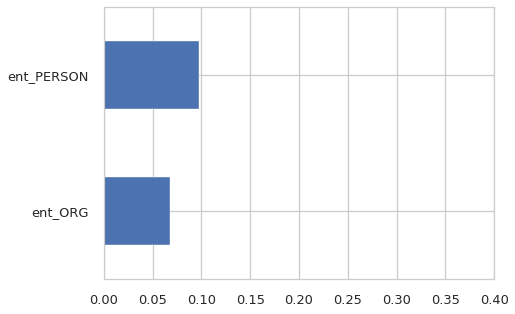

In [ ]:
(df_ethos[df_ethos.Ethos_Label == 0].describe().round(3)).loc['mean', col_ent].sort_values().plot(kind = 'barh', 
                                                                                             figsize = (7, 5))
plt.xlim(0, 0.4)
plt.show()

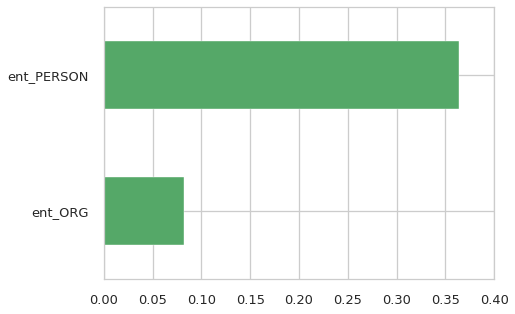

In [ ]:
(df_ethos[df_ethos.Ethos_Label == 1].describe().round(4)).loc['mean', col_ent].sort_values().plot(kind = 'barh', 
                                                                                             figsize = (7, 5), color = 'g')
plt.xlim(0, 0.4)
plt.show()

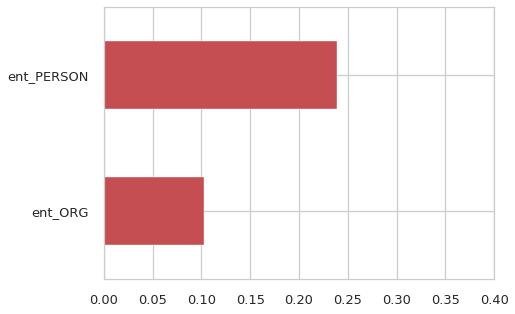

In [ ]:
(df_ethos[df_ethos.Ethos_Label == 2].describe().round(4)).loc['mean', col_ent].sort_values().plot(kind = 'barh', 
                                                                                             figsize = (7, 5), color = 'r')
plt.xlim(0, 0.4)
plt.show()

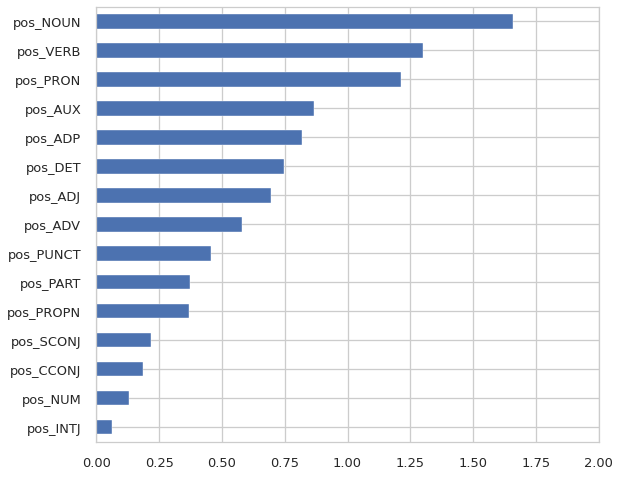

In [ ]:
(df_ethos[df_ethos.Ethos_Label == 0].describe().round(4) ).loc['mean', col_pos].sort_values().plot(kind = 'barh', 
                                                                                             figsize = (9, 8))
plt.xlim(0, 2)
plt.show()

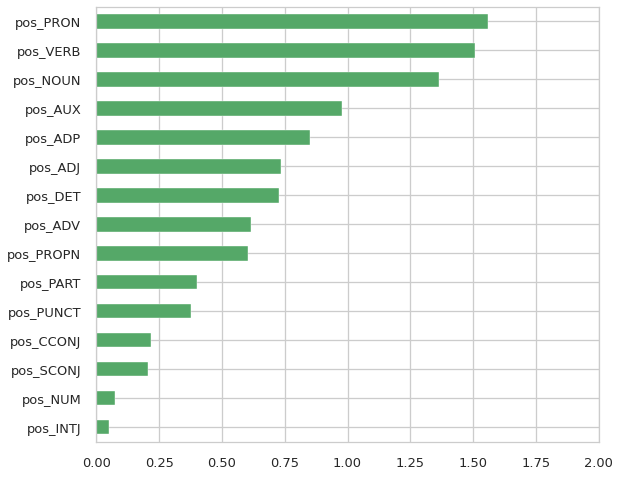

In [ ]:
(df_ethos[df_ethos.Ethos_Label == 1].describe().round(4) ).loc['mean', col_pos].sort_values().plot(kind = 'barh', 
                                                                                             figsize = (9, 8), color = 'g')
plt.xlim(0, 2)
plt.show()

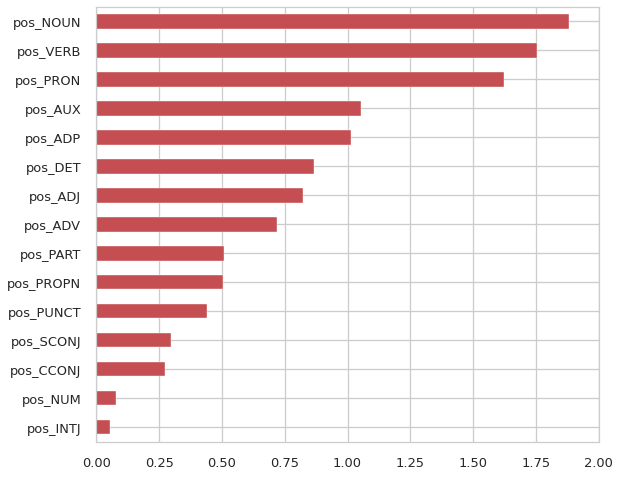

In [ ]:
(df_ethos[df_ethos.Ethos_Label == 2].describe().round(4) ).loc['mean', col_pos].sort_values().plot(kind = 'barh', 
                                                                                             figsize = (9, 8), color = 'r')
plt.xlim(0, 2)
plt.show()# .sort_values()

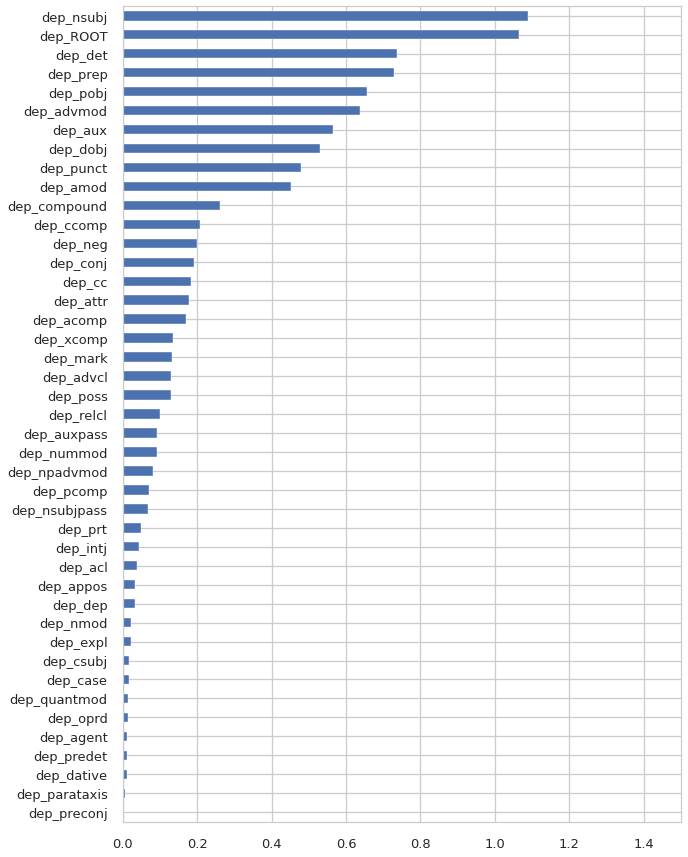

In [ ]:
(df_ethos[df_ethos.Ethos_Label == 0].describe().round(4) ).loc['mean', col_dep].sort_values().plot(kind = 'barh', 
                                                                                             figsize = (10, 15))
plt.xlim(0, 1.5)
plt.show()

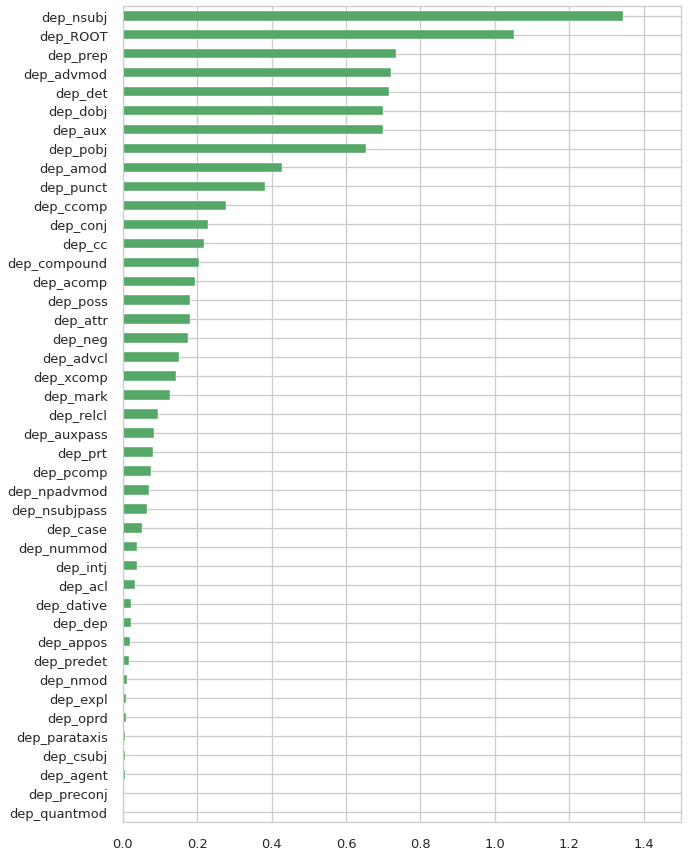

In [ ]:
(df_ethos[df_ethos.Ethos_Label == 1].describe().round(4) ).loc['mean', col_dep].sort_values().plot(kind = 'barh', 
                                                                                             figsize = (10, 15), color = 'g')
plt.xlim(0, 1.5)
plt.show()

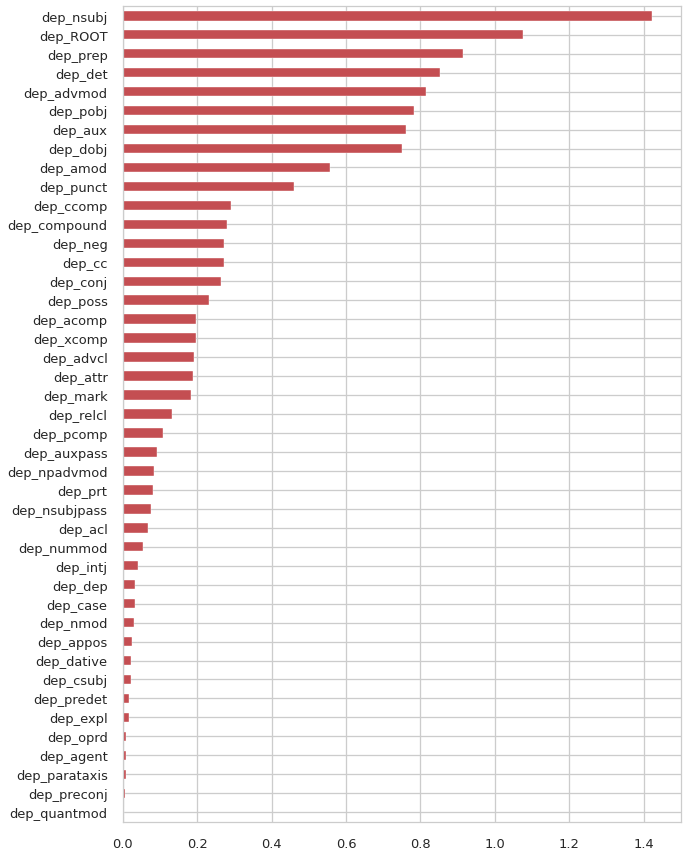

In [ ]:
(df_ethos[df_ethos.Ethos_Label == 2].describe().round(4) ).loc['mean', col_dep].sort_values().plot(kind = 'barh', 
                                                                                             figsize = (10, 15), color = 'r')
plt.xlim(0, 1.5)
plt.show()

In [ ]:
df_ethos[df_ethos.Ethos_Label == 1].describe().round(3)

,Ethos_Label,dep_intj,dep_nsubj,dep_ROOT,dep_dobj,dep_ccomp,dep_acomp,dep_advcl,dep_det,dep_relcl,dep_compound,dep_attr,dep_punct,dep_prep,dep_pobj,dep_aux,dep_prt,dep_advmod,dep_cc,dep_conj,dep_amod,dep_expl,dep_nummod,dep_poss,dep_neg,dep_mark,dep_auxpass,dep_pcomp,dep_npadvmod,dep_xcomp,dep_appos,dep_acl,dep_agent,dep_predet,dep_dep,dep_oprd,dep_csubj,dep_case,dep_dative,dep_nmod,dep_nsubjpass,dep_quantmod,dep_csubjpass,dep_parataxis,dep_preconj,dep_meta,pos_INTJ,pos_PRON,pos_VERB,pos_AUX,pos_ADJ,pos_DET,pos_NOUN,pos_PROPN,pos_PUNCT,pos_ADP,pos_ADV,pos_CCONJ,pos_NUM,pos_PART,pos_SCONJ,pos_SPACE,pos_X,pos_SYM,ent_PERSON,ent_ORG
count,574.0,574.000,574.000,574.000,574.000,574.000,574.000,574.000,574.000,574.000,574.000,574.000,574.000,574.000,574.000,574.000,574.000,574.000,574.000,574.000,574.000,574.000,574.000,574.000,574.000,574.000,574.000,574.000,574.000,574.000,574.000,574.000,574.000,574.000,574.000,574.000,574.000,574.000,574.000,574.000,574.000,574.000,574.0,574.000,574.000,574.0,574.000,574.000,574.000,574.000,574.000,574.000,574.000,574.000,574.000,574.000,574.000,574.000,574.000,574.000,574.000,574.000,574.000,574.000,574.000,574.000
mean,1.0,0.038,1.345,1.051,0.700,0.277,0.193,0.152,0.716,0.096,0.206,0.179,0.383,0.735,0.655,0.699,0.080,0.721,0.218,0.228,0.429,0.009,0.038,0.181,0.176,0.127,0.084,0.077,0.071,0.143,0.019,0.033,0.005,0.017,0.021,0.009,0.005,0.051,0.023,0.010,0.066,0.003,0.0,0.007,0.003,0.0,0.049,1.557,1.507,0.977,0.735,0.728,1.366,0.605,0.376,0.850,0.617,0.218,0.073,0.399,0.206,0.003,0.007,0.007,0.364,0.082
std,0.0,0.226,0.872,0.249,0.741,0.549,0.437,0.396,0.813,0.317,0.508,0.423,0.872,0.949,0.854,0.800,0.272,0.993,0.525,0.571,0.695,0.093,0.201,0.412,0.408,0.373,0.283,0.285,0.258,0.393,0.137,0.189,0.072,0.131,0.143,0.093,0.072,0.219,0.149,0.102,0.249,0.083,0.0,0.083,0.059,0.0,0.253,1.293,1.228,0.893,0.900,0.831,1.360,0.855,0.871,1.044,0.909,0.525,0.274,0.652,0.468,0.059,0.083,0.083,0.577,0.293
min,1.0,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.0,0.000,0.000,0.0,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
25%,1.0,0.000,1.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.0,0.000,0.000,0.0,0.000,1.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
50%,1.0,0.000,1.000,1.000,1.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.0,0.000,0.000,0.0,0.000,1.000,1.000,1.000,1.000,1.000,1.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
75%,1.0,0.000,2.000,1.000,1.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,1.000,1.000,1.000,0.000,1.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.0,0.000,0.000,0.0,0.000,2.000,2.000,1.000,1.000,1.000,2.000,1.000,0.000,1.000,1.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,1.000,0.000
max,1.0,3.000,7.000,3.000,4.000,4.000,3.000,2.000,4.000,2.000,3.000,3.000,6.000,5.000,4.000,5.000,1.000,8.000,3.000,4.000,4.000,1.000,2.000,2.000,2.000,3.000,2.000,2.000,1.000,2.000,1.000,2.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,2.000,0.0,1.000,1.000,0.0,3.000,10.000,9.000,5.000,5.000,4.000,8.000,6.000,6.000,6.000,6.000,3.000,2.000,4.000,3.000,1.000,1.000,1.000,3.000,2.000


In [ ]:
df_ethos[df_ethos.Ethos_Label == 2].describe().round(3)

,Ethos_Label,dep_intj,dep_nsubj,dep_ROOT,dep_dobj,dep_ccomp,dep_acomp,dep_advcl,dep_det,dep_relcl,dep_compound,dep_attr,dep_punct,dep_prep,dep_pobj,dep_aux,dep_prt,dep_advmod,dep_cc,dep_conj,dep_amod,dep_expl,dep_nummod,dep_poss,dep_neg,dep_mark,dep_auxpass,dep_pcomp,dep_npadvmod,dep_xcomp,dep_appos,dep_acl,dep_agent,dep_predet,dep_dep,dep_oprd,dep_csubj,dep_case,dep_dative,dep_nmod,dep_nsubjpass,dep_quantmod,dep_csubjpass,dep_parataxis,dep_preconj,dep_meta,pos_INTJ,pos_PRON,pos_VERB,pos_AUX,pos_ADJ,pos_DET,pos_NOUN,pos_PROPN,pos_PUNCT,pos_ADP,pos_ADV,pos_CCONJ,pos_NUM,pos_PART,pos_SCONJ,pos_SPACE,pos_X,pos_SYM,ent_PERSON,ent_ORG
count,1289.0,1289.000,1289.000,1289.000,1289.000,1289.000,1289.000,1289.000,1289.000,1289.000,1289.000,1289.000,1289.000,1289.000,1289.000,1289.000,1289.000,1289.000,1289.000,1289.000,1289.000,1289.000,1289.000,1289.000,1289.000,1289.000,1289.000,1289.000,1289.000,1289.000,1289.000,1289.000,1289.000,1289.000,1289.000,1289.000,1289.000,1289.000,1289.000,1289.000,1289.000,1289.000,1289.0,1289.000,1289.000,1289.0,1289.000,1289.000,1289.000,1289.000,1289.000,1289.000,1289.000,1289.000,1289.000,1289.000,1289.000,1289.000,1289.000,1289.000,1289.000,1289.000,1289.000,1289.000,1289.000,1289.000
mean,2.0,0.042,1.422,1.075,0.750,0.291,0.198,0.192,0.853,0.131,0.280,0.189,0.460,0.914,0.784,0.763,0.082,0.815,0.272,0.263,0.556,0.016,0.054,0.230,0.272,0.182,0.092,0.108,0.084,0.196,0.025,0.067,0.009,0.018,0.034,0.009,0.021,0.034,0.023,0.029,0.074,0.002,0.0,0.009,0.005,0.0,0.055,1.621,1.754,1.053,0.823,0.866,1.881,0.506,0.442,1.016,0.718,0.273,0.077,0.508,0.296,0.006,0.018,0.011,0.239,0.102
std,0.0,0.229,1.095,0.371,0.828,0.574,0.445,0.464,1.014,0.366,0.678,0.431,1.057,1.105,0.992,0.914,0.294,1.034,0.574,0.572,0.889,0.130,0.257,0.489,0.502,0.456,0.309,0.344,0.293,0.453,0.179,0.272,0.104,0.144,0.186,0.096,0.143,0.198,0.151,0.206,0.274,0.048,0.0,0.092,0.068,0.0,0.260,1.407,1.467,0.996,1.038,1.039,1.842,0.914,1.037,1.174,0.963,0.579,0.304,0.715,0.616,0.079,0.231,0.111,0.488,0.340
min,2.0,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.0,0.000,0.000,0.0,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
25%,2.0,0.000,1.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.0,0.000,0.000,0.0,0.000,1.000,1.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
50%,2.0,0.000,1.000,1.000,1.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,1.000,1.000,1.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.0,0.000,0.000,0.0,0.000,1.000,1.000,1.000,1.000,1.000,1.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
75%,2.0,0.000,2.000,1.000,1.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,1.000,1.000,1.000,1.000,0.000,1.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.0,0.000,0.000,0.0,0.000,2.000,2.000,1.000,1.000,1.000,3.000,1.000,0.000,2.000,1.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000
max,2.0,3.000,21.000,7.000,7.000,6.000,3.000,5.000,10.000,2.000,9.000,3.000,15.000,10.000,8.000,11.000,3.000,13.000,6.000,5.000,7.000,2.000,4.000,4.000,4.000,5.000,3.000,3.000,2.000,3.000,2.000,3.000,2.000,2.000,2.000,1.000,1.000,2.000,1.000,4.000,2.000,1.000,0.0,1.000,1.000,0.0,4.000,19.000,22.000,15.000,8.000,10.000,16.000,14.000,15.000,9.000,13.000,6.000,4.000,6.000,9.000,1.000,7.000,2.000,4.000,3

In [ ]:
df_ethos[df_ethos.Ethos_Label == 0].describe().round(3)

,Ethos_Label,dep_intj,dep_nsubj,dep_ROOT,dep_dobj,dep_ccomp,dep_acomp,dep_advcl,dep_det,dep_relcl,dep_compound,dep_attr,dep_punct,dep_prep,dep_pobj,dep_aux,dep_prt,dep_advmod,dep_cc,dep_conj,dep_amod,dep_expl,dep_nummod,dep_poss,dep_neg,dep_mark,dep_auxpass,dep_pcomp,dep_npadvmod,dep_xcomp,dep_appos,dep_acl,dep_agent,dep_predet,dep_dep,dep_oprd,dep_csubj,dep_case,dep_dative,dep_nmod,dep_nsubjpass,dep_quantmod,dep_csubjpass,dep_parataxis,dep_preconj,dep_meta,pos_INTJ,pos_PRON,pos_VERB,pos_AUX,pos_ADJ,pos_DET,pos_NOUN,pos_PROPN,pos_PUNCT,pos_ADP,pos_ADV,pos_CCONJ,pos_NUM,pos_PART,pos_SCONJ,pos_SPACE,pos_X,pos_SYM,ent_PERSON,ent_ORG
count,4650.0,4650.000,4650.000,4650.000,4650.000,4650.000,4650.000,4650.000,4650.000,4650.00,4650.000,4650.000,4650.000,4650.000,4650.000,4650.000,4650.000,4650.000,4650.000,4650.000,4650.000,4650.000,4650.000,4650.000,4650.000,4650.000,4650.000,4650.00,4650.000,4650.000,4650.000,4650.000,4650.000,4650.000,4650.000,4650.000,4650.000,4650.000,4650.000,4650.000,4650.000,4650.000,4650.000,4650.000,4650.000,4650.000,4650.000,4650.000,4650.000,4650.000,4650.000,4650.000,4650.000,4650.000,4650.000,4650.000,4650.000,4650.000,4650.000,4650.000,4650.000,4650.000,4650.000,4650.000,4650.000,4650.000
mean,0.0,0.043,1.090,1.066,0.530,0.208,0.170,0.130,0.737,0.10,0.260,0.178,0.479,0.729,0.655,0.566,0.050,0.639,0.183,0.191,0.453,0.021,0.092,0.129,0.200,0.131,0.093,0.07,0.080,0.135,0.034,0.039,0.011,0.011,0.033,0.014,0.018,0.017,0.011,0.022,0.068,0.014,0.002,0.005,0.003,0.001,0.062,1.212,1.299,0.866,0.697,0.748,1.658,0.369,0.457,0.817,0.578,0.186,0.130,0.374,0.216,0.008,0.016,0.019,0.098,0.068
std,0.0,0.237,0.951,0.343,0.735,0.492,0.412,0.368,0.961,0.32,0.661,0.424,1.234,1.027,0.943,0.808,0.226,0.929,0.504,0.558,0.787,0.147,0.358,0.380,0.428,0.379,0.313,0.28,0.296,0.385,0.216,0.205,0.117,0.104,0.193,0.126,0.136,0.132,0.105,0.175,0.265,0.145,0.044,0.073,0.053,0.025,0.290,1.252,1.264,0.936,0.944,0.976,1.700,0.939,1.205,1.104,0.867,0.512,0.457,0.636,0.490,0.100,0.151,0.169,0.367,0.293
min,0.0,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.00,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.00,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
25%,0.0,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.00,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.00,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
50%,0.0,0.000,1.000,1.000,0.000,0.000,0.000,0.000,0.000,0.00,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.00,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,1.000,1.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
75%,0.0,0.000,2.000,1.000,1.000,0.000,0.000,0.000,1.000,0.00,0.000,0.000,1.000,1.000,1.000,1.000,0.000,1.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.00,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,2.000,2.000,1.000,1.000,1.000,2.000,0.000,0.000,1.000,1.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000
max,0.0,6.000,9.000,8.000,7.000,7.000,3.000,3.000,7.000,3.00,11.000,3.000,21.000,10.000,10.000,10.000,3.000,11.000,9.000,9.000,8.000,2.000,5.000,5.000,3.000,4.000,3.000,3.00,2.000,4.000,5.000,2.000,2.000,1.000,3.000,3.000,2.000,2.000,2.000,4.000,3.000,3.000,2.000,1.000,1.000,1.000,6.000,17.000,19.000,11.000,9.000,7.000,21.000,21.000,21.000,10.000,9.000,9.000,7.000,7.000,4.000,2.000,3.00

In [ ]:
df_ethos.columns

Index(['Text', 'Source', 'Target', 'Ethos_Label', 'clean_Text', 'Text_dep',
       'Text_pos', 'Text_ents', 'clean_Text_lemmatized', 'dep_intj',
       'dep_nsubj', 'dep_ROOT', 'dep_dobj', 'dep_ccomp', 'dep_acomp',
       'dep_advcl', 'dep_det', 'dep_relcl', 'dep_compound', 'dep_attr',
       'dep_punct', 'dep_prep', 'dep_pobj', 'dep_aux', 'dep_prt', 'dep_advmod',
       'dep_cc', 'dep_conj', 'dep_amod', 'dep_expl', 'dep_nummod', 'dep_poss',
       'dep_neg', 'dep_mark', 'dep_auxpass', 'dep_pcomp', 'dep_npadvmod',
       'dep_xcomp', 'dep_appos', 'dep_acl', 'dep_agent', 'dep_predet',
       'dep_dep', 'dep_oprd', 'dep_csubj', 'dep_case', 'dep_dative',
       'dep_nmod', 'dep_nsubjpass', 'dep_quantmod', 'dep_csubjpass',
       'dep_parataxis', 'dep_preconj', 'dep_meta', 'pos_INTJ', 'pos_PRON',
       'pos_VERB', 'pos_AUX', 'pos_ADJ', 'pos_DET', 'pos_NOUN', 'pos_PROPN',
       'pos_PUNCT', 'pos_ADP', 'pos_ADV', 'pos_CCONJ', 'pos_NUM', 'pos_PART',
       'pos_SCONJ', 'pos_SPACE', 'pos_X',

In [ ]:
df_ethos.Ethos_Label.value_counts()

0    4650
2    1289
1     574
Name: Ethos_Label, dtype: int64

##T-test

In [31]:
col_pos = ['pos_INTJ', 'pos_PRON', 'pos_VERB',
       'pos_AUX', 'pos_ADJ', 'pos_DET', 'pos_NOUN', 'pos_PROPN', 'pos_PUNCT',
       'pos_ADP', 'pos_ADV', 'pos_CCONJ', 'pos_NUM', 'pos_PART', 'pos_SCONJ']

col_dep = ['dep_intj', 'dep_nsubj', 'dep_ROOT', 'dep_dobj', 'dep_ccomp',
       'dep_acomp', 'dep_advcl', 'dep_det', 'dep_relcl', 'dep_compound', 'dep_attr',
       'dep_punct', 'dep_prep', 'dep_pobj', 'dep_aux', 'dep_prt', 'dep_advmod',
       'dep_cc', 'dep_conj', 'dep_amod', 'dep_expl', 'dep_nummod', 'dep_poss',
       'dep_neg', 'dep_mark', 'dep_auxpass', 'dep_pcomp', 'dep_npadvmod',
       'dep_xcomp', 'dep_appos', 'dep_acl', 'dep_agent', 'dep_predet', 
       'dep_oprd', 'dep_csubj', 'dep_case', 'dep_dative', 'dep_nmod',
       'dep_nsubjpass', 'dep_quantmod', 'dep_parataxis',
       'dep_preconj']

col_ent = ['ent_PERSON', 'ent_ORG']

In [32]:
from scipy.stats import ttest_rel, ttest_ind

In [33]:
cols_list = col_pos + col_dep + col_ent

In [ ]:
att = df_ethos[df_ethos.Ethos_Label == 2].sample(n = 300, random_state = 0)
sup = df_ethos[df_ethos.Ethos_Label == 1].sample(n = 300, random_state = 0)
neu = df_ethos[df_ethos.Ethos_Label == 0].sample(n = 300, random_state = 0)

ethos = df_ethos[df_ethos.Ethos_Label != 0].sample(n = 300, random_state = 0)
non_ethos = df_ethos[df_ethos.Ethos_Label == 0].sample(n = 300, random_state = 0)

In [34]:
att = df_ethos[df_ethos.Ethos_Label == 2]
sup = df_ethos[df_ethos.Ethos_Label == 1]
neu = df_ethos[df_ethos.Ethos_Label == 0]

ethos = df_ethos[df_ethos.Ethos_Label != 0]
non_ethos = df_ethos[df_ethos.Ethos_Label == 0]

In [44]:
ethos_ttest = pd.DataFrame(columns = ['variable', 'ttest', 'p_val', 'p_correct', 'compare_type'])
ethos_ttest

,variable,ttest,p_val,p_correct,compare_type


In [45]:
for c in cols_list:
  sample1 = ethos[c].apply(float).values
  sample2 = non_ethos[c].apply(float).values  
  t, p = ttest_ind(sample1, sample2)

  from math import sqrt
  cohens_d = (np.mean(sample1) - np.mean(sample2)) / (sqrt((np.std(sample1) ** 2 + np.std(sample2) ** 2) / 2))

  print(f'Var: {c}')
  print("D-effect: ", round(cohens_d, 2))
  if (round(p, 3) <= 0.01) and (round(cohens_d, 2) > 0.2):
    print("H0 could be rejected !!")
    print(f't: {round(t, 3)}\t p: {round(p, 3)}')
    ethos_ttest.loc[len(ethos_ttest)] = [c, round(t, 3), round(p, 3), round(p, 3), 'ethos vs non-ethos']
  print('\n')

Var: pos_INTJ
D-effect:  -0.03


Var: pos_PRON
D-effect:  0.3
H0 could be rejected !!
t: 11.029	 p: 0.0


Var: pos_VERB
D-effect:  0.28
H0 could be rejected !!
t: 10.593	 p: 0.0


Var: pos_AUX
D-effect:  0.17


Var: pos_ADJ
D-effect:  0.1


Var: pos_DET
D-effect:  0.08


Var: pos_NOUN
D-effect:  0.04


Var: pos_PROPN
D-effect:  0.18


Var: pos_PUNCT
D-effect:  -0.03


Var: pos_ADP
D-effect:  0.13


Var: pos_ADV
D-effect:  0.12


Var: pos_CCONJ
D-effect:  0.13


Var: pos_NUM
D-effect:  -0.14


Var: pos_PART
D-effect:  0.15


Var: pos_SCONJ
D-effect:  0.1


Var: dep_intj
D-effect:  -0.01


Var: dep_nsubj
D-effect:  0.31
H0 could be rejected !!
t: 11.534	 p: 0.0


Var: dep_ROOT
D-effect:  0.0


Var: dep_dobj
D-effect:  0.27
H0 could be rejected !!
t: 9.89	 p: 0.0


Var: dep_ccomp
D-effect:  0.15


Var: dep_acomp
D-effect:  0.06


Var: dep_advcl
D-effect:  0.12


Var: dep_det
D-effect:  0.08


Var: dep_relcl
D-effect:  0.06


Var: dep_compound
D-effect:  -0.01


Var: dep_attr
D-effect:  0.

In [ ]:

for c in cols_list:
  sample1 = ethos[c].apply(float).values
  sample2 = non_ethos[c].apply(float).values  
  t, p = ttest_ind(sample1, sample2)

  if round(p, 3) <= 0.01:
    print("H0 could be rejected !!")
    print(f'Var: {c},\t t-value: {round(t, 3)}, p: {round(p, 3)}\n')
    ethos_ttest.loc[len(ethos_ttest)] = [c, round(t, 3), round(p, 3), round(p, 3), 'ethos vs non-ethos']

H0 could be rejected !!
Var: pos_VERB,	 t-value: 3.054, p: 0.002

H0 could be rejected !!
Var: pos_ADJ,	 t-value: 3.493, p: 0.001

H0 could be rejected !!
Var: pos_PROPN,	 t-value: 4.653, p: 0.0

H0 could be rejected !!
Var: pos_ADP,	 t-value: 3.131, p: 0.002

H0 could be rejected !!
Var: pos_CCONJ,	 t-value: 3.636, p: 0.0

H0 could be rejected !!
Var: pos_PART,	 t-value: 5.019, p: 0.0

H0 could be rejected !!
Var: dep_acomp,	 t-value: 2.714, p: 0.007

H0 could be rejected !!
Var: dep_prep,	 t-value: 3.043, p: 0.002

H0 could be rejected !!
Var: dep_aux,	 t-value: 2.761, p: 0.006

H0 could be rejected !!
Var: dep_cc,	 t-value: 3.738, p: 0.0

H0 could be rejected !!
Var: dep_poss,	 t-value: 3.306, p: 0.001

H0 could be rejected !!
Var: dep_xcomp,	 t-value: 2.992, p: 0.003

H0 could be rejected !!
Var: dep_case,	 t-value: 3.764, p: 0.0

H0 could be rejected !!
Var: entPERSON,	 t-value: 6.563, p: 0.0



In [46]:
# attack vs neu

for c in cols_list:
  sample1 = att[c].apply(float).values
  sample2 = neu[c].apply(float).values  
  t, p = ttest_ind(sample1, sample2)

  from math import sqrt
  cohens_d = (np.mean(sample1) - np.mean(sample2)) / (sqrt((np.std(sample1) ** 2 + np.std(sample2) ** 2) / 2))

  print(f'Var: {c}')
  print("D-effect: ", round(cohens_d, 2))
  if (round(p, 3) <= 0.01) and (round(cohens_d, 2) > 0.2):
    print("H0 could be rejected !!")
    print(f't: {round(t, 3)}\t p: {round(p, 3)}')
    ethos_ttest.loc[len(ethos_ttest)] = [c, round(t, 3), round(p, 3), round(p * 3, 3), 'attack vs neutral ethos']  
  print('\n')

Var: pos_INTJ
D-effect:  -0.02


Var: pos_PRON
D-effect:  0.31
H0 could be rejected !!
t: 10.096	 p: 0.0


Var: pos_VERB
D-effect:  0.33
H0 could be rejected !!
t: 11.032	 p: 0.0


Var: pos_AUX
D-effect:  0.19


Var: pos_ADJ
D-effect:  0.13


Var: pos_DET
D-effect:  0.12


Var: pos_NOUN
D-effect:  0.13


Var: pos_PROPN
D-effect:  0.15


Var: pos_PUNCT
D-effect:  -0.01


Var: pos_ADP
D-effect:  0.17


Var: pos_ADV
D-effect:  0.15


Var: pos_CCONJ
D-effect:  0.16


Var: pos_NUM
D-effect:  -0.14


Var: pos_PART
D-effect:  0.2


Var: pos_SCONJ
D-effect:  0.14


Var: dep_intj
D-effect:  -0.0


Var: dep_nsubj
D-effect:  0.32
H0 could be rejected !!
t: 10.719	 p: 0.0


Var: dep_ROOT
D-effect:  0.03


Var: dep_dobj
D-effect:  0.28
H0 could be rejected !!
t: 9.245	 p: 0.0


Var: dep_ccomp
D-effect:  0.16


Var: dep_acomp
D-effect:  0.07


Var: dep_advcl
D-effect:  0.15


Var: dep_det
D-effect:  0.12


Var: dep_relcl
D-effect:  0.09


Var: dep_compound
D-effect:  0.03


Var: dep_attr
D-effect:  

In [ ]:
# attack vs neu

for c in cols_list:
  sample1 = att[c].apply(float).values
  sample2 = neu[c].apply(float).values  
  t, p = ttest_ind(sample1, sample2)

  if round(p * 3, 3) < 0.05:
    print("H0 could be rejected !!")
    print(f'Var: {c},\t t-value: {round(t, 3)}, p: {round(p, 3)}, p-corrected: {round(p * 3, 3)}\n')
    ethos_ttest.loc[len(ethos_ttest)] = [c, round(t, 3), round(p, 3), round(p * 3, 3), 'attack vs neutral ethos']    

H0 could be rejected !!
Var: pos_INTJ,	 t-value: -2.87, p: 0.004, p-corrected: 0.013

H0 could be rejected !!
Var: pos_PRON,	 t-value: 3.197, p: 0.001, p-corrected: 0.004

H0 could be rejected !!
Var: pos_VERB,	 t-value: 3.307, p: 0.001, p-corrected: 0.003

H0 could be rejected !!
Var: pos_AUX,	 t-value: 2.857, p: 0.004, p-corrected: 0.013

H0 could be rejected !!
Var: pos_ADJ,	 t-value: 3.13, p: 0.002, p-corrected: 0.006

H0 could be rejected !!
Var: pos_PROPN,	 t-value: 3.429, p: 0.001, p-corrected: 0.002

H0 could be rejected !!
Var: pos_ADP,	 t-value: 3.653, p: 0.0, p-corrected: 0.001

H0 could be rejected !!
Var: pos_CCONJ,	 t-value: 3.373, p: 0.001, p-corrected: 0.002

H0 could be rejected !!
Var: pos_PART,	 t-value: 3.844, p: 0.0, p-corrected: 0.0

H0 could be rejected !!
Var: dep_nsubj,	 t-value: 3.507, p: 0.0, p-corrected: 0.001

H0 could be rejected !!
Var: dep_prep,	 t-value: 3.411, p: 0.001, p-corrected: 0.002

H0 could be rejected !!
Var: dep_pobj,	 t-value: 2.643, p: 0.00

In [47]:
for c in cols_list:
  sample1 = sup[c].apply(float).values
  sample2 = neu[c].apply(float).values  
  t, p = ttest_ind(sample1, sample2)

  from math import sqrt
  cohens_d = (np.mean(sample1) - np.mean(sample2)) / (sqrt((np.std(sample1) ** 2 + np.std(sample2) ** 2) / 2))

  print(f'Var: {c}')
  print("D-effect: ", round(cohens_d, 2))
  if (round(p, 3) <= 0.01) and (round(cohens_d, 2) > 0.2):
    print("H0 could be rejected !!")
    print(f't: {round(t, 3)}\t p: {round(p, 3)}')
    ethos_ttest.loc[len(ethos_ttest)] = [c, round(t, 3), round(p, 3), round(p * 3, 3), 'support vs neutral ethos']        
  print('\n')

Var: pos_INTJ
D-effect:  -0.05


Var: pos_PRON
D-effect:  0.27
H0 could be rejected !!
t: 6.21	 p: 0.0


Var: pos_VERB
D-effect:  0.17


Var: pos_AUX
D-effect:  0.12


Var: pos_ADJ
D-effect:  0.04


Var: pos_DET
D-effect:  -0.02


Var: pos_NOUN
D-effect:  -0.19


Var: pos_PROPN
D-effect:  0.26
H0 could be rejected !!
t: 5.71	 p: 0.0


Var: pos_PUNCT
D-effect:  -0.08


Var: pos_ADP
D-effect:  0.03


Var: pos_ADV
D-effect:  0.04


Var: pos_CCONJ
D-effect:  0.06


Var: pos_NUM
D-effect:  -0.15


Var: pos_PART
D-effect:  0.04


Var: pos_SCONJ
D-effect:  -0.02


Var: dep_intj
D-effect:  -0.02


Var: dep_nsubj
D-effect:  0.28
H0 could be rejected !!
t: 6.113	 p: 0.0


Var: dep_ROOT
D-effect:  -0.05


Var: dep_dobj
D-effect:  0.23
H0 could be rejected !!
t: 5.23	 p: 0.0


Var: dep_ccomp
D-effect:  0.13


Var: dep_acomp
D-effect:  0.06


Var: dep_advcl
D-effect:  0.06


Var: dep_det
D-effect:  -0.02


Var: dep_relcl
D-effect:  -0.01


Var: dep_compound
D-effect:  -0.09


Var: dep_attr
D-effect

In [ ]:
# support vs neu

for c in cols_list:
  sample1 = sup[c].apply(float).values
  sample2 = neu[c].apply(float).values  
  t, p = ttest_ind(sample1, sample2)

  if round(p * 3, 3) < 0.05:
    print("H0 could be rejected !!")
    print(f'Var: {c},\t t-value: {round(t, 3)}, p: {round(p, 3)}, p-corrected: {round(p * 3, 3)}\n')
    ethos_ttest.loc[len(ethos_ttest)] = [c, round(t, 3), round(p, 3), round(p * 3, 3), 'support vs neutral ethos']        

H0 could be rejected !!
Var: pos_PRON,	 t-value: 3.152, p: 0.002, p-corrected: 0.005

H0 could be rejected !!
Var: pos_VERB,	 t-value: 2.416, p: 0.016, p-corrected: 0.048

H0 could be rejected !!
Var: pos_PROPN,	 t-value: 4.983, p: 0.0, p-corrected: 0.0

H0 could be rejected !!
Var: pos_ADP,	 t-value: 2.671, p: 0.008, p-corrected: 0.023

H0 could be rejected !!
Var: pos_CCONJ,	 t-value: 2.636, p: 0.009, p-corrected: 0.026

H0 could be rejected !!
Var: dep_nsubj,	 t-value: 3.54, p: 0.0, p-corrected: 0.001

H0 could be rejected !!
Var: dep_ccomp,	 t-value: 2.453, p: 0.014, p-corrected: 0.043

H0 could be rejected !!
Var: dep_prt,	 t-value: 2.829, p: 0.005, p-corrected: 0.014

H0 could be rejected !!
Var: dep_cc,	 t-value: 2.636, p: 0.009, p-corrected: 0.026

H0 could be rejected !!
Var: dep_poss,	 t-value: 2.463, p: 0.014, p-corrected: 0.042

H0 could be rejected !!
Var: dep_case,	 t-value: 4.01, p: 0.0, p-corrected: 0.0

H0 could be rejected !!
Var: entPERSON,	 t-value: 7.762, p: 0.0, p

In [48]:
for c in cols_list:
  sample1 = sup[c].apply(float).values
  sample2 = att[c].apply(float).values  
  t, p = ttest_ind(sample1, sample2)

  from math import sqrt
  cohens_d = (np.mean(sample1) - np.mean(sample2)) / (sqrt((np.std(sample1) ** 2 + np.std(sample2) ** 2) / 2))

  print(f'Var: {c}')
  print("D-effect: ", round(cohens_d, 2))
  if (round(p, 3) <= 0.01) and (round(cohens_d, 2) > 0.2):
    print("H0 could be rejected !!")
    print(f't: {round(t, 3)}\t p: {round(p, 3)}')
    ethos_ttest.loc[len(ethos_ttest)] = [c, round(t, 3), round(p, 3), round(p * 3, 3), 'support vs attack ethos']            
  print('\n')

Var: pos_INTJ
D-effect:  -0.02


Var: pos_PRON
D-effect:  -0.05


Var: pos_VERB
D-effect:  -0.18


Var: pos_AUX
D-effect:  -0.08


Var: pos_ADJ
D-effect:  -0.09


Var: pos_DET
D-effect:  -0.15


Var: pos_NOUN
D-effect:  -0.32


Var: pos_PROPN
D-effect:  0.11


Var: pos_PUNCT
D-effect:  -0.07


Var: pos_ADP
D-effect:  -0.15


Var: pos_ADV
D-effect:  -0.11


Var: pos_CCONJ
D-effect:  -0.1


Var: pos_NUM
D-effect:  -0.01


Var: pos_PART
D-effect:  -0.16


Var: pos_SCONJ
D-effect:  -0.16


Var: dep_intj
D-effect:  -0.02


Var: dep_nsubj
D-effect:  -0.08


Var: dep_ROOT
D-effect:  -0.08


Var: dep_dobj
D-effect:  -0.06


Var: dep_ccomp
D-effect:  -0.02


Var: dep_acomp
D-effect:  -0.01


Var: dep_advcl
D-effect:  -0.09


Var: dep_det
D-effect:  -0.15


Var: dep_relcl
D-effect:  -0.1


Var: dep_compound
D-effect:  -0.12


Var: dep_attr
D-effect:  -0.02


Var: dep_punct
D-effect:  -0.08


Var: dep_prep
D-effect:  -0.17


Var: dep_pobj
D-effect:  -0.14


Var: dep_aux
D-effect:  -0.07


Var: de

In [ ]:
# support vs attack

for c in cols_list:
  sample1 = sup[c].apply(float).values
  sample2 = att[c].apply(float).values  
  t, p = ttest_ind(sample1, sample2)

  if round(p * 3, 3) < 0.05:
    print("H0 could be rejected !!")
    print(f'Var: {c},\t t-value: {round(t, 3)}, p: {round(p, 3)}, p-corrected: {round(p * 3, 3)}\n')
    ethos_ttest.loc[len(ethos_ttest)] = [c, round(t, 3), round(p, 3), round(p * 3, 3), 'support vs attack ethos']            

H0 could be rejected !!
Var: pos_NOUN,	 t-value: -3.67, p: 0.0, p-corrected: 0.001

H0 could be rejected !!
Var: entPERSON,	 t-value: 3.353, p: 0.001, p-corrected: 0.003



In [50]:
ethos_ttest.values # with d effects

array([['pos_PRON', 11.029, 0.0, 0.0, 'ethos vs non-ethos'],
       ['pos_VERB', 10.593, 0.0, 0.0, 'ethos vs non-ethos'],
       ['dep_nsubj', 11.534, 0.0, 0.0, 'ethos vs non-ethos'],
       ['dep_dobj', 9.89, 0.0, 0.0, 'ethos vs non-ethos'],
       ['dep_aux', 7.789, 0.0, 0.0, 'ethos vs non-ethos'],
       ['ent_PERSON', 15.669, 0.0, 0.0, 'ethos vs non-ethos'],
       ['pos_PRON', 10.096, 0.0, 0.0, 'attack vs neutral ethos'],
       ['pos_VERB', 11.032, 0.0, 0.0, 'attack vs neutral ethos'],
       ['dep_nsubj', 10.719, 0.0, 0.0, 'attack vs neutral ethos'],
       ['dep_dobj', 9.245, 0.0, 0.0, 'attack vs neutral ethos'],
       ['dep_aux', 7.516, 0.0, 0.0, 'attack vs neutral ethos'],
       ['dep_poss', 7.95, 0.0, 0.0, 'attack vs neutral ethos'],
       ['ent_PERSON', 11.254, 0.0, 0.0, 'attack vs neutral ethos'],
       ['pos_PRON', 6.21, 0.0, 0.0, 'support vs neutral ethos'],
       ['pos_PROPN', 5.71, 0.0, 0.0, 'support vs neutral ethos'],
       ['dep_nsubj', 6.113, 0.0, 0.0, 'suppo

In [49]:
ethos_ttest.shape

(19, 5)

In [ ]:
ethos_ttest.values

array([['pos_VERB', 3.054, 0.002, 0.002, 'ethos vs non-ethos'],
       ['pos_ADJ', 3.493, 0.001, 0.001, 'ethos vs non-ethos'],
       ['pos_PROPN', 4.653, 0.0, 0.0, 'ethos vs non-ethos'],
       ['pos_ADP', 3.131, 0.002, 0.002, 'ethos vs non-ethos'],
       ['pos_CCONJ', 3.636, 0.0, 0.0, 'ethos vs non-ethos'],
       ['pos_PART', 5.019, 0.0, 0.0, 'ethos vs non-ethos'],
       ['dep_acomp', 2.714, 0.007, 0.007, 'ethos vs non-ethos'],
       ['dep_prep', 3.043, 0.002, 0.002, 'ethos vs non-ethos'],
       ['dep_aux', 2.761, 0.006, 0.006, 'ethos vs non-ethos'],
       ['dep_cc', 3.738, 0.0, 0.0, 'ethos vs non-ethos'],
       ['dep_poss', 3.306, 0.001, 0.001, 'ethos vs non-ethos'],
       ['dep_xcomp', 2.992, 0.003, 0.003, 'ethos vs non-ethos'],
       ['dep_case', 3.764, 0.0, 0.0, 'ethos vs non-ethos'],
       ['entPERSON', 6.563, 0.0, 0.0, 'ethos vs non-ethos'],
       ['pos_INTJ', -2.87, 0.004, 0.013, 'attack vs neutral ethos'],
       ['pos_PRON', 3.197, 0.001, 0.004, 'attack vs neutral

In [ ]:
ethos_ttest.columns

Index(['variable', 'ttest', 'p_val', 'p_correct', 'compare_type'], dtype='object')

In [ ]:
ethos_ttest.head()

,variable,ttest,p_val,p_correct,compare_type
0,pos_VERB,3.054,0.002,0.002,ethos vs non-ethos
1,pos_ADJ,3.493,0.001,0.001,ethos vs non-ethos
2,pos_PROPN,4.653,0.000,0.000,ethos vs non-ethos
3,pos_ADP,3.131,0.002,0.002,ethos vs non-ethos
4,pos_CCONJ,3.636,0.000,0.000,ethos vs non-ethos


In [ ]:
ethos_ttest.compare_type.unique()

array(['ethos vs non-ethos', 'attack vs neutral ethos',
       'support vs neutral ethos', 'support vs attack ethos'],
      dtype=object)

In [ ]:
ethos_ttest.variable.unique()

array(['pos_VERB', 'pos_ADJ', 'pos_PROPN', 'pos_ADP', 'pos_CCONJ',
       'pos_PART', 'dep_acomp', 'dep_prep', 'dep_aux', 'dep_cc',
       'dep_poss', 'dep_xcomp', 'dep_case', 'entPERSON', 'pos_INTJ',
       'pos_PRON', 'pos_AUX', 'dep_nsubj', 'dep_pobj', 'dep_prt',
       'dep_amod', 'dep_neg', 'dep_ccomp', 'pos_NOUN'], dtype=object)

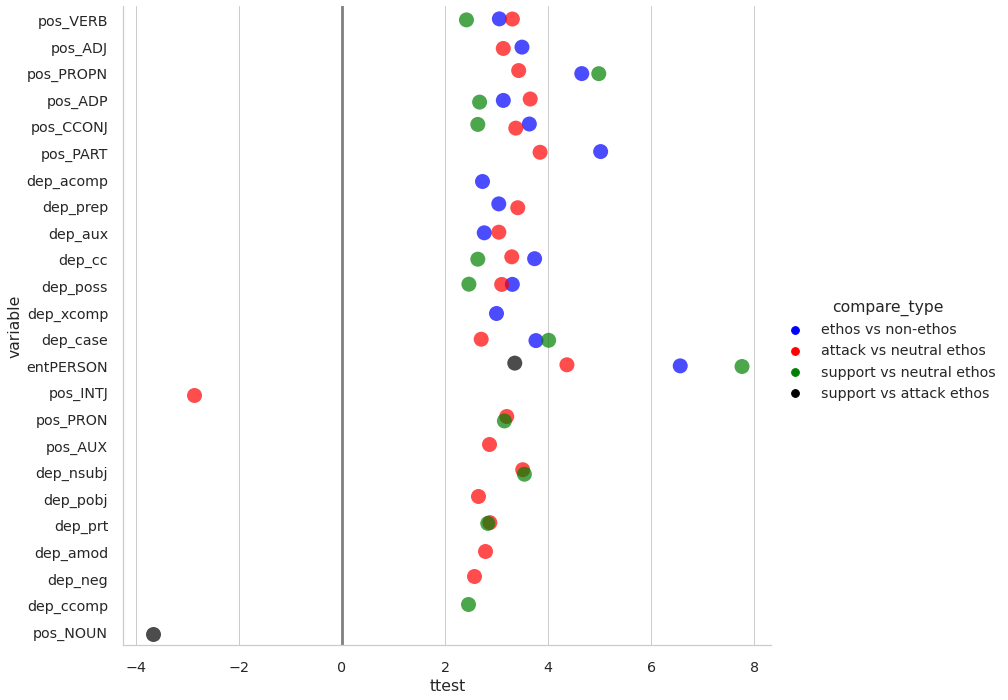

In [ ]:
sns.set(font_scale = 1.3, style = 'whitegrid')
sns.catplot(kind = 'strip', data = ethos_ttest, y = 'variable', hue = 'compare_type', x = 'ttest', 
            aspect = 1.15, height = 10, s = 15, alpha = 0.7, 
            palette = {'ethos vs non-ethos': 'blue', 'attack vs neutral ethos': 'red',
                       'support vs neutral ethos': 'green', 'support vs attack ethos': 'black'}) # join = False
plt.axvline(0, color = 'grey', linewidth = 2.8)

plt.show()

In [51]:
ethos_ttest.variable.unique()# with d

array(['pos_PRON', 'pos_VERB', 'dep_nsubj', 'dep_dobj', 'dep_aux',
       'ent_PERSON', 'dep_poss', 'pos_PROPN'], dtype=object)

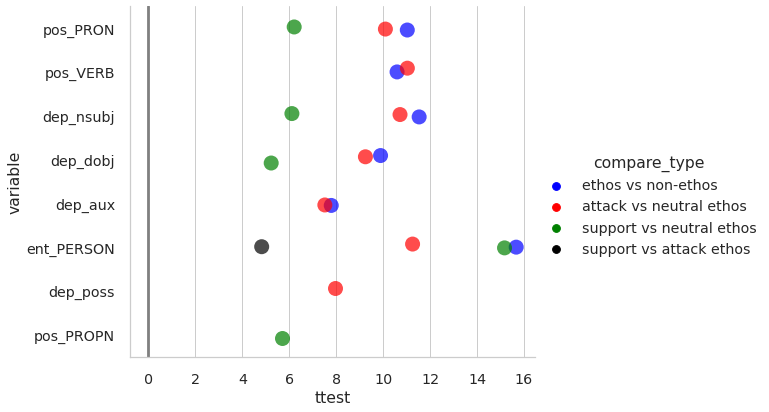

In [54]:
sns.set(font_scale = 1.3, style = 'whitegrid')
sns.catplot(kind = 'strip', data = ethos_ttest, y = 'variable', hue = 'compare_type', x = 'ttest', 
            aspect = 1.4, height = 6, s = 15, alpha = 0.7, 
            palette = {'ethos vs non-ethos': 'blue', 'attack vs neutral ethos': 'red',
                       'support vs neutral ethos': 'green', 'support vs attack ethos': 'black'}) # join = False
plt.axvline(0, color = 'grey', linewidth = 2.8)

plt.show() # with d

###permutation testing

In [57]:
ttest_cols = ['pos_VERB', 'pos_ADJ', 'pos_PROPN', 'pos_ADP', 'pos_CCONJ',
       'pos_PART', 'dep_acomp', 'dep_prep', 'dep_aux', 'dep_cc',
       'dep_poss', 'dep_xcomp', 'dep_case', 'ent_PERSON', 'pos_INTJ',
       'pos_PRON', 'pos_AUX', 'dep_nsubj', 'dep_pobj', 'dep_prt',
       'dep_amod', 'dep_neg', 'dep_ccomp', 'pos_NOUN']
len(ttest_cols)       

24

In [58]:
# https://matthew-brett.github.io/cfd2020/permutation/permutation_and_t_test.html
# see also: https://github.com/fpgdubost/bstrap   http://rasbt.github.io/mlxtend/user_guide/evaluate/permutation_test/

su = df_ethos[df_ethos.Ethos_Label == 1]
ne = df_ethos[df_ethos.Ethos_Label == 0]
at = df_ethos[df_ethos.Ethos_Label == 2]
ethos = df_ethos[df_ethos.Ethos_Label != 0]

In [ ]:
print('Number in 0:', len(df_ethos[df_ethos.Ethos_Label == 0]))
print('Number in 1:', len(df_ethos[df_ethos.Ethos_Label == 1]))
print('Number in 2:', len(df_ethos[df_ethos.Ethos_Label == 2]))
print('Number in ethos - non-ethos:', len(ethos))

Number in 0: 4650
Number in 1: 574
Number in 2: 1289
Number in ethos - non-ethos: 1863


In [59]:
observed_difference01 = np.mean(ne[ttest_cols]) - np.mean(su[ttest_cols])
observed_difference02 = np.mean(ne[ttest_cols]) - np.mean(at[ttest_cols])
observed_difference12 = np.mean(su[ttest_cols]) - np.mean(at[ttest_cols])
observed_difference012 = np.mean(ne[ttest_cols]) - np.mean(ethos[ttest_cols])

print(observed_difference01, observed_difference02, observed_difference12, observed_difference012, sep='\n\n')

pos_VERB     -0.208044
pos_ADJ      -0.038632
pos_PROPN    -0.235067
pos_ADP      -0.032755
pos_CCONJ    -0.032179
pos_PART     -0.024546
dep_acomp    -0.023487
dep_prep     -0.006374
dep_aux      -0.132800
dep_cc       -0.034759
dep_poss     -0.052367
dep_xcomp    -0.007373
dep_case     -0.033748
ent_PERSON   -0.265617
pos_INTJ      0.013155
pos_PRON     -0.345233
pos_AUX      -0.110900
dep_nsubj    -0.255055
dep_pobj      0.000432
dep_prt      -0.030462
dep_amod      0.024117
dep_neg       0.024257
dep_ccomp    -0.069046
pos_NOUN      0.291996
dtype: float64

pos_VERB     -0.455148
pos_ADJ      -0.126560
pos_PROPN    -0.136356
pos_ADP      -0.198097
pos_CCONJ    -0.087489
pos_PART     -0.133737
dep_acomp    -0.027935
dep_prep     -0.185070
dep_aux      -0.196800
dep_cc       -0.088518
dep_poss     -0.101594
dep_xcomp    -0.060017
dep_case     -0.017361
ent_PERSON   -0.140450
pos_INTJ      0.006854
pos_PRON     -0.409154
pos_AUX      -0.186302
dep_nsubj    -0.332140
dep_pobj     -0.12

pos_VERB
P-value: 0.0 
H0 could be rejected !!

Fake mean: 0.0287; obs mean 0.2080439099321869 
fake std: 0.0204; like t-test stat: 10.1826 


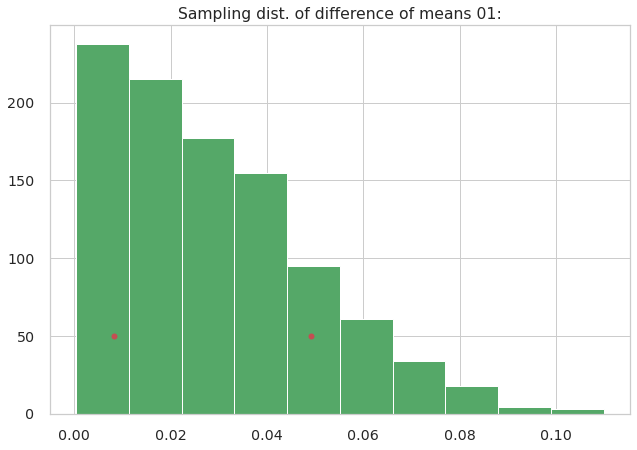


*****************************************************************


pos_ADJ
P-value: 0.127 
Fake mean: 0.0201; obs mean 0.03863249784571576 
fake std: 0.0155; like t-test stat: 2.4863 


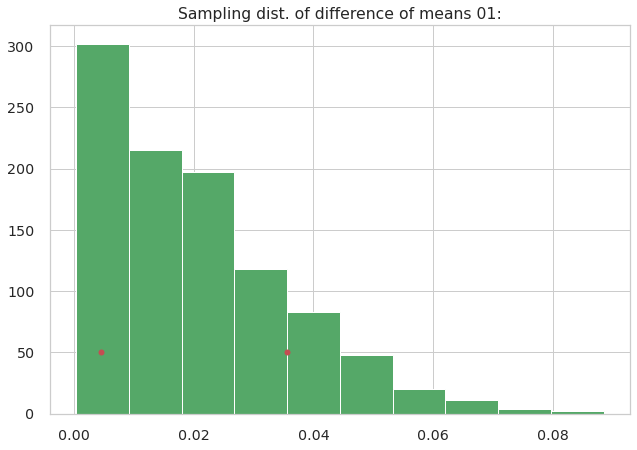


*****************************************************************


pos_PROPN
P-value: 0.0 
H0 could be rejected !!

Fake mean: 0.0212; obs mean 0.23506725113334087 
fake std: 0.016; like t-test stat: 14.6763 


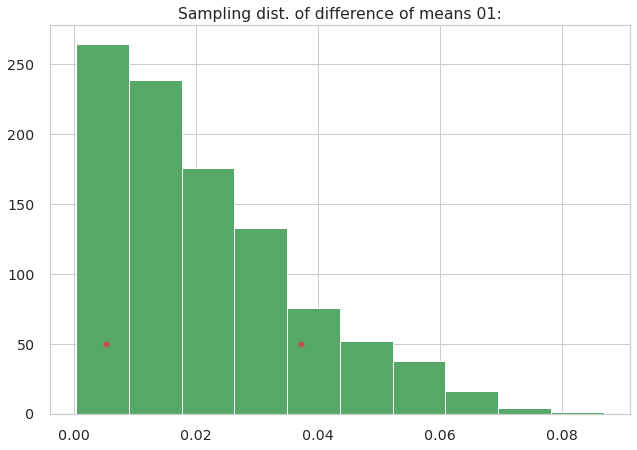


*****************************************************************


pos_ADP
P-value: 0.264 
Fake mean: 0.0238; obs mean 0.03275486118916493 
fake std: 0.0179; like t-test stat: 1.8295 


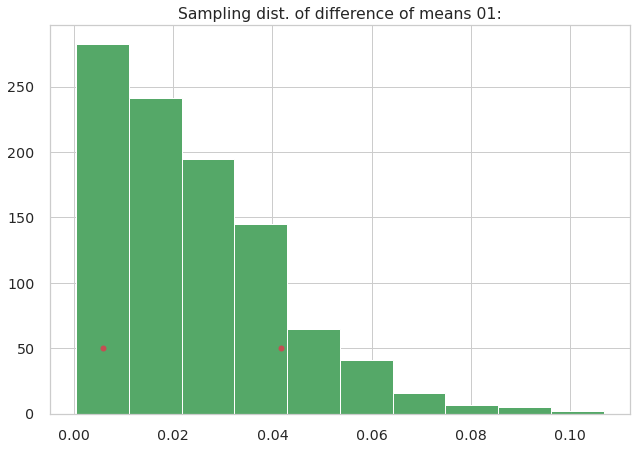


*****************************************************************


pos_CCONJ
P-value: 0.021 
H0 could be rejected !!

Fake mean: 0.0112; obs mean 0.03217863699374321 
fake std: 0.0086; like t-test stat: 3.7518 


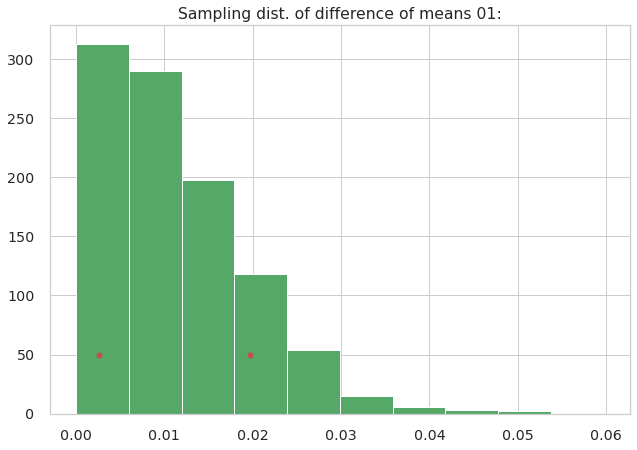


*****************************************************************


pos_PART
P-value: 0.149 
Fake mean: 0.0139; obs mean 0.024546101682214994 
fake std: 0.0111; like t-test stat: 2.2115 


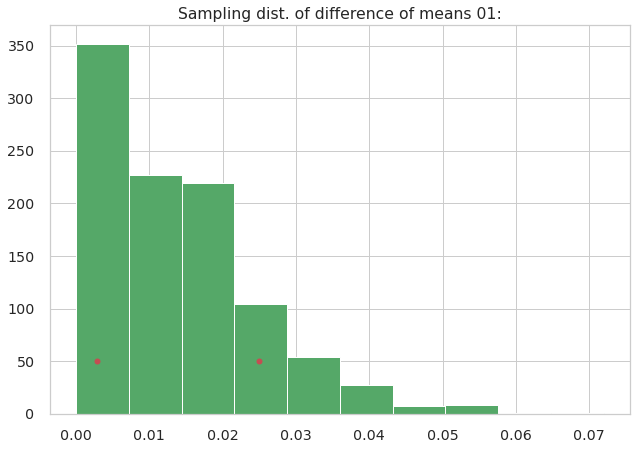


*****************************************************************


dep_acomp
P-value: 0.045 
Fake mean: 0.0093; obs mean 0.023487317822486975 
fake std: 0.0071; like t-test stat: 3.3049 


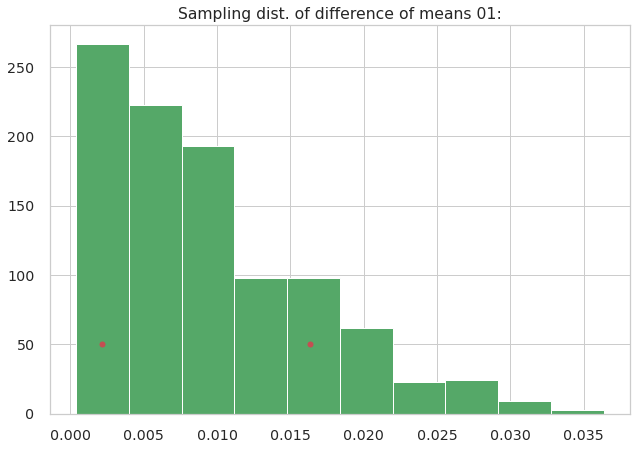


*****************************************************************


dep_prep
P-value: 0.841 
Fake mean: 0.0237; obs mean 0.0063744333295867595 
fake std: 0.0176; like t-test stat: 0.3629 


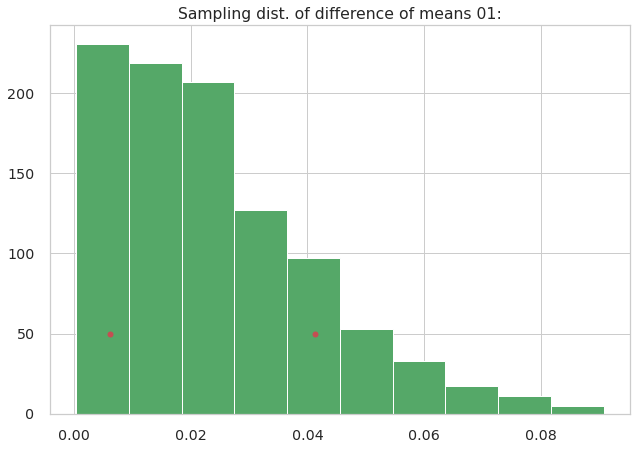


*****************************************************************


dep_aux
P-value: 0.0 
H0 could be rejected !!

Fake mean: 0.0183; obs mean 0.1327998201641003 
fake std: 0.0138; like t-test stat: 9.6328 


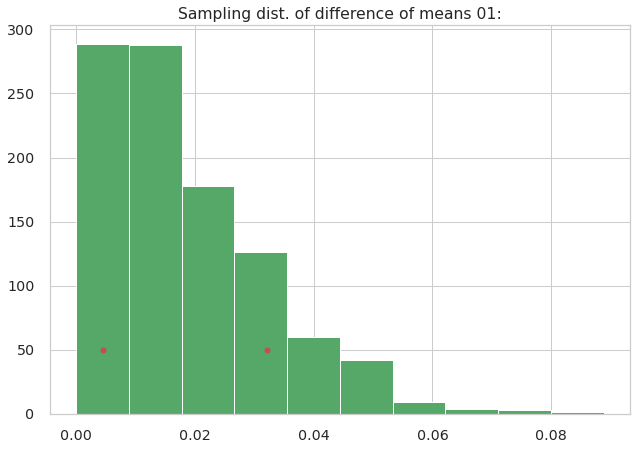


*****************************************************************


dep_cc
P-value: 0.009 
H0 could be rejected !!

Fake mean: 0.011; obs mean 0.034759282155033516 
fake std: 0.0083; like t-test stat: 4.1837 


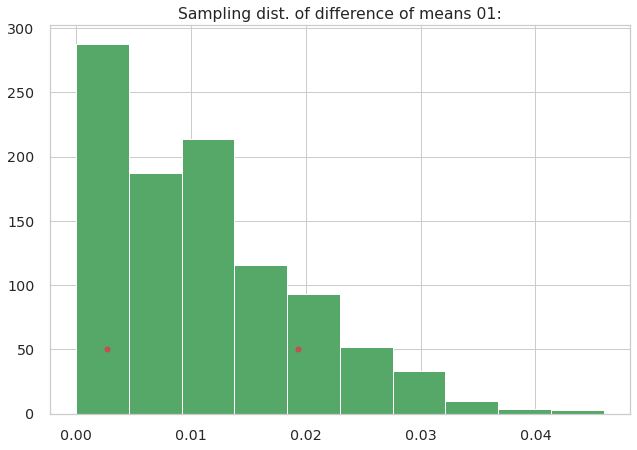


*****************************************************************


dep_poss
P-value: 0.0 
H0 could be rejected !!

Fake mean: 0.0085; obs mean 0.05236746468847178 
fake std: 0.0064; like t-test stat: 8.2117 


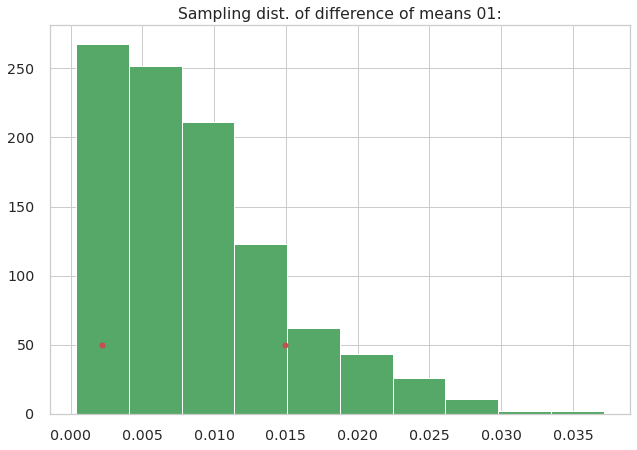


*****************************************************************


dep_xcomp
P-value: 0.498 
Fake mean: 0.0084; obs mean 0.007373271889400901 
fake std: 0.0063; like t-test stat: 1.1663 


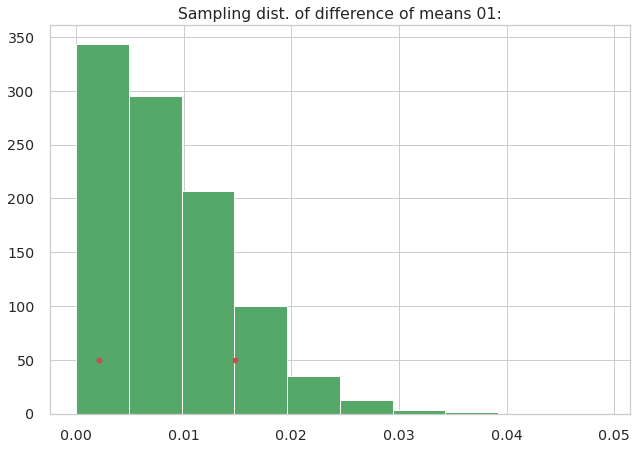


*****************************************************************


dep_case
P-value: 0.0 
H0 could be rejected !!

Fake mean: 0.0032; obs mean 0.0337484545352366 
fake std: 0.0024; like t-test stat: 14.3288 


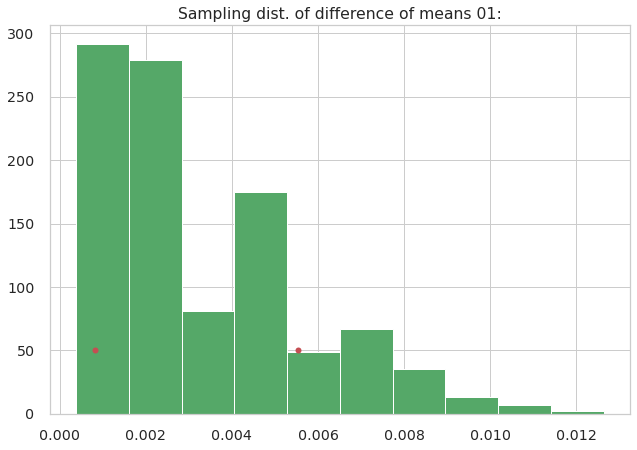


*****************************************************************


ent_PERSON
P-value: 0.0 
H0 could be rejected !!

Fake mean: 0.0092; obs mean 0.26561687460192573 
fake std: 0.0069; like t-test stat: 38.3025 


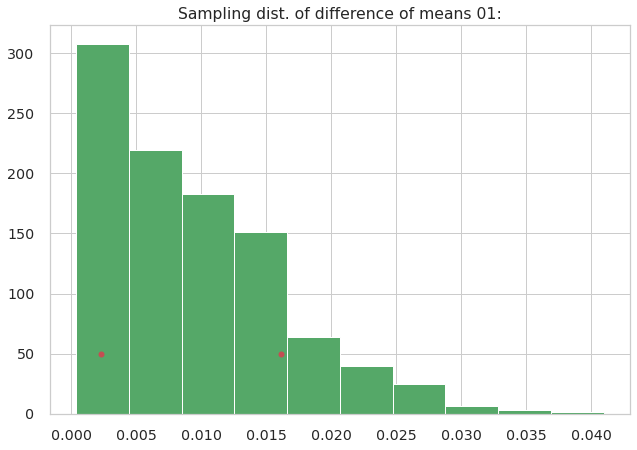


*****************************************************************


pos_INTJ
P-value: 0.088 
Fake mean: 0.0064; obs mean 0.013154996066089691 
fake std: 0.0048; like t-test stat: 2.7626 


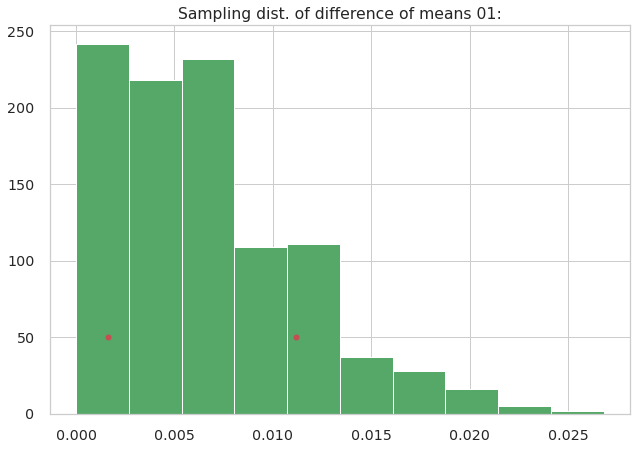


*****************************************************************


pos_PRON
P-value: 0.0 
H0 could be rejected !!

Fake mean: 0.0283; obs mean 0.3452332246824774 
fake std: 0.021; like t-test stat: 16.423 


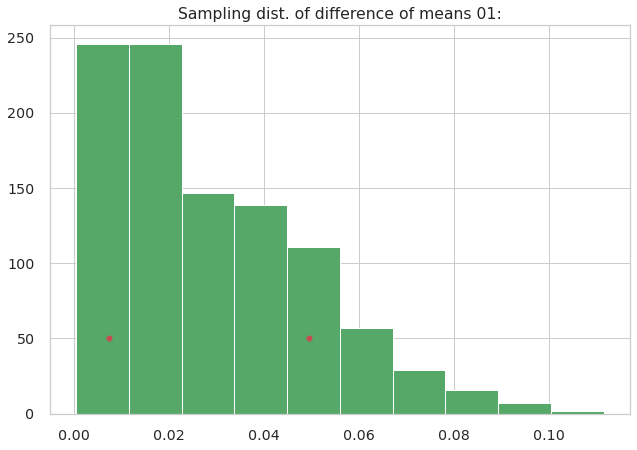


*****************************************************************


pos_AUX
P-value: 0.0 
H0 could be rejected !!

Fake mean: 0.0205; obs mean 0.11090030347308077 
fake std: 0.0152; like t-test stat: 7.3151 


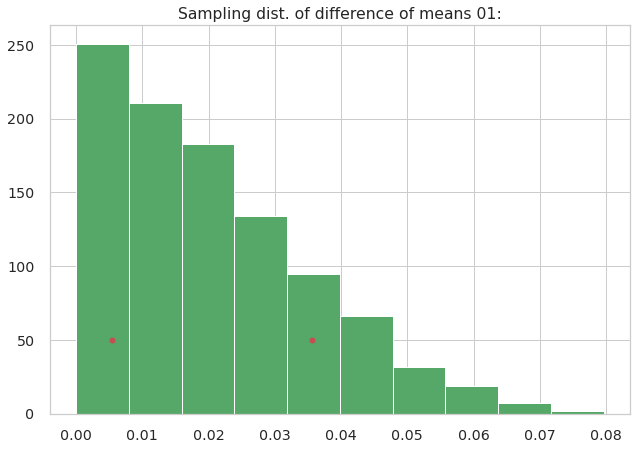


*****************************************************************


dep_nsubj
P-value: 0.0 
H0 could be rejected !!

Fake mean: 0.0215; obs mean 0.25505526207335816 
fake std: 0.0151; like t-test stat: 16.8733 


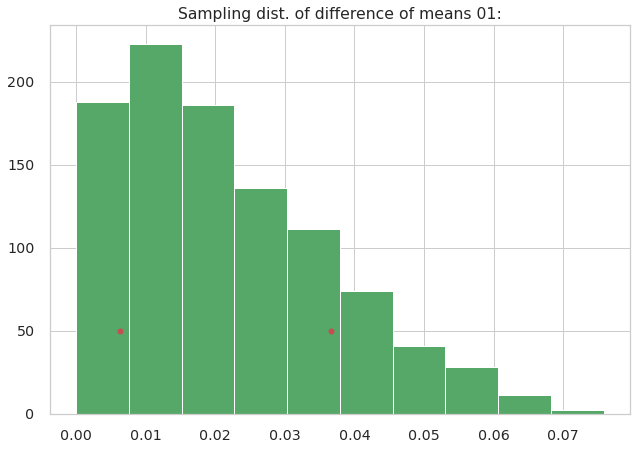


*****************************************************************


dep_pobj
P-value: 0.992 
Fake mean: 0.0212; obs mean 0.0004316061593796494 
fake std: 0.0155; like t-test stat: 0.0278 


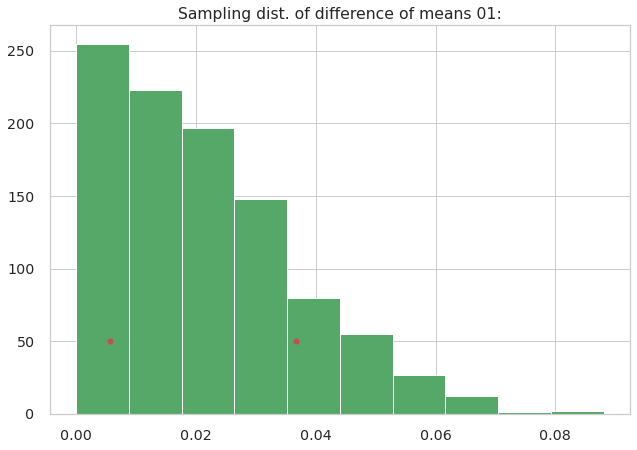


*****************************************************************


dep_prt
P-value: 0.0 
H0 could be rejected !!

Fake mean: 0.005; obs mean 0.030461953467460938 
fake std: 0.0038; like t-test stat: 7.9998 


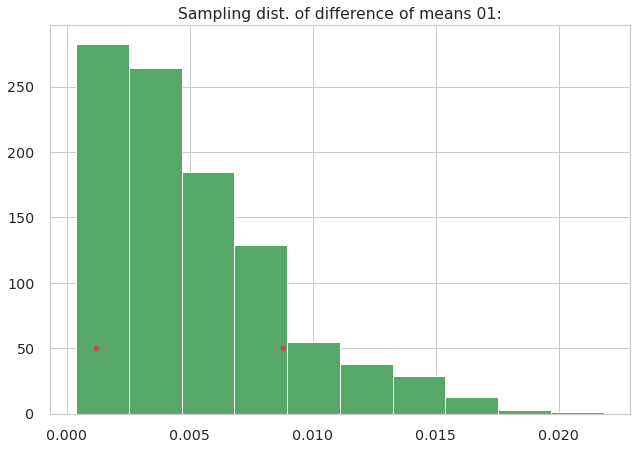


*****************************************************************


dep_amod
P-value: 0.257 
Fake mean: 0.0166; obs mean 0.024116743471582214 
fake std: 0.0128; like t-test stat: 1.8801 


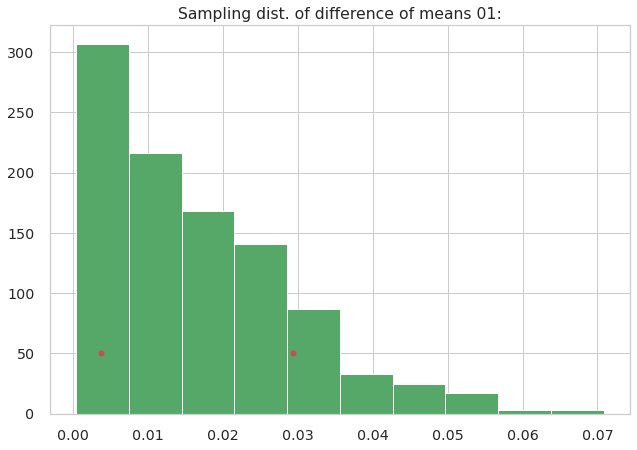


*****************************************************************


dep_neg
P-value: 0.045 
Fake mean: 0.0093; obs mean 0.024256865610130768 
fake std: 0.0073; like t-test stat: 3.3192 


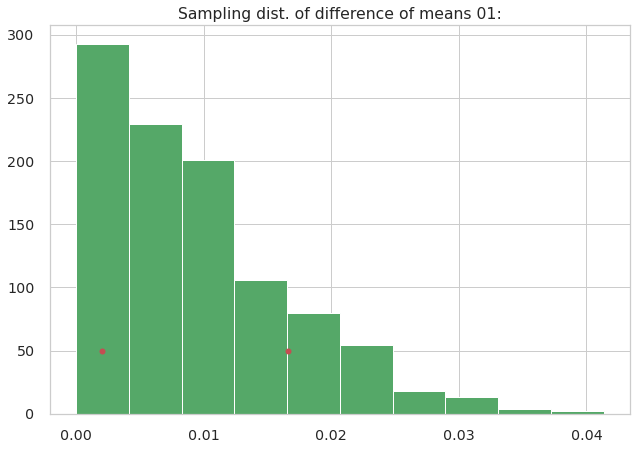


*****************************************************************


dep_ccomp
P-value: 0.0 
H0 could be rejected !!

Fake mean: 0.0106; obs mean 0.06904649507324567 
fake std: 0.008; like t-test stat: 8.6762 


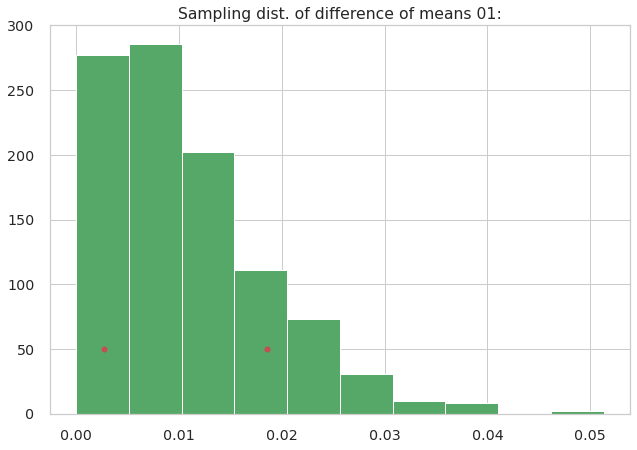


*****************************************************************


pos_NOUN
P-value: 0.0 
H0 could be rejected !!

Fake mean: 0.0367; obs mean 0.29199580382900603 
fake std: 0.0288; like t-test stat: 10.1375 


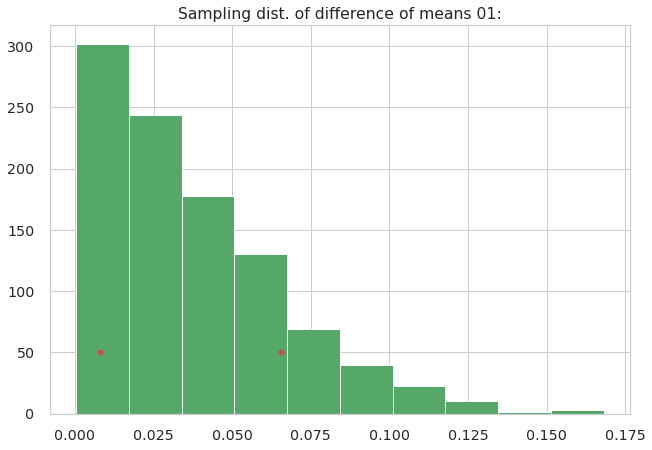


*****************************************************************




In [75]:
# 01
ttest_cols01 = pd.DataFrame(columns = ['var', 't_stat'])

for t in ttest_cols:
  pooled = np.append(ne[t], su[t])
  n_iters = 1000
  fake_differences = np.zeros(n_iters)
  observed_difference01 = np.abs(np.mean(ne[t]) - np.mean(su[t]))
  for i in np.arange(n_iters):
      shuffled = np.random.permutation(pooled)
      tres = np.floor(shuffled.shape[0] / 2)
      fake_differences[i] = np.abs(np.mean(shuffled[:int(tres)]) - np.mean(shuffled[int(tres):]))
  print(t)
  p_val = np.count_nonzero(fake_differences >= observed_difference01)/ n_iters
  #p_val = 1 - permutation_p
  fake_mean = np.mean(fake_differences)
  sampling_sd = np.std(fake_differences)
  like_t = observed_difference01 / sampling_sd # the variable name like_t. This number is rather like the famous t statistic.

  print(f'P-value: {round(p_val, 5)} ')
  if round(p_val, 3) *2 <= 0.05:
    print('H0 could be rejected !!\n')
    ttest_cols01.loc[len(ttest_cols01)] = [str(t), round(like_t, 3)]

  plt.hist(fake_differences, color = 'g')

  print(f'Fake mean: {round(fake_mean, 4)}; obs mean {observed_difference01} \nfake std: {round(sampling_sd, 4)}; like t-test stat: {round(like_t, 4)} ')
  # Red dot just above x-axis at +/- one standard deviation.
  plt.plot([fake_mean - sampling_sd, fake_mean + sampling_sd], [50, 50], 'or')
  plt.title('Sampling dist. of difference of means 01:')
  plt.show()
  print('\n*****************************************************************\n\n')

In [76]:
ttest_cols01.sort_values(by = 't_stat')

,var,t_stat
2,pos_CCONJ,3.752
4,dep_cc,4.184
9,pos_AUX,7.315
11,dep_prt,8.000
5,dep_poss,8.212
12,dep_ccomp,8.676
3,dep_aux,9.633
13,pos_NOUN,10.138
0,pos_VERB,10.183
6,dep_case,14.329


pos_VERB
P-value: 0.0 
H0 could be rejected !!

Fake mean: 0.0274; obs mean 0.45514819356507097 
fake std: 0.0217; like t-test stat: 20.9659 


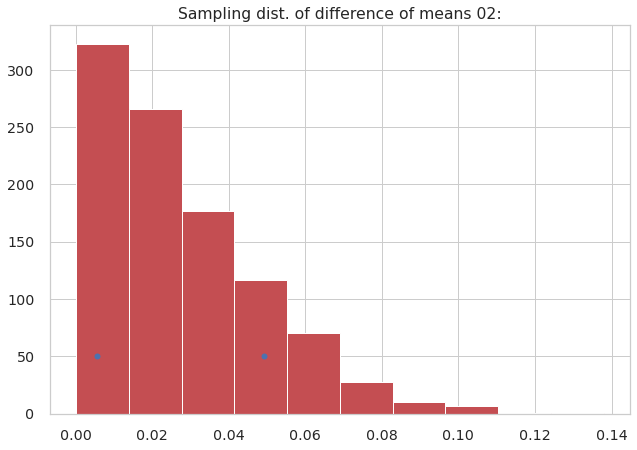


*****************************************************************


pos_ADJ
P-value: 0.0 
H0 could be rejected !!

Fake mean: 0.0206; obs mean 0.12655955687913445 
fake std: 0.0161; like t-test stat: 7.8482 


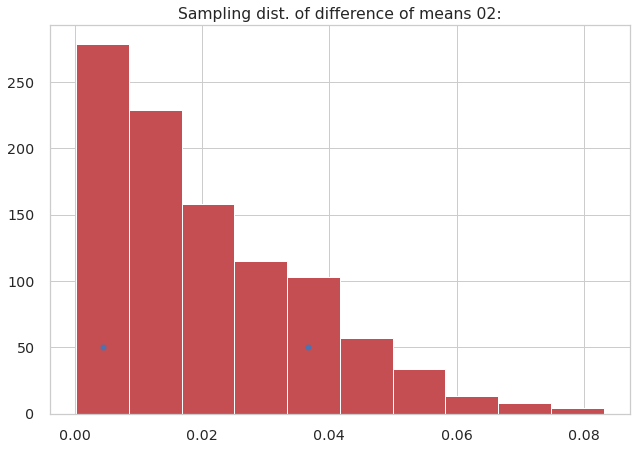


*****************************************************************


pos_PROPN
P-value: 0.0 
H0 could be rejected !!

Fake mean: 0.02; obs mean 0.13635609833412582 
fake std: 0.0145; like t-test stat: 9.3814 


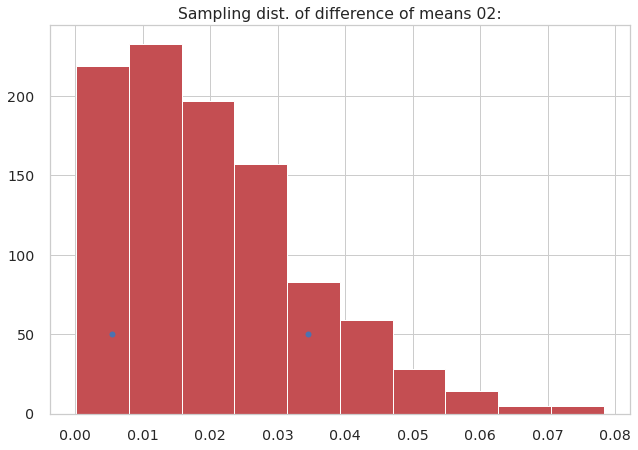


*****************************************************************


pos_ADP
P-value: 0.0 
H0 could be rejected !!

Fake mean: 0.023; obs mean 0.1980965489626867 
fake std: 0.018; like t-test stat: 10.9857 


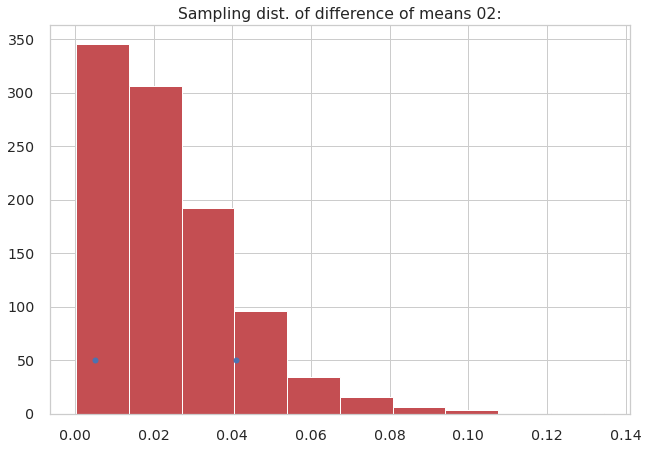


*****************************************************************


pos_CCONJ
P-value: 0.0 
H0 could be rejected !!

Fake mean: 0.0112; obs mean 0.08748850905511482 
fake std: 0.0085; like t-test stat: 10.3482 


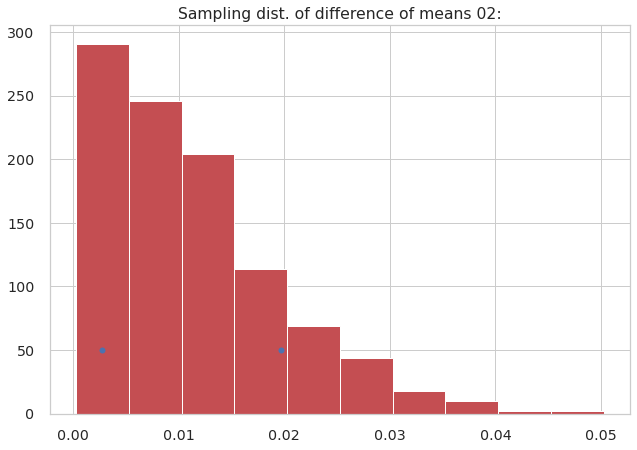


*****************************************************************


pos_PART
P-value: 0.0 
H0 could be rejected !!

Fake mean: 0.0142; obs mean 0.13373724734519554 
fake std: 0.0107; like t-test stat: 12.5556 


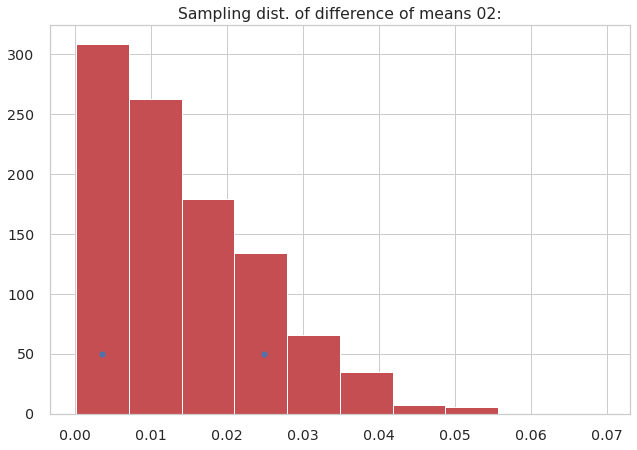


*****************************************************************


dep_acomp
P-value: 0.013 
H0 could be rejected !!

Fake mean: 0.0087; obs mean 0.027935300349524933 
fake std: 0.0065; like t-test stat: 4.2939 


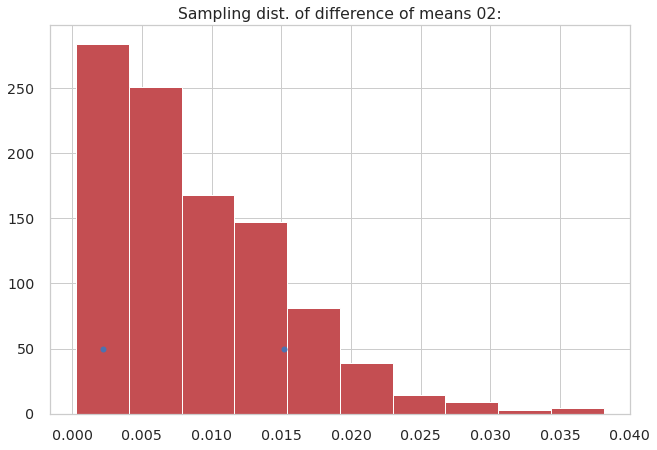


*****************************************************************


dep_prep
P-value: 0.0 
H0 could be rejected !!

Fake mean: 0.0218; obs mean 0.18506952960117462 
fake std: 0.0167; like t-test stat: 11.1118 


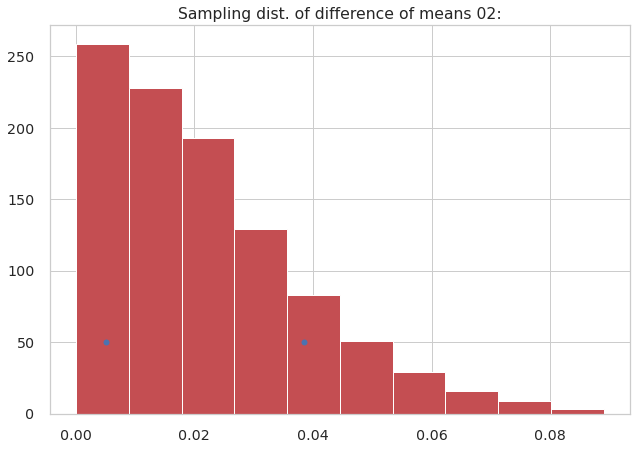


*****************************************************************


dep_aux
P-value: 0.0 
H0 could be rejected !!

Fake mean: 0.0177; obs mean 0.1968002202257314 
fake std: 0.0135; like t-test stat: 14.5537 


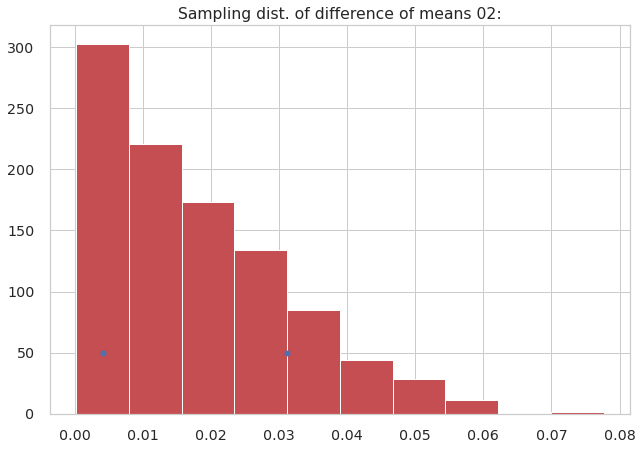


*****************************************************************


dep_cc
P-value: 0.0 
H0 could be rejected !!

Fake mean: 0.0106; obs mean 0.0885175638362655 
fake std: 0.0078; like t-test stat: 11.3088 


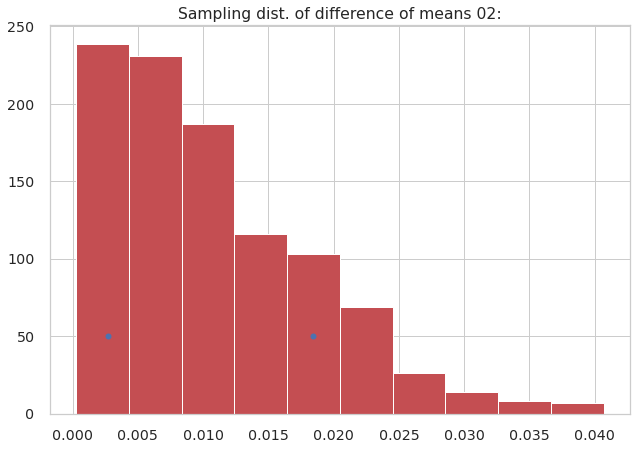


*****************************************************************


dep_poss
P-value: 0.0 
H0 could be rejected !!

Fake mean: 0.0085; obs mean 0.10159396714966173 
fake std: 0.0063; like t-test stat: 16.1277 


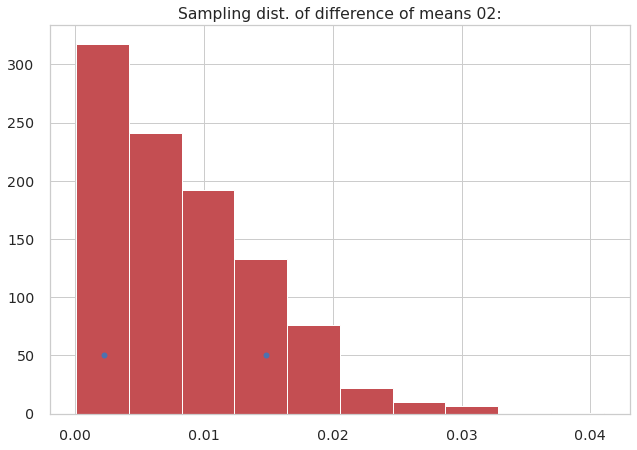


*****************************************************************


dep_xcomp
P-value: 0.0 
H0 could be rejected !!

Fake mean: 0.0084; obs mean 0.060016516929853075 
fake std: 0.006; like t-test stat: 9.9635 


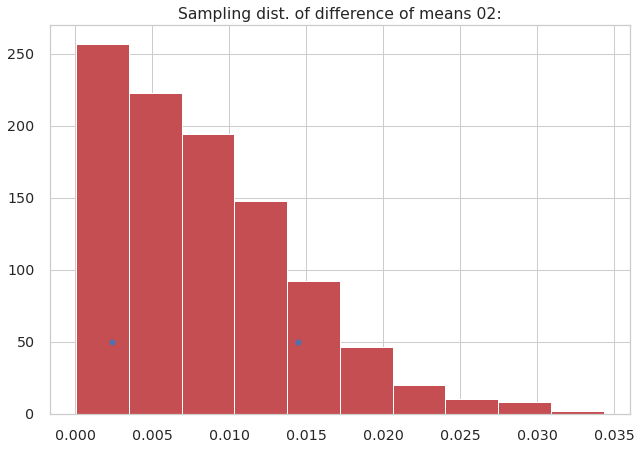


*****************************************************************


dep_case
P-value: 0.0 
H0 could be rejected !!

Fake mean: 0.0031; obs mean 0.01736079481468505 
fake std: 0.0024; like t-test stat: 7.133 


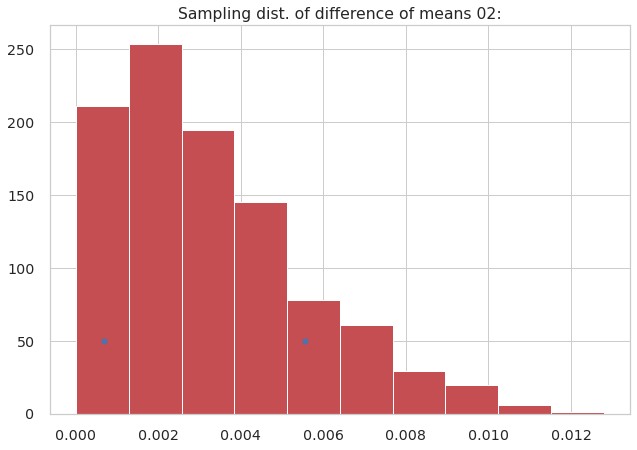


*****************************************************************


ent_PERSON
P-value: 0.0 
H0 could be rejected !!

Fake mean: 0.0085; obs mean 0.14045029488559108 
fake std: 0.0064; like t-test stat: 21.9142 


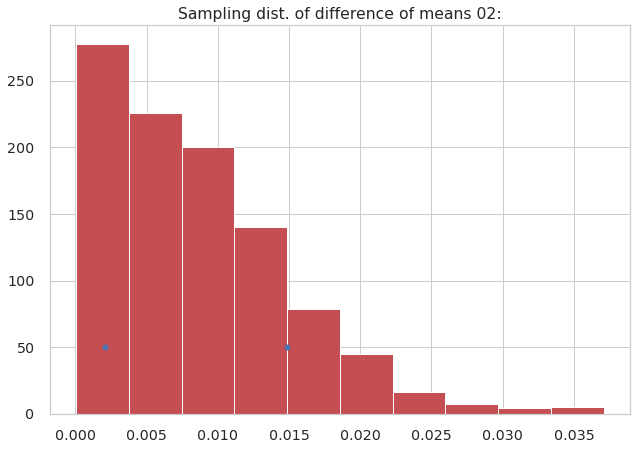


*****************************************************************


pos_INTJ
P-value: 0.366 
Fake mean: 0.0058; obs mean 0.00685402537601041 
fake std: 0.0044; like t-test stat: 1.5752 


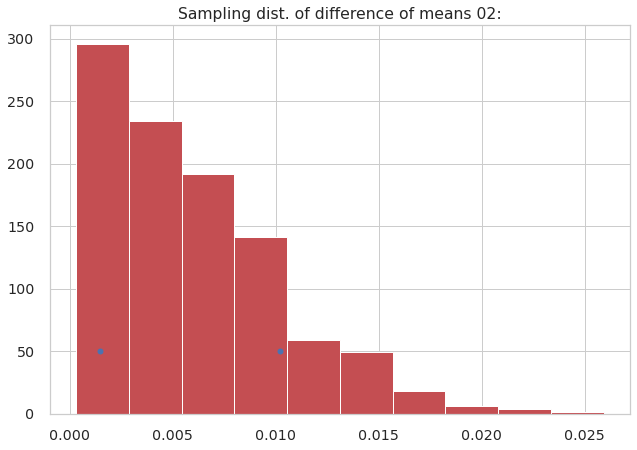


*****************************************************************


pos_PRON
P-value: 0.0 
H0 could be rejected !!

Fake mean: 0.0275; obs mean 0.409153882729798 
fake std: 0.0203; like t-test stat: 20.1291 


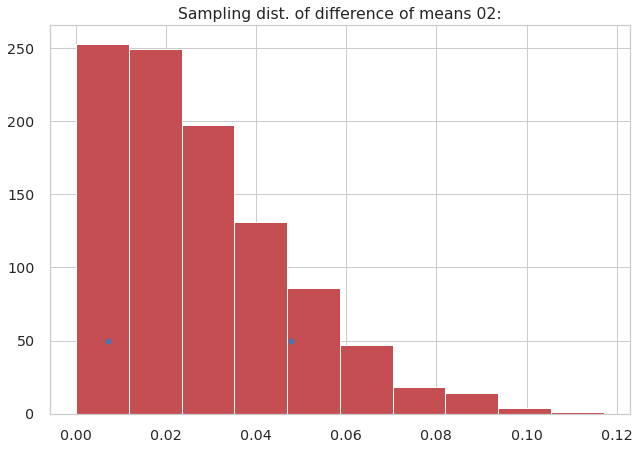


*****************************************************************


pos_AUX
P-value: 0.0 
H0 could be rejected !!

Fake mean: 0.0195; obs mean 0.18630246002152195 
fake std: 0.0149; like t-test stat: 12.4874 


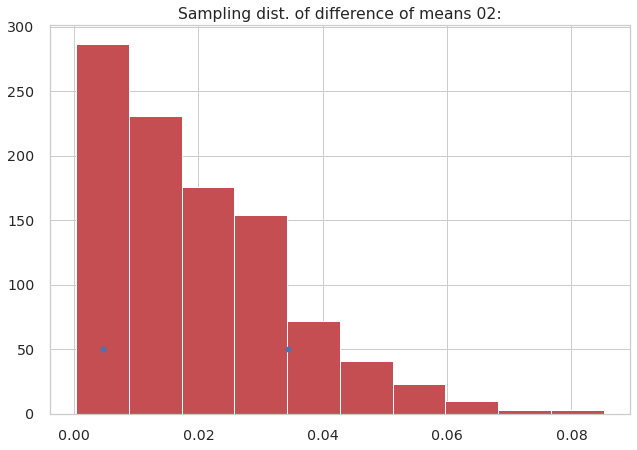


*****************************************************************


dep_nsubj
P-value: 0.0 
H0 could be rejected !!

Fake mean: 0.0201; obs mean 0.33214011027970347 
fake std: 0.0157; like t-test stat: 21.1714 


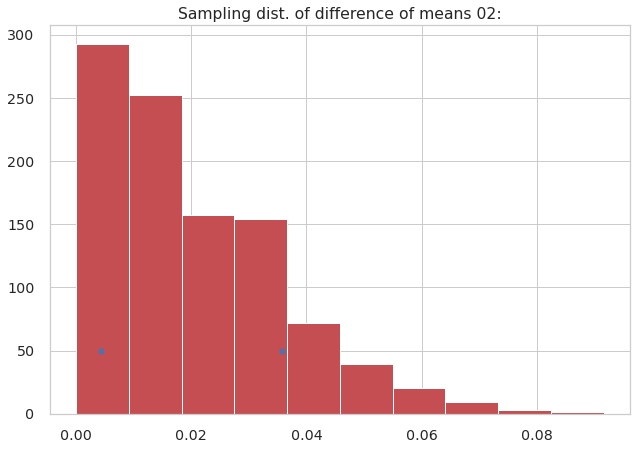


*****************************************************************


dep_pobj
P-value: 0.0 
H0 could be rejected !!

Fake mean: 0.0189; obs mean 0.12806927100277776 
fake std: 0.0144; like t-test stat: 8.9223 


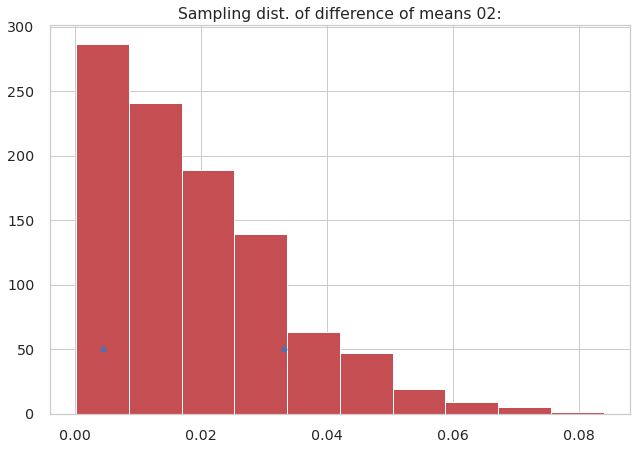


*****************************************************************


dep_prt
P-value: 0.0 
H0 could be rejected !!

Fake mean: 0.0049; obs mean 0.032556870792562385 
fake std: 0.0036; like t-test stat: 9.1125 


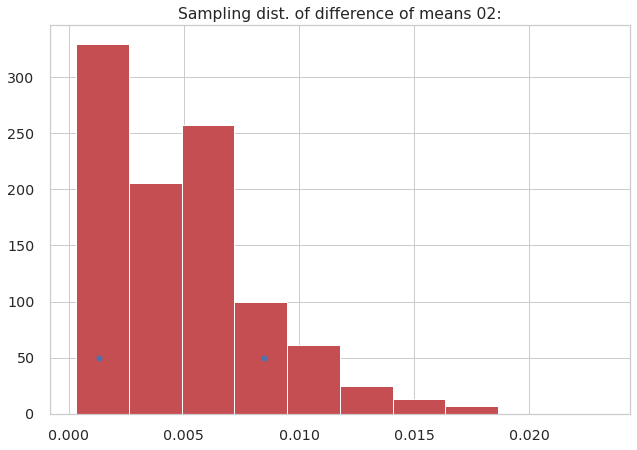


*****************************************************************


dep_amod
P-value: 0.0 
H0 could be rejected !!

Fake mean: 0.017; obs mean 0.10355697923705126 
fake std: 0.0126; like t-test stat: 8.2471 


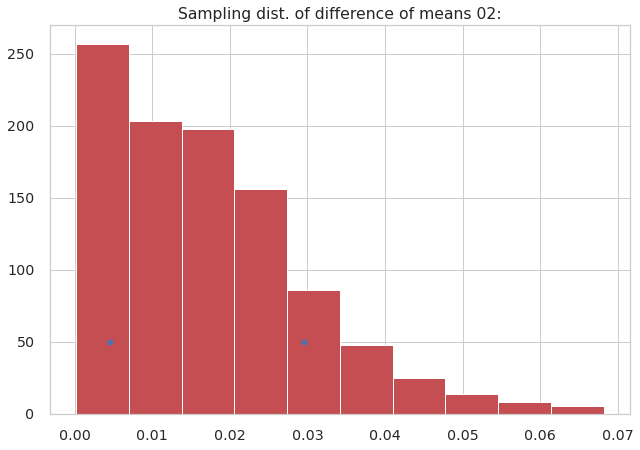


*****************************************************************


dep_neg
P-value: 0.0 
H0 could be rejected !!

Fake mean: 0.0095; obs mean 0.07131326276099667 
fake std: 0.007; like t-test stat: 10.1864 


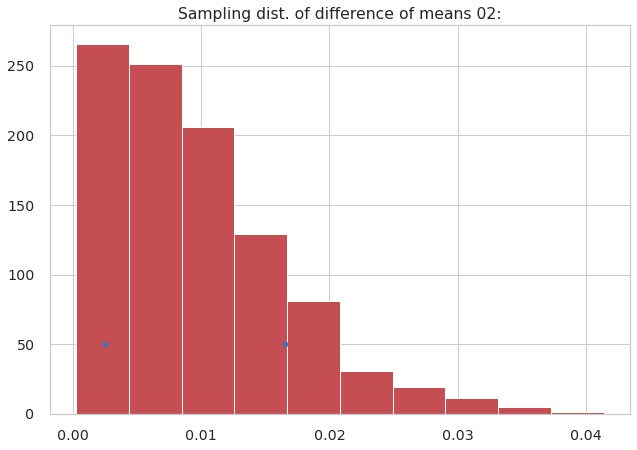


*****************************************************************


dep_ccomp
P-value: 0.0 
H0 could be rejected !!

Fake mean: 0.0106; obs mean 0.08296620702887125 
fake std: 0.0081; like t-test stat: 10.192 


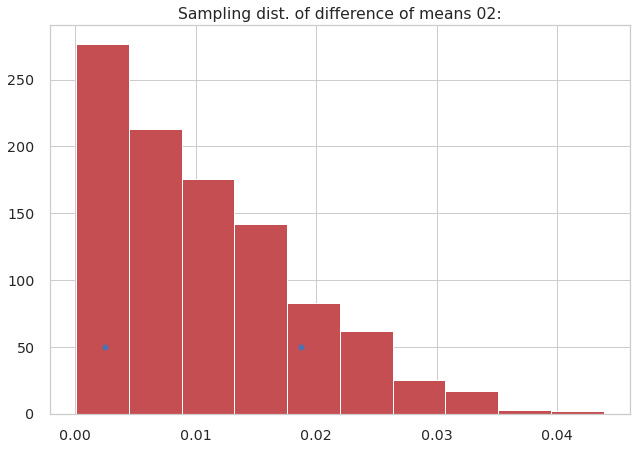


*****************************************************************


pos_NOUN
P-value: 0.0 
H0 could be rejected !!

Fake mean: 0.034; obs mean 0.2234538735537257 
fake std: 0.0265; like t-test stat: 8.4285 


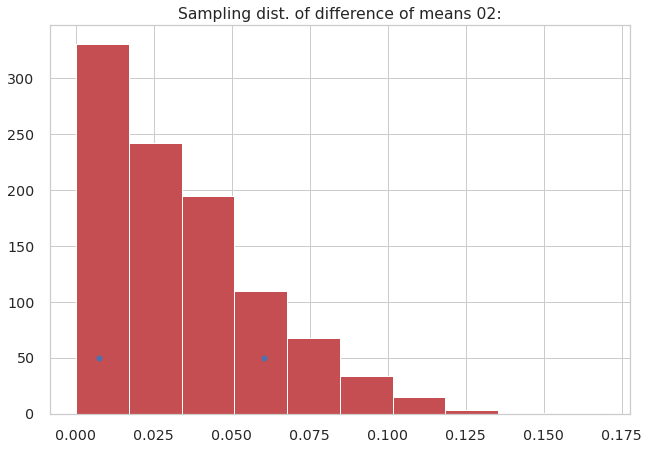


*****************************************************************




In [73]:
# 02

ttest_cols02 = pd.DataFrame(columns = ['var', 't_stat'])

for t in ttest_cols:
  pooled = np.append(ne[t], at[t])
  n_iters = 1000
  fake_differences = np.zeros(n_iters)
  observed_difference02 = np.abs(np.mean(ne[t]) - np.mean(at[t]))
  for i in np.arange(n_iters):
      shuffled = np.random.permutation(pooled)
      tres = np.floor(shuffled.shape[0] / 2)
      fake_differences[i] = np.abs(np.mean(shuffled[:int(tres)]) - np.mean(shuffled[int(tres):]))
  print(t)
  p_val = np.count_nonzero(fake_differences >= observed_difference02)/ n_iters
  #p_val = 1 - permutation_p
  fake_mean = np.mean(fake_differences)
  sampling_sd = np.std(fake_differences)
  like_t = observed_difference02 / sampling_sd # the variable name like_t. This number is rather like the famous t statistic.

  print(f'P-value: {round(p_val, 5)} ')
  if round(p_val, 3) * 2 <= 0.05:
    print('H0 could be rejected !!\n')
    ttest_cols02.loc[len(ttest_cols02)] = [str(t), round(like_t, 3)]
    
  plt.hist(fake_differences, color = 'r')

  print(f'Fake mean: {round(fake_mean, 4)}; obs mean {observed_difference02} \nfake std: {round(sampling_sd, 4)}; like t-test stat: {round(like_t, 4)} ')
  # Red dot just above x-axis at +/- one standard deviation.
  plt.plot([fake_mean - sampling_sd, fake_mean + sampling_sd], [50, 50], 'ob')
  plt.title('Sampling dist. of difference of means 02:')
  plt.show()
  print('\n*****************************************************************\n\n')

In [74]:
ttest_cols02.sort_values(by = 't_stat')

,var,t_stat
6,dep_acomp,4.294
12,dep_case,7.133
1,pos_ADJ,7.848
19,dep_amod,8.247
22,pos_NOUN,8.429
17,dep_pobj,8.922
18,dep_prt,9.112
2,pos_PROPN,9.381
11,dep_xcomp,9.964
20,dep_neg,10.186


pos_VERB
P-value: 0.0 
H0 could be rejected !!

Fake mean: 0.0512; obs mean 0.24710428363288406 
fake std: 0.0389; like t-test stat: 6.3442 


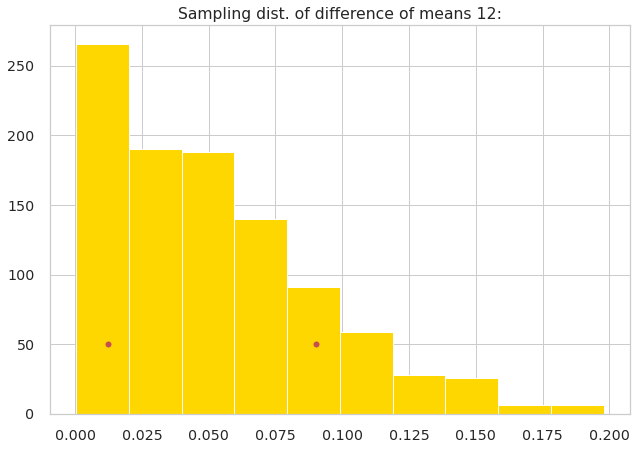


*****************************************************************


pos_ADJ
P-value: 0.063 
Fake mean: 0.0371; obs mean 0.08792705903341869 
fake std: 0.0278; like t-test stat: 3.1634 


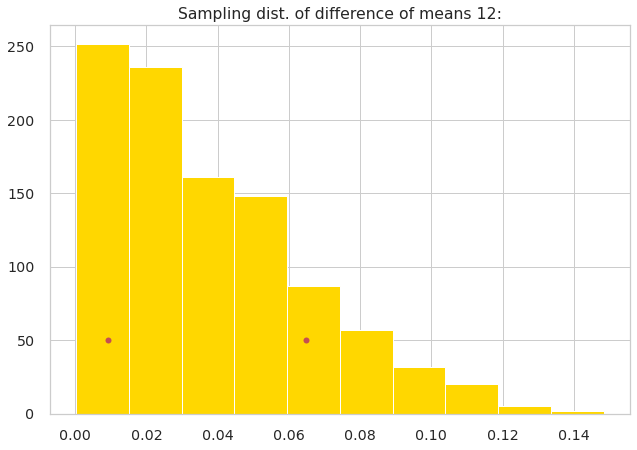


*****************************************************************


pos_PROPN
P-value: 0.024 
H0 could be rejected !!

Fake mean: 0.0328; obs mean 0.09871115279921505 
fake std: 0.0254; like t-test stat: 3.8797 


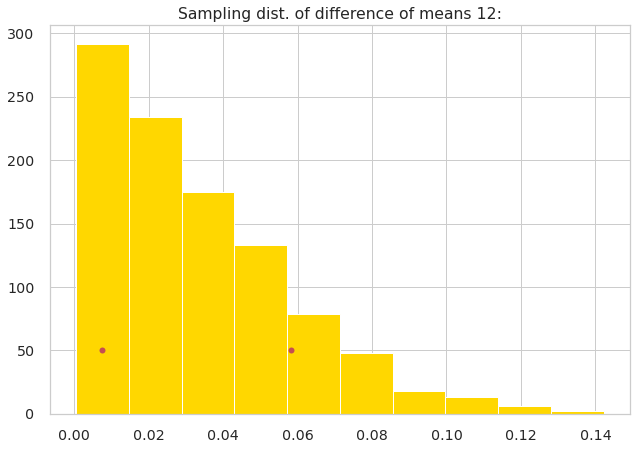


*****************************************************************


pos_ADP
P-value: 0.002 
H0 could be rejected !!

Fake mean: 0.0424; obs mean 0.16534168777352176 
fake std: 0.0319; like t-test stat: 5.1789 


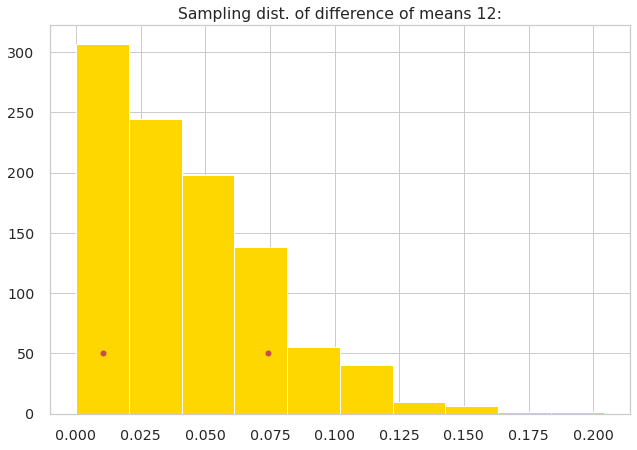


*****************************************************************


pos_CCONJ
P-value: 0.026 
H0 could be rejected !!

Fake mean: 0.0207; obs mean 0.05530987206137161 
fake std: 0.0152; like t-test stat: 3.6359 


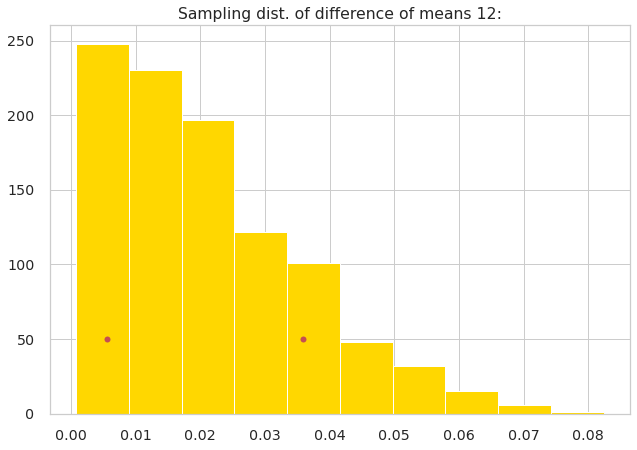


*****************************************************************


pos_PART
P-value: 0.001 
H0 could be rejected !!

Fake mean: 0.0266; obs mean 0.10919114566298055 
fake std: 0.0198; like t-test stat: 5.5049 


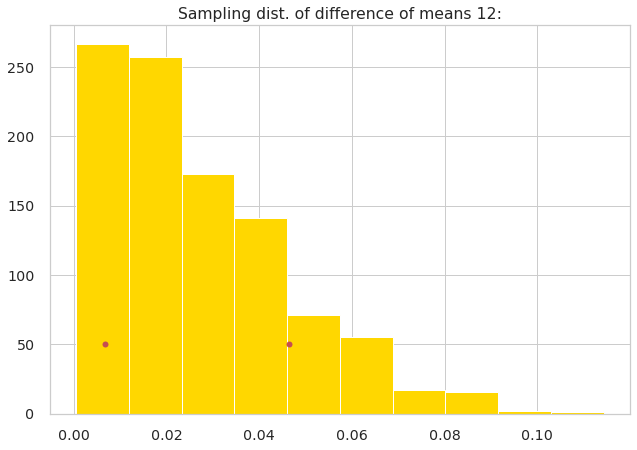


*****************************************************************


dep_acomp
P-value: 0.841 
Fake mean: 0.0163; obs mean 0.004447982527037958 
fake std: 0.0124; like t-test stat: 0.3591 


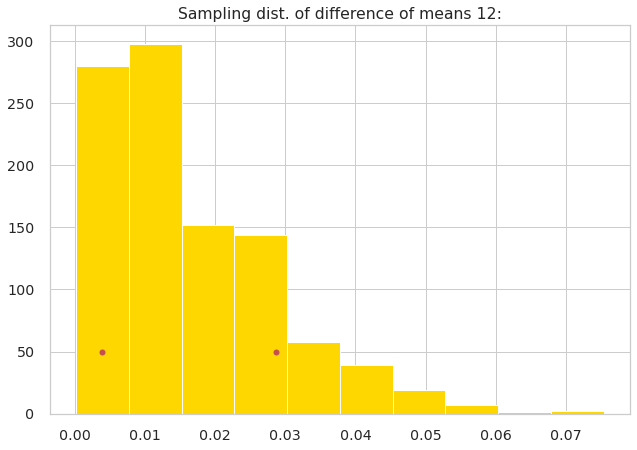


*****************************************************************


dep_prep
P-value: 0.0 
H0 could be rejected !!

Fake mean: 0.0379; obs mean 0.17869509627158786 
fake std: 0.0291; like t-test stat: 6.1501 


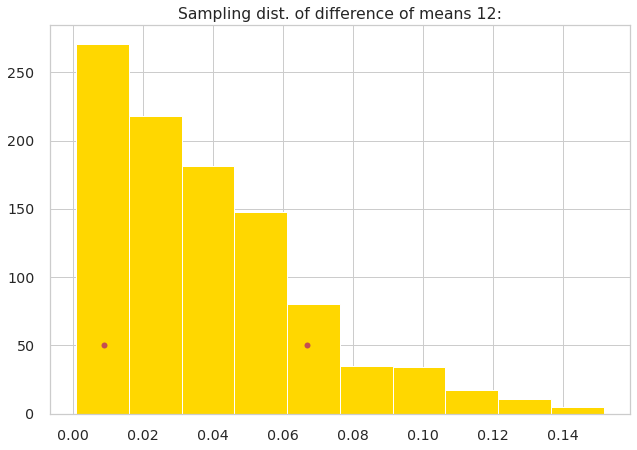


*****************************************************************


dep_aux
P-value: 0.106 
Fake mean: 0.0318; obs mean 0.0640004000616311 
fake std: 0.0236; like t-test stat: 2.7168 


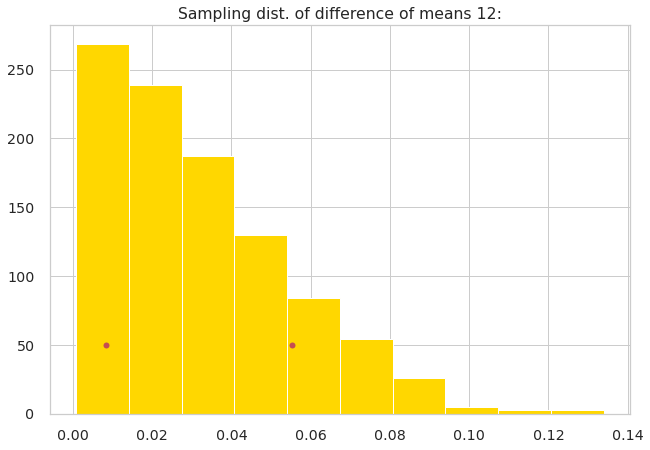


*****************************************************************


dep_cc
P-value: 0.031 
H0 could be rejected !!

Fake mean: 0.0191; obs mean 0.05375828168123198 
fake std: 0.0144; like t-test stat: 3.7266 


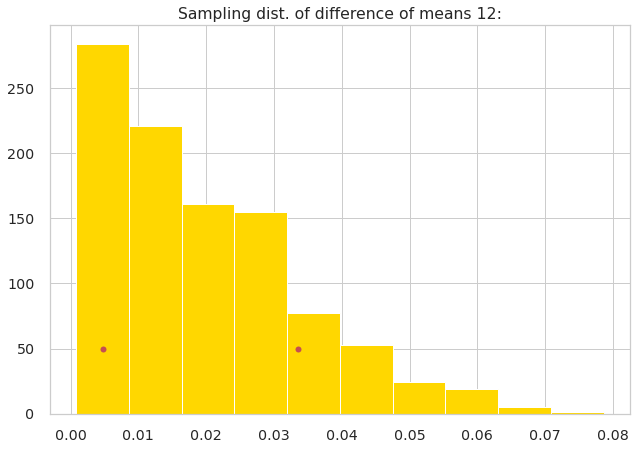


*****************************************************************


dep_poss
P-value: 0.026 
H0 could be rejected !!

Fake mean: 0.0175; obs mean 0.04922650246118995 
fake std: 0.013; like t-test stat: 3.7863 


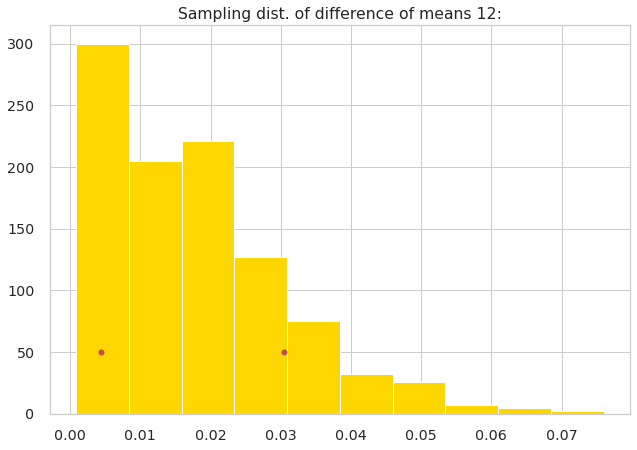


*****************************************************************


dep_xcomp
P-value: 0.01 
H0 could be rejected !!

Fake mean: 0.0169; obs mean 0.052643245040452175 
fake std: 0.0124; like t-test stat: 4.2405 


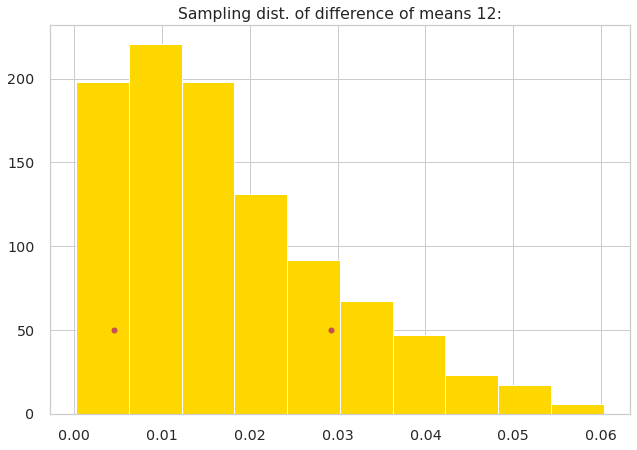


*****************************************************************


dep_case
P-value: 0.076 
Fake mean: 0.0076; obs mean 0.016387659720551548 
fake std: 0.0058; like t-test stat: 2.8447 


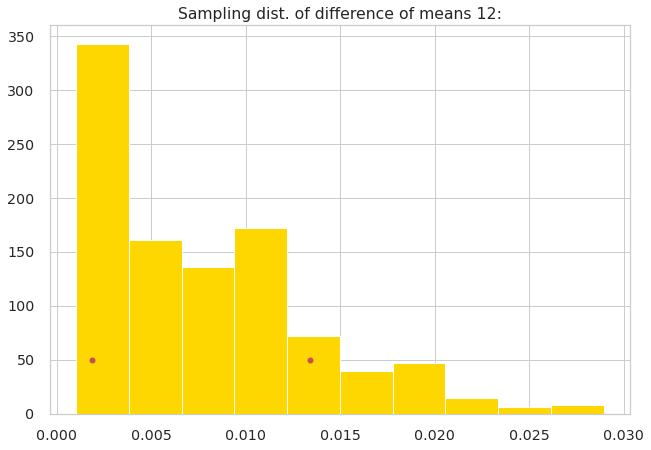


*****************************************************************


ent_PERSON
P-value: 0.0 
H0 could be rejected !!

Fake mean: 0.0193; obs mean 0.12516657971633469 
fake std: 0.0142; like t-test stat: 8.7843 


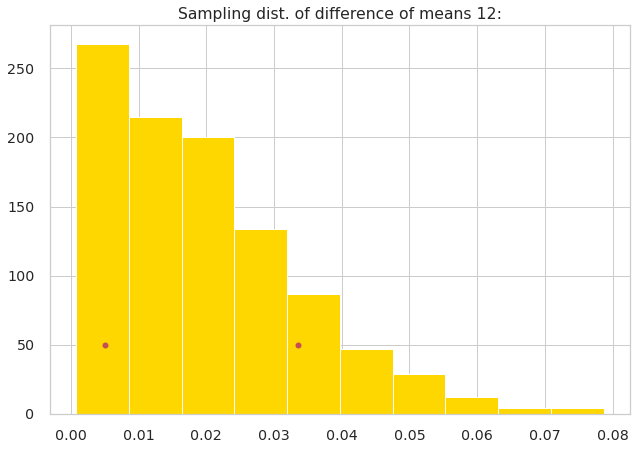


*****************************************************************


pos_INTJ
P-value: 0.601 
Fake mean: 0.0097; obs mean 0.006300970690079281 
fake std: 0.007; like t-test stat: 0.8959 


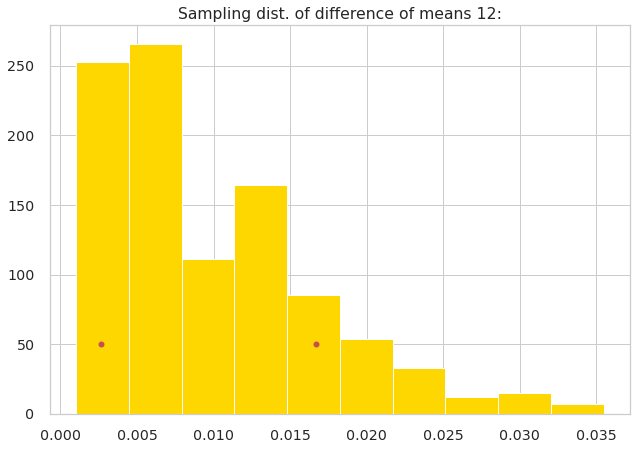


*****************************************************************


pos_PRON
P-value: 0.32 
Fake mean: 0.051; obs mean 0.06392065804732061 
fake std: 0.0377; like t-test stat: 1.697 


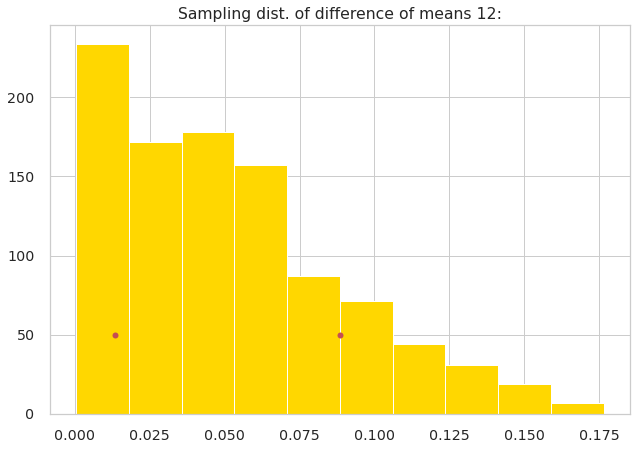


*****************************************************************


pos_AUX
P-value: 0.104 
Fake mean: 0.0369; obs mean 0.07540215654844118 
fake std: 0.0274; like t-test stat: 2.7515 


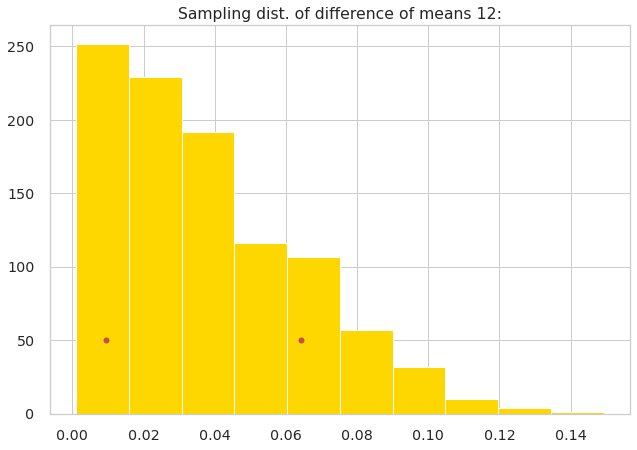


*****************************************************************


dep_nsubj
P-value: 0.101 
Fake mean: 0.0382; obs mean 0.07708484820634531 
fake std: 0.0286; like t-test stat: 2.6958 


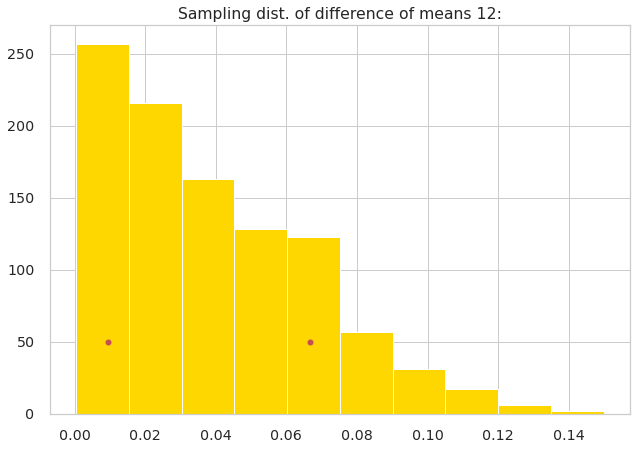


*****************************************************************


dep_pobj
P-value: 0.002 
H0 could be rejected !!

Fake mean: 0.0357; obs mean 0.1285008771621574 
fake std: 0.0255; like t-test stat: 5.0405 


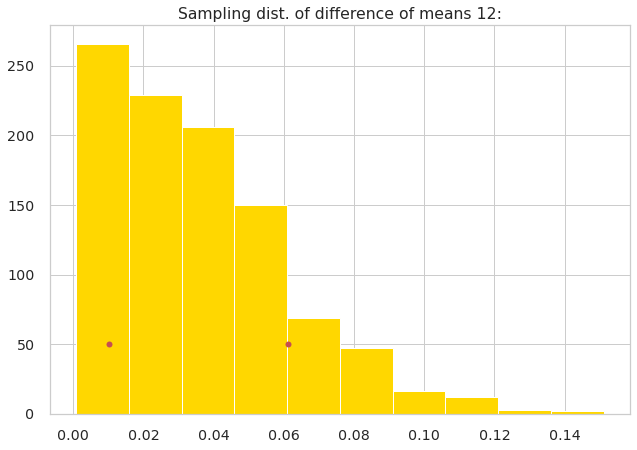


*****************************************************************


dep_prt
P-value: 0.87 
Fake mean: 0.0109; obs mean 0.0020949173251014475 
fake std: 0.0082; like t-test stat: 0.2547 


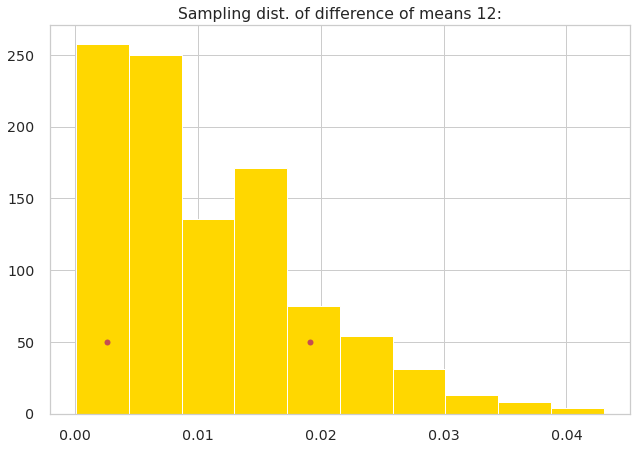


*****************************************************************


dep_amod
P-value: 0.002 
H0 could be rejected !!

Fake mean: 0.0305; obs mean 0.12767372270863347 
fake std: 0.0231; like t-test stat: 5.5275 


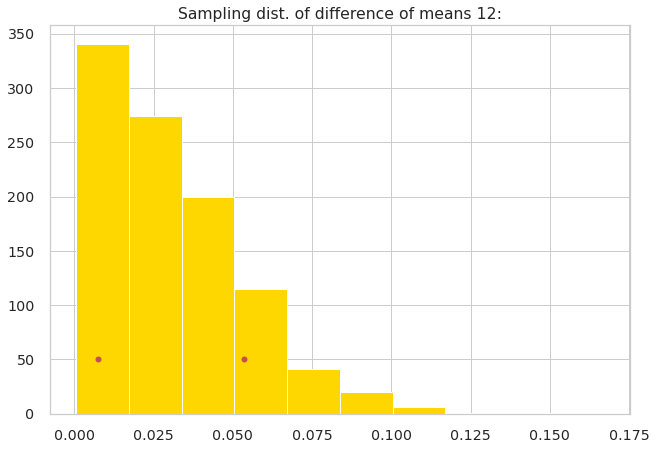


*****************************************************************


dep_neg
P-value: 0.0 
H0 could be rejected !!

Fake mean: 0.0175; obs mean 0.09557012837112744 
fake std: 0.013; like t-test stat: 7.3671 


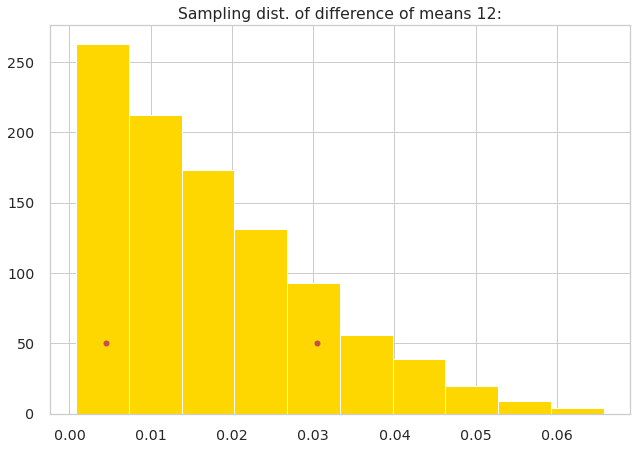


*****************************************************************


dep_ccomp
P-value: 0.605 
Fake mean: 0.0213; obs mean 0.01391971195562558 
fake std: 0.0157; like t-test stat: 0.8847 


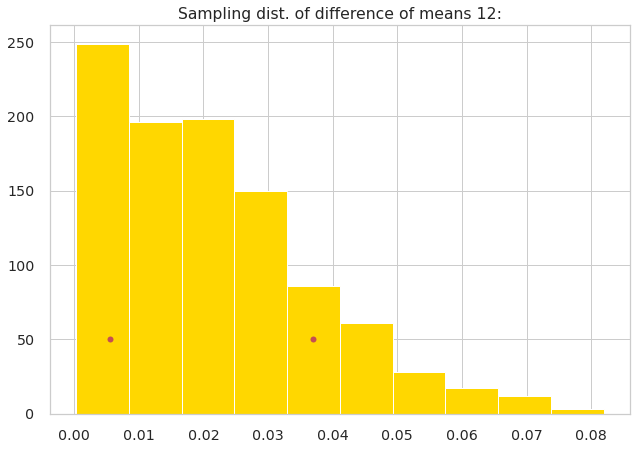


*****************************************************************


pos_NOUN
P-value: 0.0 
H0 could be rejected !!

Fake mean: 0.0631; obs mean 0.5154496773827317 
fake std: 0.047; like t-test stat: 10.9644 


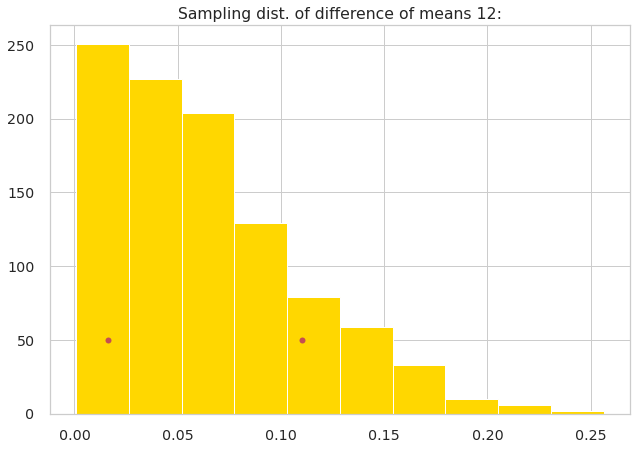


*****************************************************************




In [66]:
# 12

ttest_cols12 = pd.DataFrame(columns = ['var', 't_stat'])

for t in ttest_cols:
  pooled = np.append(su[t], at[t])
  n_iters = 1000
  fake_differences = np.zeros(n_iters)
  observed_difference12 = np.abs(np.mean(su[t]) - np.mean(at[t]))
  for i in np.arange(n_iters):
      shuffled = np.random.permutation(pooled)
      tres = np.floor(shuffled.shape[0] / 2)
      fake_differences[i] = np.abs(np.mean(shuffled[:int(tres)]) - np.mean(shuffled[int(tres):]))
  print(t)
  p_val = np.count_nonzero(fake_differences >= observed_difference12)/ n_iters
  #p_val = 1 - permutation_p
  fake_mean = np.mean(fake_differences)
  sampling_sd = np.std(fake_differences)
  like_t = observed_difference12 / sampling_sd # the variable name like_t. This number is rather like the famous t statistic.

  print(f'P-value: {round(p_val, 5)} ')
  if round(p_val, 3) <= 0.05:
    print('H0 could be rejected !!\n')
    ttest_cols12.loc[len(ttest_cols12)] = [str(t), round(like_t, 3)]
    
  plt.hist(fake_differences, color = 'gold')

  print(f'Fake mean: {round(fake_mean, 4)}; obs mean {observed_difference12} \nfake std: {round(sampling_sd, 4)}; like t-test stat: {round(like_t, 4)} ')
  # Red dot just above x-axis at +/- one standard deviation.
  plt.plot([fake_mean - sampling_sd, fake_mean + sampling_sd], [50, 50], 'or')
  plt.title('Sampling dist. of difference of means 12:')
  plt.show()
  print('\n*****************************************************************\n\n')

In [67]:
ttest_cols12.sort_values(by = 't_stat')

,var,t_stat
3,pos_CCONJ,3.636
6,dep_cc,3.727
7,dep_poss,3.786
1,pos_PROPN,3.880
8,dep_xcomp,4.240
10,dep_pobj,5.041
2,pos_ADP,5.179
4,pos_PART,5.505
11,dep_amod,5.528
5,dep_prep,6.150


pos_VERB
P-value: 0.0 
H0 could be rejected !!
Fake mean: 0.0256; obs mean 0.3790140771907953 
fake std: 0.019; like t-test stat: 19.9847 


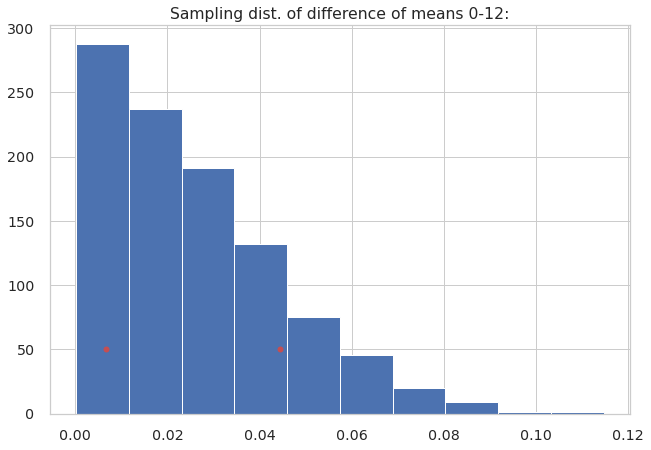


*****************************************************************


pos_ADJ
P-value: 0.0 
H0 could be rejected !!
Fake mean: 0.0194; obs mean 0.09946877218499472 
fake std: 0.0146; like t-test stat: 6.796 


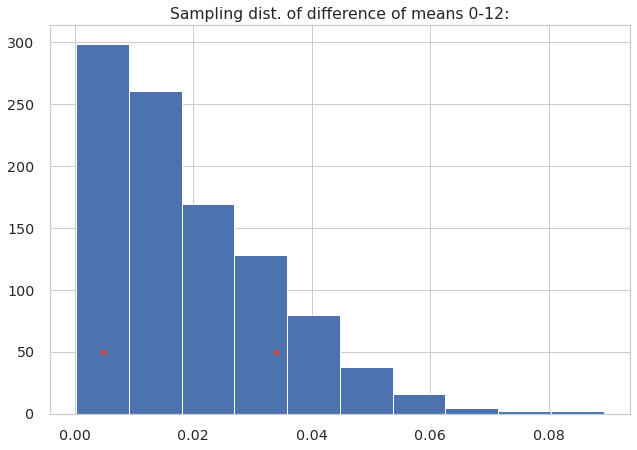


*****************************************************************


pos_PROPN
P-value: 0.0 
H0 could be rejected !!
Fake mean: 0.0175; obs mean 0.16676951846657323 
fake std: 0.0133; like t-test stat: 12.5406 


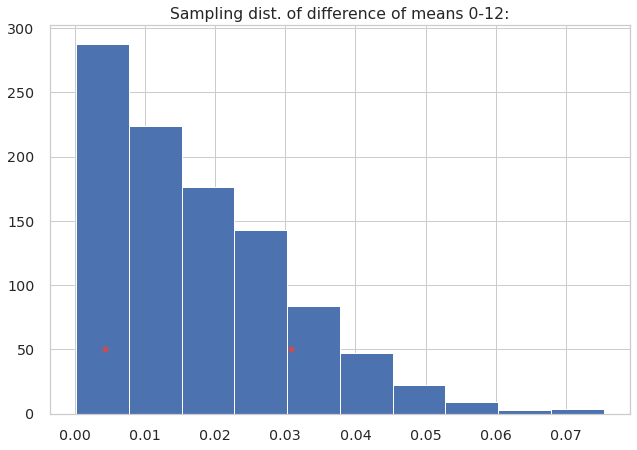


*****************************************************************


pos_ADP
P-value: 0.0 
H0 could be rejected !!
Fake mean: 0.022; obs mean 0.14715391408238532 
fake std: 0.0169; like t-test stat: 8.6873 


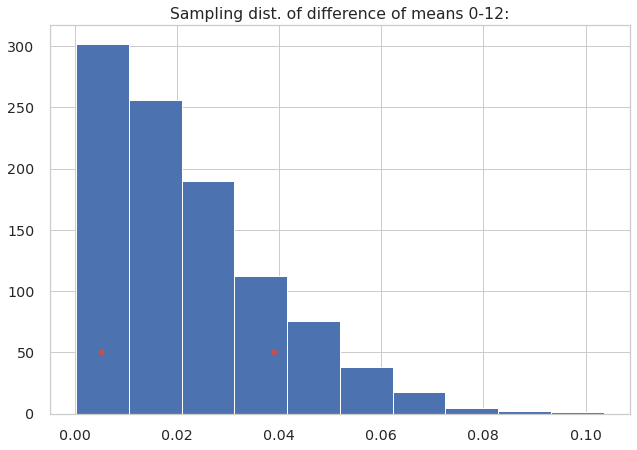


*****************************************************************


pos_CCONJ
P-value: 0.0 
H0 could be rejected !!
Fake mean: 0.0107; obs mean 0.07044724949353284 
fake std: 0.0077; like t-test stat: 9.1195 


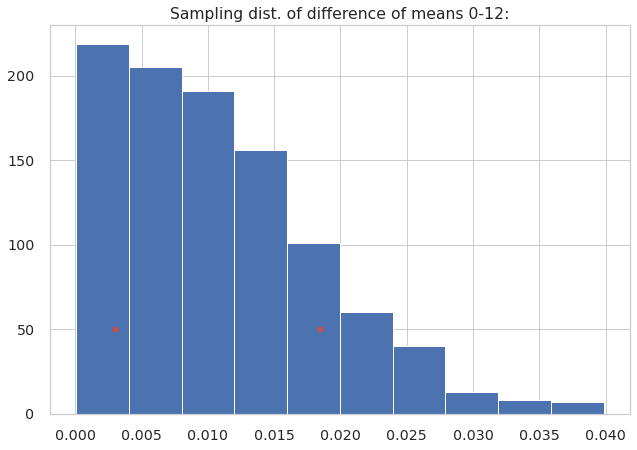


*****************************************************************


pos_PART
P-value: 0.0 
H0 could be rejected !!
Fake mean: 0.0137; obs mean 0.100094886845705 
fake std: 0.0103; like t-test stat: 9.7241 


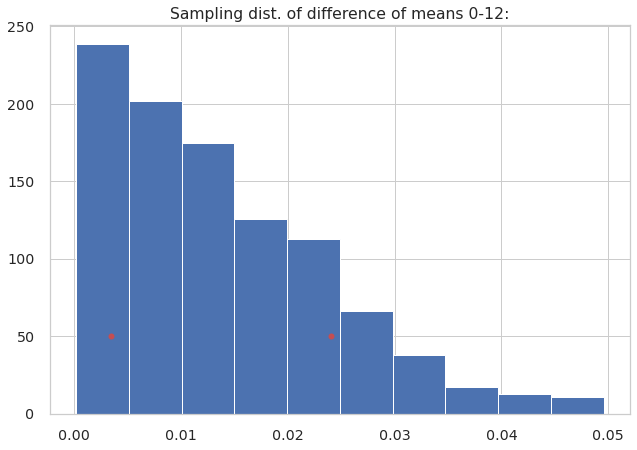


*****************************************************************


dep_acomp
P-value: 0.011 
H0 could be rejected !!
Fake mean: 0.0084; obs mean 0.026564853773829944 
fake std: 0.0063; like t-test stat: 4.1964 


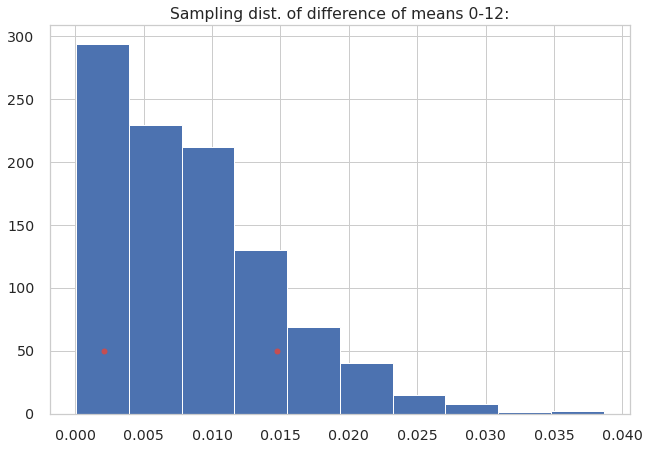


*****************************************************************


dep_prep
P-value: 0.0 
H0 could be rejected !!
Fake mean: 0.0208; obs mean 0.13001264003601554 
fake std: 0.0157; like t-test stat: 8.3022 


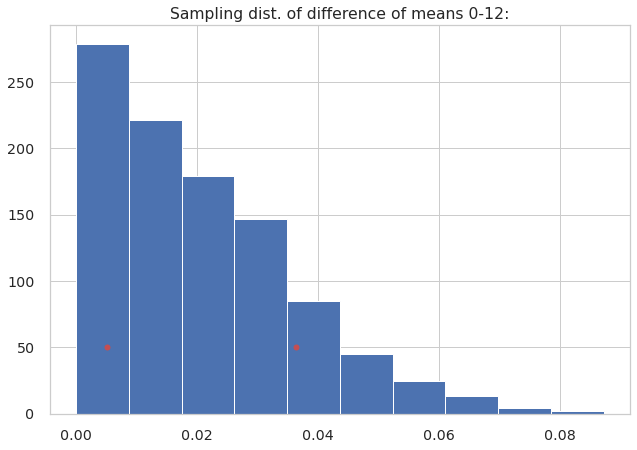


*****************************************************************


dep_aux
P-value: 0.0 
H0 could be rejected !!
Fake mean: 0.016; obs mean 0.17708136373868022 
fake std: 0.0125; like t-test stat: 14.2137 


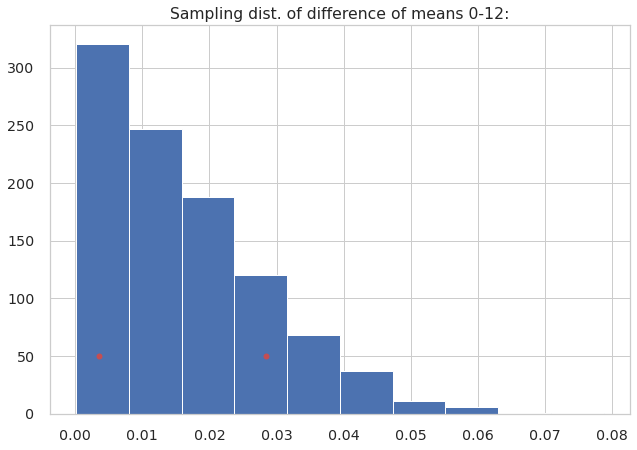


*****************************************************************


dep_cc
P-value: 0.0 
H0 could be rejected !!
Fake mean: 0.0102; obs mean 0.07195435734940178 
fake std: 0.0079; like t-test stat: 9.1576 


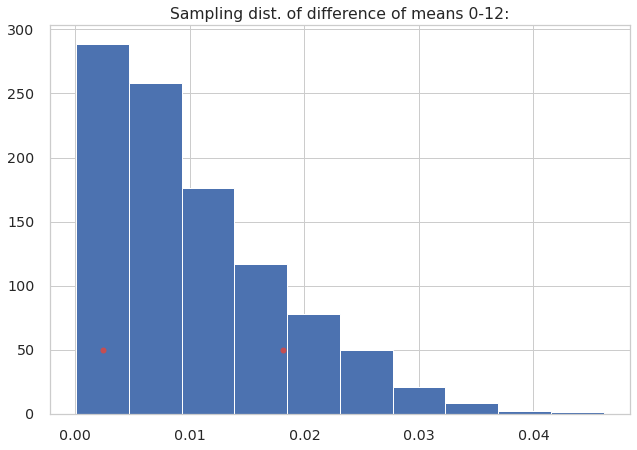


*****************************************************************


dep_poss
P-value: 0.0 
H0 could be rejected !!
Fake mean: 0.0078; obs mean 0.0864270254359081 
fake std: 0.0059; like t-test stat: 14.6458 


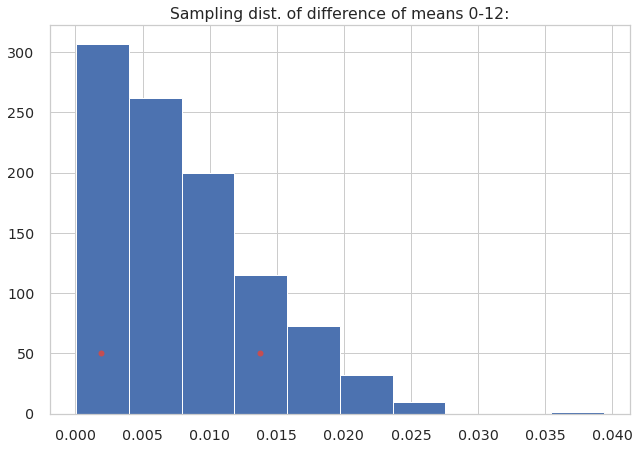


*****************************************************************


dep_xcomp
P-value: 0.0 
H0 could be rejected !!
Fake mean: 0.0079; obs mean 0.04379685903762573 
fake std: 0.006; like t-test stat: 7.3189 


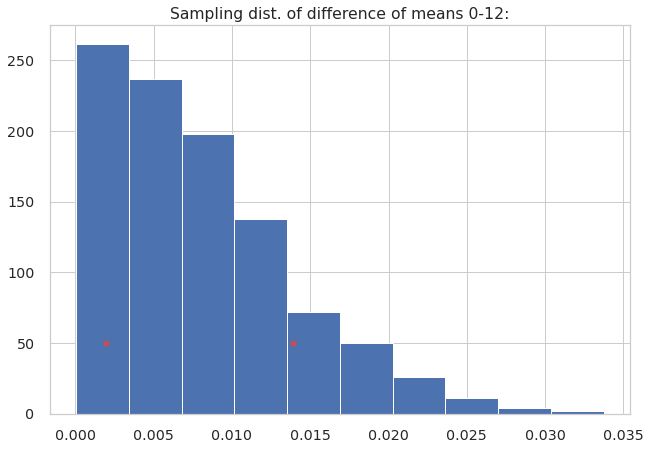


*****************************************************************


dep_case
P-value: 0.0 
H0 could be rejected !!
Fake mean: 0.0032; obs mean 0.02240991809949267 
fake std: 0.0023; like t-test stat: 9.5462 


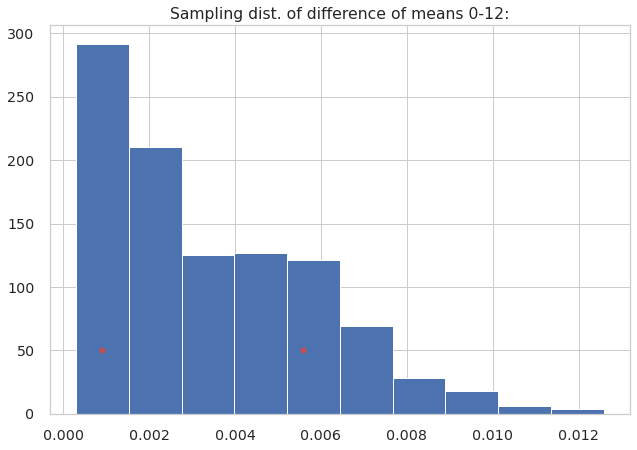


*****************************************************************


ent_PERSON
P-value: 0.0 
H0 could be rejected !!
Fake mean: 0.0082; obs mean 0.17901476979550845 
fake std: 0.0063; like t-test stat: 28.3796 


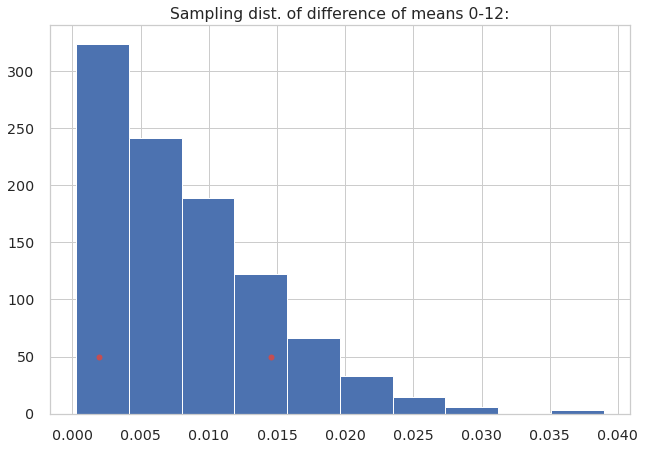


*****************************************************************


pos_INTJ
P-value: 0.232 
Fake mean: 0.0056; obs mean 0.008795387252610254 
fake std: 0.0043; like t-test stat: 2.0577 


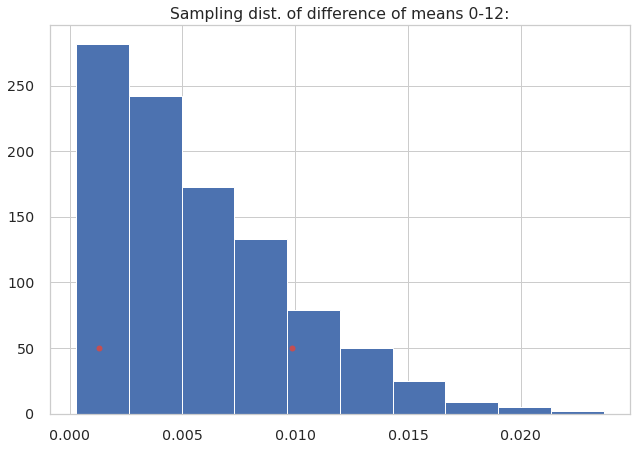


*****************************************************************


pos_PRON
P-value: 0.0 
H0 could be rejected !!
Fake mean: 0.0257; obs mean 0.38945959517254525 
fake std: 0.0192; like t-test stat: 20.3038 


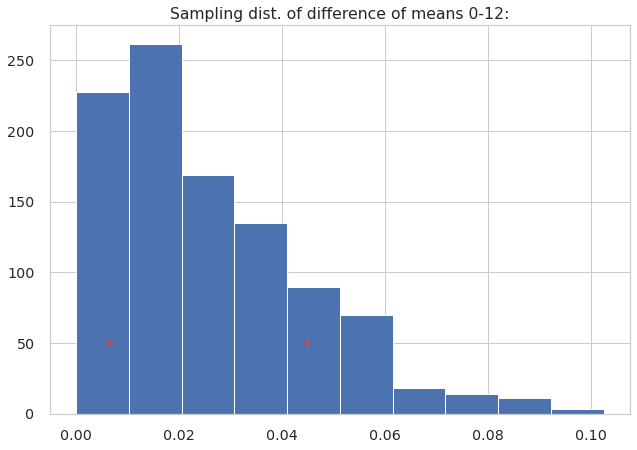


*****************************************************************


pos_AUX
P-value: 0.0 
H0 could be rejected !!
Fake mean: 0.019; obs mean 0.1630706629958616 
fake std: 0.0148; like t-test stat: 11.0509 


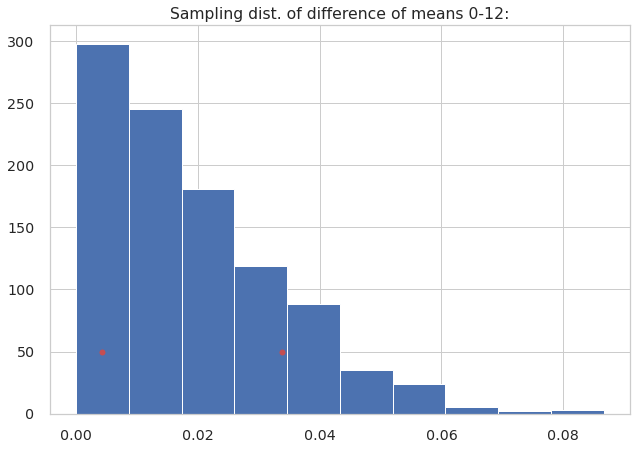


*****************************************************************


dep_nsubj
P-value: 0.0 
H0 could be rejected !!
Fake mean: 0.0193; obs mean 0.3083898671930463 
fake std: 0.0148; like t-test stat: 20.7877 


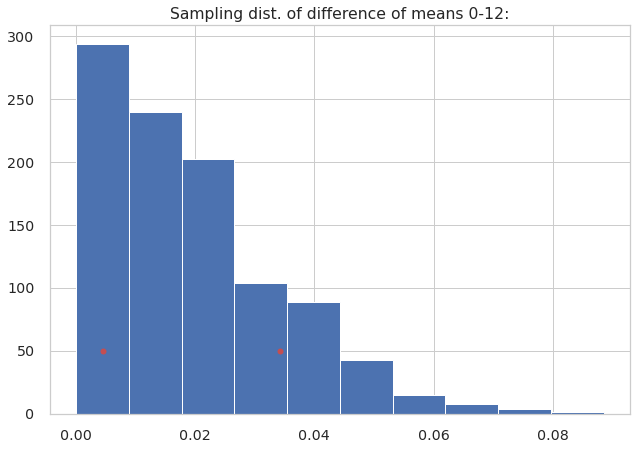


*****************************************************************


dep_pobj
P-value: 0.0 
H0 could be rejected !!
Fake mean: 0.0191; obs mean 0.08847748168926284 
fake std: 0.0141; like t-test stat: 6.2954 


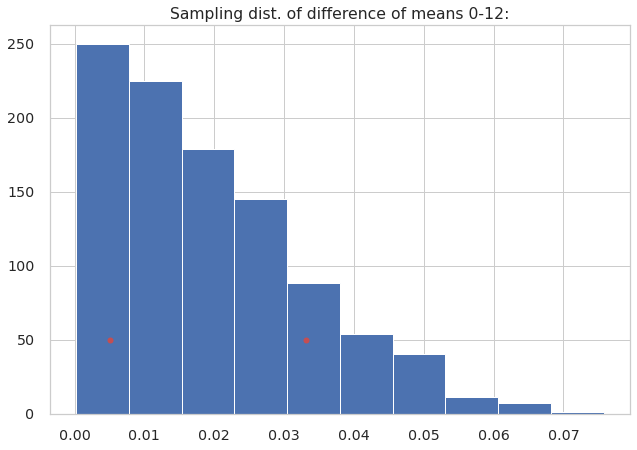


*****************************************************************


dep_prt
P-value: 0.0 
H0 could be rejected !!
Fake mean: 0.0047; obs mean 0.03191141585718491 
fake std: 0.0035; like t-test stat: 9.0582 


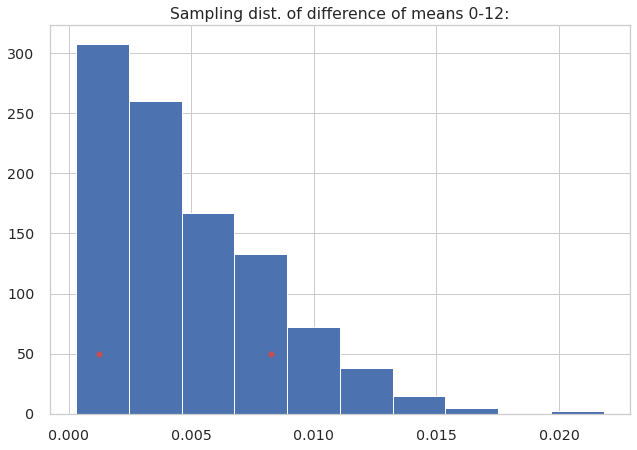


*****************************************************************


dep_amod
P-value: 0.0 
H0 could be rejected !!
Fake mean: 0.0163; obs mean 0.06422004051737568 
fake std: 0.012; like t-test stat: 5.3451 


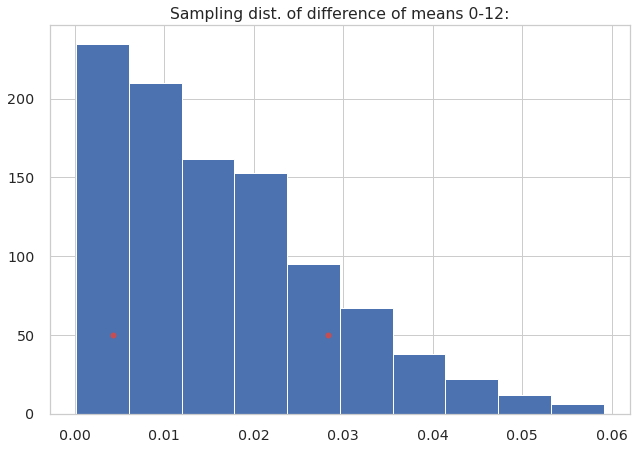


*****************************************************************


dep_neg
P-value: 0.0 
H0 could be rejected !!
Fake mean: 0.0091; obs mean 0.04186760860907657 
fake std: 0.0069; like t-test stat: 6.0813 


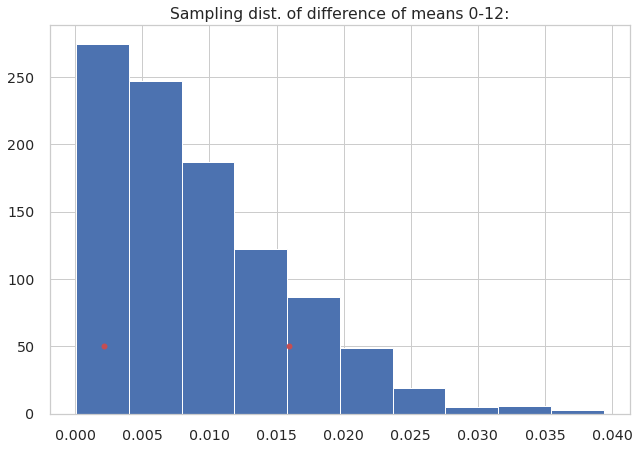


*****************************************************************


dep_ccomp
P-value: 0.0 
H0 could be rejected !!
Fake mean: 0.0101; obs mean 0.0786774713001922 
fake std: 0.0078; like t-test stat: 10.0541 


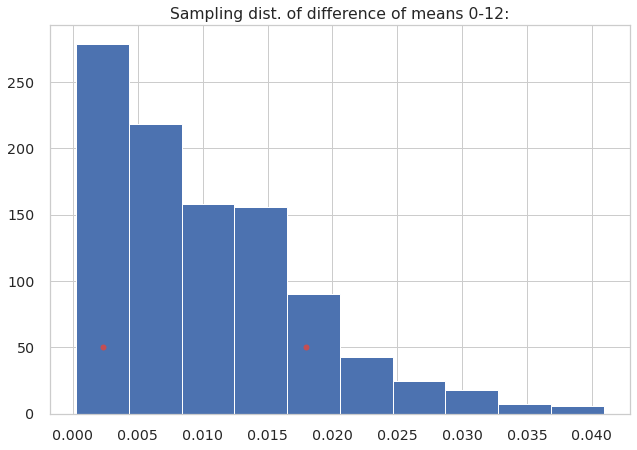


*****************************************************************


pos_NOUN
P-value: 0.151 
Fake mean: 0.0355; obs mean 0.06464114418298617 
fake std: 0.0258; like t-test stat: 2.5026 


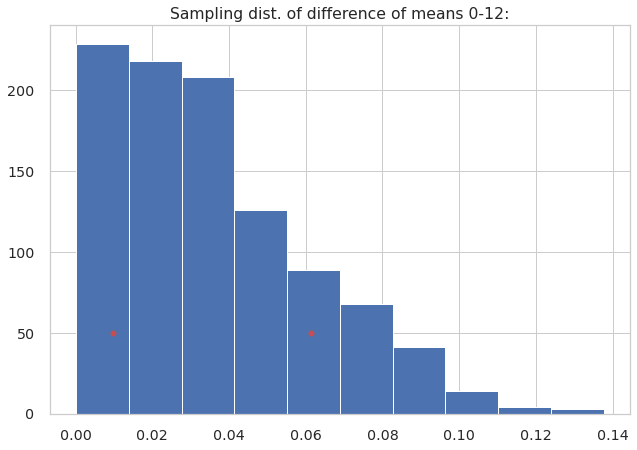


*****************************************************************




In [68]:
# 012

ttest_cols012 = pd.DataFrame(columns = ['var', 't_stat'])

for t in ttest_cols:
  pooled = np.append(ne[t], ethos[t])
  n_iters = 1000
  fake_differences = np.zeros(n_iters)
  observed_difference12 = np.abs(np.mean(ne[t]) - np.mean(ethos[t]))
  for i in np.arange(n_iters):
      shuffled = np.random.permutation(pooled)
      tres = np.floor(shuffled.shape[0] / 2)
      fake_differences[i] = np.abs(np.mean(shuffled[:int(tres)]) - np.mean(shuffled[int(tres):]))
  print(t)
  p_val = np.count_nonzero(fake_differences >= observed_difference12)/ n_iters
  #p_val = 1 - permutation_p
  fake_mean = np.mean(fake_differences)
  sampling_sd = np.std(fake_differences)
  like_t = observed_difference12 / sampling_sd # the variable name like_t. This number is rather like the famous t statistic.

  print(f'P-value: {round(p_val, 5)} ')
  if round(p_val, 3) <= 0.05:
    print('H0 could be rejected !!')
    ttest_cols012.loc[len(ttest_cols012)] = [str(t), round(like_t, 3)]
    
  plt.hist(fake_differences, color = 'b')

  print(f'Fake mean: {round(fake_mean, 4)}; obs mean {observed_difference12} \nfake std: {round(sampling_sd, 4)}; like t-test stat: {round(like_t, 4)} ')
  # Red dot just above x-axis at +/- one standard deviation.
  plt.plot([fake_mean - sampling_sd, fake_mean + sampling_sd], [50, 50], 'or')
  plt.title('Sampling dist. of difference of means 0-12:')
  plt.show()
  print('\n*****************************************************************\n\n')

In [69]:
ttest_cols012.sort_values(by = 't_stat')

,var,t_stat
6,dep_acomp,4.196
19,dep_amod,5.345
20,dep_neg,6.081
17,dep_pobj,6.295
1,pos_ADJ,6.796
11,dep_xcomp,7.319
7,dep_prep,8.302
3,pos_ADP,8.687
18,dep_prt,9.058
4,pos_CCONJ,9.120


In [77]:
ttest_cols012['var'].values # vars for ethos vs. non-ethos

array(['pos_VERB', 'pos_ADJ', 'pos_PROPN', 'pos_ADP', 'pos_CCONJ',
       'pos_PART', 'dep_acomp', 'dep_prep', 'dep_aux', 'dep_cc',
       'dep_poss', 'dep_xcomp', 'dep_case', 'ent_PERSON', 'pos_PRON',
       'pos_AUX', 'dep_nsubj', 'dep_pobj', 'dep_prt', 'dep_amod',
       'dep_neg', 'dep_ccomp'], dtype=object)

In [78]:
ttest_cols12['var'].values # vars for supp vs. att

array(['pos_VERB', 'pos_PROPN', 'pos_ADP', 'pos_CCONJ', 'pos_PART',
       'dep_prep', 'dep_cc', 'dep_poss', 'dep_xcomp', 'ent_PERSON',
       'dep_pobj', 'dep_amod', 'dep_neg', 'pos_NOUN'], dtype=object)

In [79]:
set(ttest_cols01['var'].values).intersection(set(ttest_cols02['var'].values))

{'dep_aux',
 'dep_case',
 'dep_cc',
 'dep_ccomp',
 'dep_nsubj',
 'dep_poss',
 'dep_prt',
 'ent_PERSON',
 'pos_AUX',
 'pos_CCONJ',
 'pos_NOUN',
 'pos_PRON',
 'pos_PROPN',
 'pos_VERB'}

In [80]:
set(ttest_cols12['var'].values).intersection(set(ttest_cols012['var'].values))

{'dep_amod',
 'dep_cc',
 'dep_neg',
 'dep_pobj',
 'dep_poss',
 'dep_prep',
 'dep_xcomp',
 'ent_PERSON',
 'pos_ADP',
 'pos_CCONJ',
 'pos_PART',
 'pos_PROPN',
 'pos_VERB'}

In [81]:
set(ttest_cols01['var'].values).intersection(set(ttest_cols02['var'].values)).intersection(set(ttest_cols012['var'].values)).intersection(set(ttest_cols12['var'].values))

{'dep_cc', 'dep_poss', 'ent_PERSON', 'pos_CCONJ', 'pos_PROPN', 'pos_VERB'}

In [82]:
ttest_cols_perm = set(ttest_cols01['var'].values).union(set(ttest_cols02['var'].values)).union(set(ttest_cols012['var'].values)).union(set(ttest_cols12['var'].values))
ttest_cols_perm

{'dep_acomp',
 'dep_amod',
 'dep_aux',
 'dep_case',
 'dep_cc',
 'dep_ccomp',
 'dep_neg',
 'dep_nsubj',
 'dep_pobj',
 'dep_poss',
 'dep_prep',
 'dep_prt',
 'dep_xcomp',
 'ent_PERSON',
 'pos_ADJ',
 'pos_ADP',
 'pos_AUX',
 'pos_CCONJ',
 'pos_NOUN',
 'pos_PART',
 'pos_PRON',
 'pos_PROPN',
 'pos_VERB'}

In [83]:
len(ttest_cols_perm), len(ttest_cols)

(23, 24)

In [84]:
set(ttest_cols).difference(ttest_cols_perm)

{'pos_INTJ'}

##Ethos

In [ ]:
data = prepare_cloud_lexeme_data(df_ethos[df_ethos.Ethos_Label == 0], 
                                 df_ethos[df_ethos.Ethos_Label == 1], 
                                 df_ethos[df_ethos.Ethos_Label == 2])
data.tail()

,word,support #,neutral #,attack #,general #
5325,stuttering,0.0,0.0,1.0,1.0
5326,unforced,0.0,0.0,1.0,1.0
5327,narcissistic,0.0,0.0,1.0,1.0
5328,impactful,0.0,0.0,1.0,1.0
5329,temper,0.0,0.0,1.0,1.0


There are 32 words.


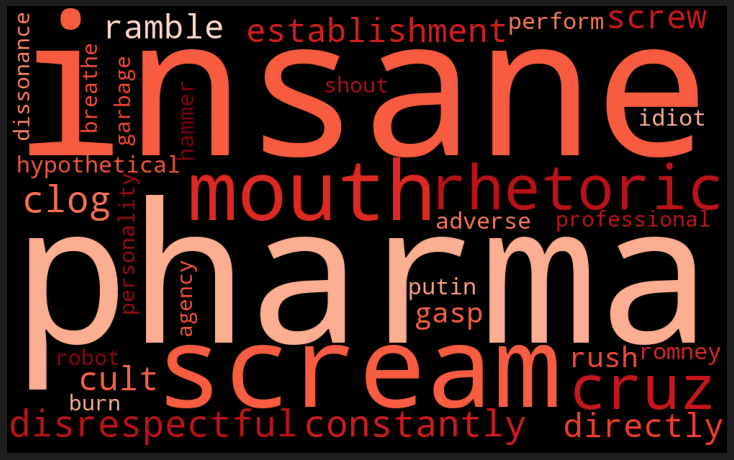

{'pharma': 1.0,
 'insane': 1.0,
 'scream': 1.0,
 'mouth': 1.0,
 'rhetoric': 0.8571428571428571,
 'cruz': 0.8571428571428571,
 'constantly': 0.7142857142857143,
 'clog': 0.7142857142857143,
 'disrespectful': 0.7142857142857143,
 'directly': 0.5714285714285714,
 'establishment': 0.5714285714285714,
 'screw': 0.5714285714285714,
 'cult': 0.5714285714285714,
 'ramble': 0.5714285714285714,
 'gasp': 0.42857142857142855,
 'rush': 0.42857142857142855,
 'hypothetical': 0.42857142857142855,
 'perform': 0.42857142857142855,
 'romney': 0.42857142857142855,
 'idiot': 0.42857142857142855,
 'adverse': 0.42857142857142855,
 'putin': 0.42857142857142855,
 'hammer': 0.42857142857142855,
 'professional': 0.42857142857142855,
 'personality': 0.42857142857142855,
 'agency': 0.42857142857142855,
 'garbage': 0.42857142857142855,
 'robot': 0.42857142857142855,
 'burn': 0.42857142857142855,
 'shout': 0.42857142857142855,
 'dissonance': 0.42857142857142855,
 'breathe': 0.42857142857142855}

In [ ]:
words = wordcloud_lexeme(dataframe = data, lexeme_threshold = 75, analysis_for = 'attack', cmap_wordcloud = 'Reds', count_threshold=3)
words

In [ ]:
attack_words_ethos = {'pharma': 1.0,
 'insane': 1.0,
 'scream': 1.0,
 'mouth': 1.0,
 'rhetoric': 0.8571428571428571,
 'cruz': 0.8571428571428571,
 'constantly': 0.7142857142857143,
 'clog': 0.7142857142857143,
 'disrespectful': 0.7142857142857143,
 'directly': 0.5714285714285714,
 'establishment': 0.5714285714285714,
 'screw': 0.5714285714285714,
 'cult': 0.5714285714285714,
 'ramble': 0.5714285714285714,
 'gasp': 0.42857142857142855,
 'rush': 0.42857142857142855,
 'hypothetical': 0.42857142857142855,
 'perform': 0.42857142857142855,
 'romney': 0.42857142857142855,
 'idiot': 0.42857142857142855,
 'adverse': 0.42857142857142855,
 'putin': 0.42857142857142855,
 'hammer': 0.42857142857142855,
 'professional': 0.42857142857142855,
 'personality': 0.42857142857142855,
 'agency': 0.42857142857142855,
 'garbage': 0.42857142857142855,
 'robot': 0.42857142857142855,
 'burn': 0.42857142857142855,
 'shout': 0.42857142857142855,
 'dissonance': 0.42857142857142855,
 'breathe': 0.42857142857142855}

In [ ]:
df_attack_words_ethos = pd.DataFrame({'word': attack_words_ethos.keys(), 'freq': attack_words_ethos.values()})
#df_attack_words_ethos.columns = ['word', 'frequency']
df_attack_words_ethos.head()

,word,freq
0,pharma,1.000000
1,insane,1.000000
2,scream,1.000000
3,mouth,1.000000
4,rhetoric,0.857143


In [ ]:
df_attack_words_ethos = transform_pos(df_attack_words_ethos, 'word')

df_attack_words_ethos = count_categories(df_attack_words_ethos, categories_column = 'word_pos', prefix_txt = 'pos_')
df_attack_words_ethos.iloc[:6]

,word,freq,word_pos,pos_PROPN,pos_ADJ,pos_VERB,pos_NOUN,pos_ADV
0,pharma,1.000000,[PROPN],1,0,0,0,0
1,insane,1.000000,[ADJ],0,1,0,0,0
2,scream,1.000000,[VERB],0,0,1,0,0
3,mouth,1.000000,[NOUN],0,0,0,1,0
4,rhetoric,0.857143,[NOUN],0,0,0,1,0
5,cruz,0.857143,[PROPN],1,0,0,0,0


In [ ]:
df_attack_words_ethos.iloc[:, 2:].describe().round(2).iloc[:3]

,pos_PROPN,pos_ADJ,pos_VERB,pos_NOUN,pos_ADV
count,32.00,32.00,32.00,32.00,32.00
mean,0.19,0.12,0.25,0.38,0.06
std,0.40,0.34,0.44,0.49,0.25


###supp

There are 17 words.


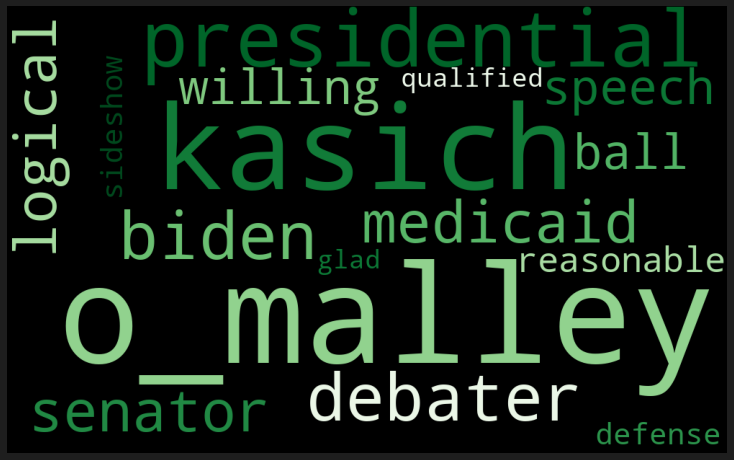

{'o_malley': 1.0,
 'kasich': 0.7142857142857143,
 'presidential': 0.42857142857142855,
 'debater': 0.2857142857142857,
 'biden': 0.2857142857142857,
 'senator': 0.21428571428571427,
 'medicaid': 0.21428571428571427,
 'logical': 0.21428571428571427,
 'willing': 0.21428571428571427,
 'speech': 0.21428571428571427,
 'ball': 0.21428571428571427,
 'reasonable': 0.21428571428571427,
 'sideshow': 0.14285714285714285,
 'defense': 0.14285714285714285,
 'qualified': 0.14285714285714285,
 'glad': 0.14285714285714285}

In [ ]:
words = wordcloud_lexeme(dataframe = data, lexeme_threshold = 50, analysis_for = 'support', cmap_wordcloud = 'Greens', count_threshold=3)
words

In [ ]:
support_words_ethos = {
 'presidential': 0.42857142857142855,
 'debater': 0.2857142857142857,
 'reasonable': 0.21428571428571427,
 'speech': 0.21428571428571427,
 'logical': 0.21428571428571427,
 'ball': 0.21428571428571427,
 'willing': 0.21428571428571427,
 'sideshow': 0.14285714285714285,
 'qualified': 0.14285714285714285,
 'glad': 0.14285714285714285,
 'defense': 0.14285714285714285,
 'brilliant': 0.14285714285714285}

In [ ]:
df_support_words_ethos = pd.DataFrame({'word': support_words_ethos.keys(), 'freq': support_words_ethos.values()})
#df_support_words_ethos.columns = ['word', 'frequency']
df_support_words_ethos.head()

,word,freq
0,presidential,0.428571
1,debater,0.285714
2,reasonable,0.214286
3,speech,0.214286
4,logical,0.214286


In [ ]:
df_support_words_ethos = transform_pos(df_support_words_ethos, 'word')

df_support_words_ethos = count_categories(df_support_words_ethos, categories_column = 'word_pos', prefix_txt = 'pos_')
df_support_words_ethos.iloc[:6]

,word,freq,word_pos,pos_ADJ,pos_NOUN,pos_VERB
0,presidential,0.428571,[ADJ],1,0,0
1,debater,0.285714,[NOUN],0,1,0
2,reasonable,0.214286,[ADJ],1,0,0
3,speech,0.214286,[NOUN],0,1,0
4,logical,0.214286,[ADJ],1,0,0
5,ball,0.214286,[NOUN],0,1,0


In [ ]:
df_support_words_ethos.iloc[:, 2:].describe().round(2).iloc[:3]

,pos_ADJ,pos_NOUN,pos_VERB
count,12.00,12.00,12.00
mean,0.50,0.42,0.08
std,0.52,0.51,0.29


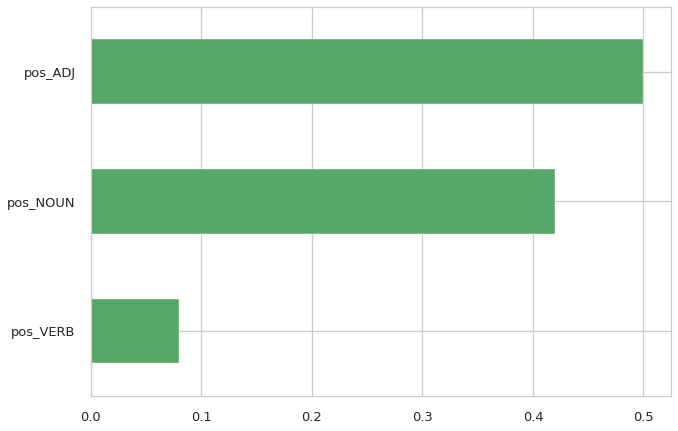

In [ ]:
df_support_words_ethos.iloc[:, 2:].describe().round(2).loc['mean'].sort_values().plot(kind = 'barh', color = 'g')

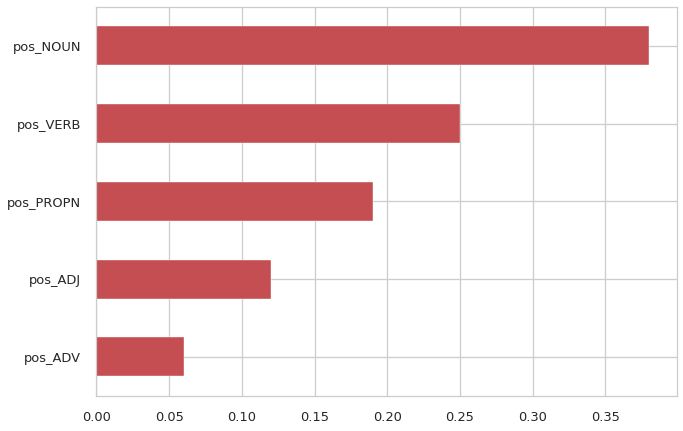

In [ ]:
df_attack_words_ethos.iloc[:, 2:].describe().round(2).loc['mean'].sort_values().plot(kind = 'barh', color = 'r')

##Pathos

In [ ]:
et1 = pd.read_excel('/content/drive/MyDrive/Colab Notebooks/reddit_IAA/plots_TNE/APP/LEP_test-main/app_US2016.xlsx', 
                     index_col=0)
et1.head(2)

,map_ID,Text,Source,Target,No_Ethos,Contains_ethos,Support,Attack,Ethos_Label,No_pathos,Contains_pathos,positive_valence,negative_valence,happiness,anger,sadness,fear,disgust,surprise,trust,anticipation,RA_logos,RA_relation,CA_logos,CA_relation,topic_1,topic_2,confidence_topic_1,confidence_topic_2,text_length,expressed_emotion_PaREMO,T5_emotion,expressed_sentiment,pathos_label,pathos_name,ethos_name,logos_name,clean_Text,clean_Text_lemmatized,EmotAn_label
0,10055,Please someone tell me I'm wrong,Emerica,NaN,1,0.0,0.0,0.0,0,0,1,0,1,0,0,0,1,0,0,0,0,NaN,NaN,NaN,NaN,healthcare illness,jobs,0.32,0.29,6,surprise,anger,Negative,-1,negative,neutral,neutral,Please someone tell me I'm wrong,please someone tell I I be wrong,anger
1,10055,"Take the people who are Bernie supporters, some jump to Webb",Emerica,NaN,1,0.0,0.0,0.0,0,1,0,0,0,0,0,0,0,0,0,0,0,RA,premise,CA,conclusion,campaign candidates,black lives hate manifestation,0.73,0.06,11,surprise,anger,Neutral,0,neutral,neutral,support,"Take the people who are Bernie supporters, some jump to Webb","take the people who be bernie supporter , some jump to webb",neutral


In [ ]:
et2 = pd.read_excel('/content/drive/MyDrive/Colab Notebooks/reddit_IAA/plots_TNE/APP/LEP_test-main/app_conspiracy.xlsx', 
                    index_col=0)
et2.head(2)

,map_ID,Text,Source,corpus,topic_1,topic_2,confidence_topic_1,confidence_topic_2,text_length,RA_logos,RA_relation,CA_logos,CA_relation,expressed_sentiment,expressed_sentiment_confidence,T5_emotion,Support,No_pathos,Contains_pathos,positive_valence,negative_valence,happiness,anger,sadness,fear,disgust,surprise,trust,anticipation,No_Ethos,Contains_ethos,Attack,Ethos_Label,Target,pathos_label,ethos_name,logos_name,pathos_name,clean_Text,clean_Text_lemmatized,EmotAn_label
0,22684,"Now, double vaccinated dying from COVID are blaming unvaccinated ones",Effective_Ad4588,1,death sickness ill,media news,0.77,0.74,10,NaN,NaN,CA,conclusion,Negative,0.836865,fear,NaN,NaN,1.0,NaN,1.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,2,the vaccinated,-1,attack,neutral,negative,"Now, double vaccinated dying from COVID are blaming unvaccinated ones","now , double vaccinate die from covid be blame unvaccinated one",anger
1,22684,It really is starting to make no sense,Effective_Ad4588,1,opinion worldview,conspiracy theory,0.78,0.65,8,NaN,NaN,CA,premise,Negative,0.915780,fear,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,0,NaN,0,neutral,attack,neutral,It really is starting to make no sense,it really be start to make no sense,anger


In [ ]:
df_pat = pd.concat([et1, et2], axis = 0)
df_pat = df_pat.reset_index(drop=True)
df_pat.shape

(6513, 42)

In [ ]:
df_pat.shape

(6513, 43)

In [ ]:
df_pat = lemma_text(df_pat, 'clean_Text')
df_pat.iloc[60:62]

In [ ]:
data = prepare_cloud_lexeme_data(df_pat[df_pat.pathos_label == 0], df_pat[df_pat.pathos_label  == 1], df_pat[df_pat.pathos_label  == -1])
data.tail()

,word,support #,neutral #,attack #,general #
5326,xenophobia,0.0,0.0,1.0,1.0
5327,narcissistic,0.0,0.0,1.0,1.0
5328,misfortune,0.0,0.0,1.0,1.0
5329,consciousness,0.0,0.0,1.0,1.0
5330,unlawful,0.0,0.0,1.0,1.0


There are 83 words.


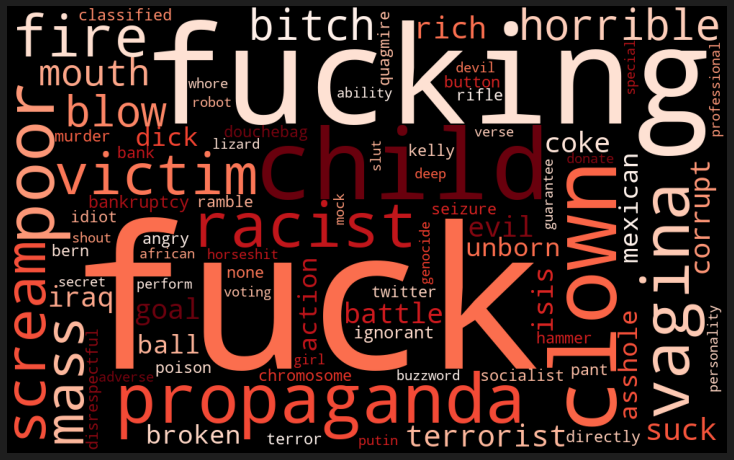

{'fuck': 1.0,
 'fucking': 0.3709677419354839,
 'child': 0.22580645161290322,
 'clown': 0.1935483870967742,
 'propaganda': 0.1774193548387097,
 'poor': 0.1774193548387097,
 'vagina': 0.16129032258064516,
 'racist': 0.14516129032258066,
 'victim': 0.14516129032258066,
 'fire': 0.14516129032258066,
 'scream': 0.14516129032258066,
 'mass': 0.12903225806451613,
 'horrible': 0.12903225806451613,
 'bitch': 0.12903225806451613,
 'blow': 0.12903225806451613,
 'mouth': 0.11290322580645161,
 'terrorist': 0.11290322580645161,
 'suck': 0.11290322580645161,
 'rich': 0.11290322580645161,
 'evil': 0.0967741935483871,
 'battle': 0.0967741935483871,
 'goal': 0.0967741935483871,
 'coke': 0.0967741935483871,
 'corrupt': 0.0967741935483871,
 'iraq': 0.0967741935483871,
 'isis': 0.0967741935483871,
 'broken': 0.08064516129032258,
 'ball': 0.08064516129032258,
 'dick': 0.08064516129032258,
 'asshole': 0.08064516129032258,
 'mexican': 0.08064516129032258,
 'unborn': 0.08064516129032258,
 'action': 0.080645161

In [ ]:
words = wordcloud_lexeme(dataframe = data, lexeme_threshold = 75, count_threshold = 3, 
                         analysis_for = 'attack', cmap_wordcloud = 'Reds')
words

In [ ]:
attack_words_pathos = {
    'fuck': 1.0,
 'fucking': 0.3709677419354839,
 'child': 0.22580645161290322,
 'clown': 0.1935483870967742,
 'propaganda': 0.1774193548387097,
 'poor': 0.1774193548387097,
 'vagina': 0.16129032258064516,
 'racist': 0.14516129032258066,
 'victim': 0.14516129032258066,
 'fire': 0.14516129032258066,
 'scream': 0.14516129032258066,
 'mass': 0.12903225806451613,
 'horrible': 0.12903225806451613,
 'bitch': 0.12903225806451613,
 'blow': 0.12903225806451613,
 'mouth': 0.11290322580645161,
 'terrorist': 0.11290322580645161,
 'suck': 0.11290322580645161,
 'rich': 0.11290322580645161,
 'evil': 0.0967741935483871,
 'battle': 0.0967741935483871,
 'goal': 0.0967741935483871,
 'coke': 0.0967741935483871,
 'corrupt': 0.0967741935483871,
 'iraq': 0.0967741935483871,
 'isis': 0.0967741935483871,
 'broken': 0.08064516129032258,
 'ball': 0.08064516129032258,
 'dick': 0.08064516129032258,
 'asshole': 0.08064516129032258,
 'mexican': 0.08064516129032258,
 'unborn': 0.08064516129032258,
 'action': 0.08064516129032258,
 'bankruptcy': 0.08064516129032258,
 'ignorant': 0.08064516129032258,
 'terror': 0.06451612903225806,
 'button': 0.06451612903225806,
 'douchebag': 0.06451612903225806,
 'disrespectful': 0.06451612903225806,
 'poison': 0.06451612903225806,
 'angry': 0.06451612903225806,
 'murder': 0.06451612903225806,
 'seizure': 0.06451612903225806,
 'directly': 0.06451612903225806,
 'rifle': 0.06451612903225806,
 'idiot': 0.06451612903225806,
 'hammer': 0.06451612903225806,
 'quagmire': 0.06451612903225806,
 'classified': 0.06451612903225806,
 'chromosome': 0.06451612903225806,
 'ramble': 0.06451612903225806,
 'socialist': 0.06451612903225806,
 'perform': 0.04838709677419355,
 'ability': 0.04838709677419355,
 'devil': 0.04838709677419355,
 'whore': 0.04838709677419355,
 'robot': 0.04838709677419355,
 'horseshit': 0.04838709677419355,
 'shout': 0.04838709677419355,
 'guarantee': 0.04838709677419355,
 'slut': 0.04838709677419355,
 'verse': 0.04838709677419355,
 'donate': 0.04838709677419355,
 'buzzword': 0.04838709677419355,
 'personality': 0.04838709677419355,
 'putin': 0.04838709677419355,
 'professional': 0.04838709677419355,
 'lizard': 0.04838709677419355,
 'voting': 0.04838709677419355,
 'girl': 0.04838709677419355,
 'deep': 0.04838709677419355,
 'mock': 0.04838709677419355,
 'special': 0.04838709677419355,
 'adverse': 0.04838709677419355,
 'secret': 0.04838709677419355,
 'genocide': 0.04838709677419355}

In [ ]:
df_attack_words_pathos = pd.DataFrame.from_dict({'word':attack_words_pathos.keys(), 'freq':attack_words_pathos.values()})
#df_attack_words_pathos.columns = ['word', 'frequency']
df_attack_words_pathos.head(10)

,word,freq
0,fuck,1.000000
1,fucking,0.370968
2,child,0.225806
3,clown,0.193548
4,propaganda,0.177419
5,poor,0.177419
6,vagina,0.161290
7,racist,0.145161
8,victim,0.145161
9,fire,0.145161


In [ ]:
df_attack_words_pathos = transform_pos(df_attack_words_pathos, 'word')

df_attack_words_pathos = count_categories(df_attack_words_pathos, categories_column = 'word_pos', prefix_txt = 'pos_')
df_attack_words_pathos.iloc[:6]

,word,freq,word_pos,pos_VERB,pos_NOUN,pos_ADJ,pos_PROPN,pos_ADV
0,fuck,1.000000,[VERB],1,0,0,0,0
1,fucking,0.370968,[VERB],1,0,0,0,0
2,child,0.225806,[NOUN],0,1,0,0,0
3,clown,0.193548,[NOUN],0,1,0,0,0
4,propaganda,0.177419,[NOUN],0,1,0,0,0
5,poor,0.177419,[ADJ],0,0,1,0,0


In [ ]:
df_attack_words_pathos.iloc[:, 2:].describe().round(2).iloc[:3]

,pos_VERB,pos_NOUN,pos_ADJ,pos_PROPN,pos_ADV
count,76.00,76.00,76.00,76.00,76.00
mean,0.18,0.49,0.18,0.13,0.01
std,0.39,0.50,0.39,0.34,0.11


###supp

There are 17 words.


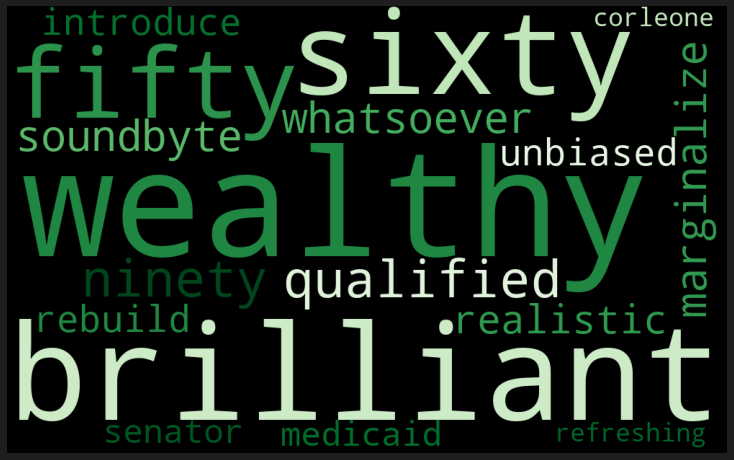

{'wealthy': 1.0,
 'brilliant': 1.0,
 'sixty': 1.0,
 'fifty': 1.0,
 'qualified': 1.0,
 'ninety': 1.0,
 'marginalize': 0.6666666666666666,
 'soundbyte': 0.6666666666666666,
 'whatsoever': 0.6666666666666666,
 'realistic': 0.6666666666666666,
 'introduce': 0.6666666666666666,
 'unbiased': 0.6666666666666666,
 'rebuild': 0.6666666666666666,
 'medicaid': 0.6666666666666666,
 'senator': 0.6666666666666666,
 'refreshing': 0.6666666666666666,
 'corleone': 0.6666666666666666}

In [ ]:
words = wordcloud_lexeme(dataframe = data, lexeme_threshold = 50, count_threshold = 2, analysis_for = 'support', cmap_wordcloud = 'Greens')
words

In [ ]:
support_words_pathos = {'wealthy': 1.0,
 'brilliant': 1.0,
 'qualified': 1.0,
 'realistic': 0.6666666666666666,
 'unbiased': 0.6666666666666666,
 'refreshing': 0.6666666666666666,
 'marginalize': 0.6666666666666666,
 'senator': 0.6666666666666666,
 'soundbyte': 0.6666666666666666,
 'rebuild': 0.6666666666666666,
 'introduce': 0.6666666666666666,
 'medicaid': 0.6666666666666666}

In [ ]:
df_support_words_pathos = pd.DataFrame.from_dict({'word':support_words_pathos.keys(), 'freq':support_words_pathos.values()})
#df_support_words_pathos.columns = ['word', 'frequency']
df_support_words_pathos.head(2)

,word,freq
0,wealthy,1.0
1,brilliant,1.0


In [ ]:
df_support_words_pathos = transform_pos(df_support_words_pathos, 'word')

df_support_words_pathos = count_categories(df_support_words_pathos, categories_column = 'word_pos', prefix_txt = 'pos_')
df_support_words_pathos

,word,freq,word_pos,pos_ADJ,pos_VERB,pos_NOUN,pos_PROPN
0,wealthy,1.000000,[ADJ],1,0,0,0
1,brilliant,1.000000,[ADJ],1,0,0,0
2,qualified,1.000000,[VERB],0,1,0,0
3,realistic,0.666667,[ADJ],1,0,0,0
4,unbiased,0.666667,[ADJ],1,0,0,0
5,refreshing,0.666667,[ADJ],1,0,0,0
6,marginalize,0.666667,[VERB],0,1,0,0
7,senator,0.666667,[NOUN],0,0,1,0
8,soundbyte,0.666667,[NOUN],0,0,1,0
9,rebuild,0.666667,[VERB],0,1,0,0


In [ ]:
df_support_words_pathos.loc[2, 'pos_ADJ'] = 1
df_support_words_pathos.loc[2, 'pos_VERB'] = 0

In [ ]:
df_support_words_pathos.iloc[:, 2:].describe().round(2).iloc[:3]

,pos_ADJ,pos_VERB,pos_NOUN,pos_PROPN
count,12.00,12.00,12.00,12.00
mean,0.50,0.25,0.17,0.08
std,0.52,0.45,0.39,0.29


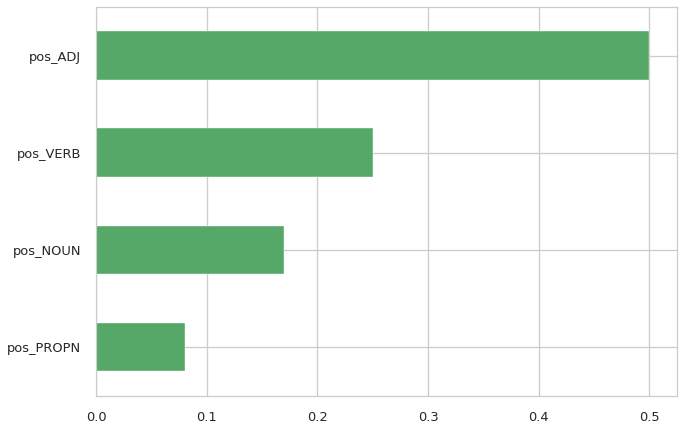

In [ ]:
df_support_words_pathos.iloc[:, 2:].describe().round(2).loc['mean'].sort_values().plot(kind = 'barh', color = 'g')

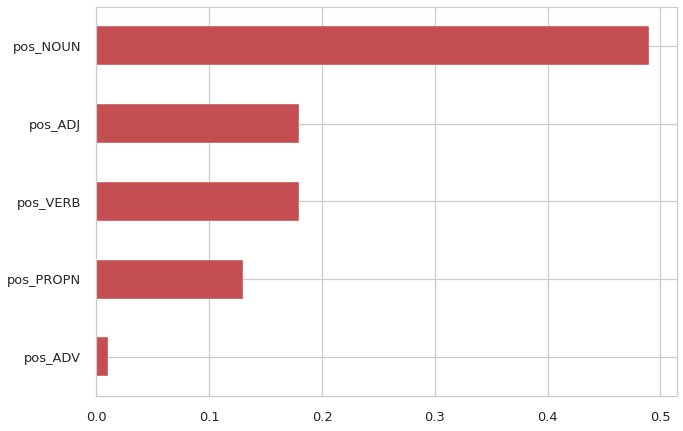

In [ ]:
df_attack_words_pathos.iloc[:, 2:].describe().round(2).loc['mean'].sort_values().plot(kind = 'barh', color = 'r')

#Build EP lexicon

In [ ]:
df_attack_words_pathos['category'] = 'P-'
df_attack_words_ethos['category'] = 'E-'
df_support_words_ethos['category'] = 'E+'
df_support_words_pathos['category'] = 'P+'

In [ ]:
df = pd.concat([df_attack_words_pathos, df_attack_words_ethos, 
                df_support_words_ethos, df_support_words_pathos], axis = 0, ignore_index=True)

In [ ]:
df['word_pos'] = df['word_pos'].apply(lambda x: x[0])
df.head(3)

,word,freq,word_pos,pos_VERB,pos_NOUN,pos_ADJ,pos_PROPN,pos_ADV,category
0,fuck,1.000000,VERB,1,0,0,0.0,0.0,P-
1,fucking,0.370968,VERB,1,0,0,0.0,0.0,P-
2,child,0.225806,NOUN,0,1,0,0.0,0.0,P-


In [ ]:
df.to_csv('/content/drive/MyDrive/Colab Notebooks/reddit_IAA/plots_TNE/EthosMining/lepAnLexicon2.csv')

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 132 entries, 0 to 131
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   word       132 non-null    object 
 1   freq       132 non-null    float64
 2   word_pos   132 non-null    object 
 3   pos_VERB   132 non-null    int64  
 4   pos_NOUN   132 non-null    int64  
 5   pos_ADJ    132 non-null    int64  
 6   pos_PROPN  120 non-null    float64
 7   pos_ADV    108 non-null    float64
 8   category   132 non-null    object 
dtypes: float64(3), int64(3), object(3)
memory usage: 9.4+ KB
